In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import pickle
import os
import plotnine
import warnings
from plotnine import *
import pandas as pd
from pandas import Series
from keras.models import load_model
from kerasAC.metrics import recall, specificity, fpr, fnr, precision, f1
from kerasAC.custom_losses import ambig_binary_crossentropy, ambig_mean_squared_error
from kerasAC.generators import *
import pybedtools

Using TensorFlow backend.


## Select GPU

In [3]:
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
!env | grep "CUDA"

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script
CUDA_VISIBLE_DEVICES=1
CUDA_HOME=/usr/local/cuda-10.0


## Get Model and Peak File Addresses

In [4]:
idr_peaks=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/idr.optimal.narrowPeaks.txt','r').read().strip().split('\n')
samples=open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/merged_tagAligns_outputs/samples.txt','r').read().strip().split('\n')
model_dict={}
idr_dict={}
for sample in samples:
    print(sample)
    model_dict[sample]='/mnt/lab_data3/soumyak/adpd/deeplearning/models/regression/mean/'+sample+'.model.'
    for idr_peaks_file in idr_peaks:
        if idr_peaks_file.__contains__(sample):
            idr_dict[sample]=idr_peaks_file

AD_ADAD_CAUD
AD_ADAD_HIPP
AD_ADAD_PARL
AD_ADAD_SMTG
AD_CTRH_CAUD
AD_CTRH_HIPP
AD_CTRH_PARL
AD_CTRH_SMTG
AD_CTRL_CAUD
AD_CTRL_HIPP
AD_CTRL_PARL
AD_CTRL_SMTG
AD_LOAD_CAUD
AD_LOAD_HIPP
AD_LOAD_PARL
AD_LOAD_SMTG
PD_CTRL_CAUD
PD_CTRL_HIPP
PD_CTRL_MDFG
PD_CTRL_MDTG
PD_CTRL_PTMN
PD_CTRL_SUNI
PD_GBA1_CAUD
PD_GBA1_HIPP
PD_GBA1_MDFG
PD_GBA1_MDTG
PD_GBA1_PTMN
PD_GBA1_SUNI
PD_LOPD_CAUD
PD_LOPD_HIPP
PD_LOPD_MDFG
PD_LOPD_MDTG
PD_LOPD_PTMN
PD_LOPD_SUNI
PD_LRRK_CAUD
PD_LRRK_HIPP
PD_LRRK_MDFG
PD_LRRK_MDTG
PD_LRRK_PTMN
PD_LRRK_SUNI


## Function to separate alternate alleles into individual rows

In [9]:
def format_snps(old_df, alt_col):                                               
    multirow = old_df[alt_col].str.split(',').apply(Series, 1).stack()          
    multirow.index = multirow.index.droplevel(-1)                               
    multirow.name = alt_col                                                     
    x = old_df.columns                                                          
    del old_df[alt_col]                                                         
    new_df = old_df.join(multirow)                                              
    new_df = new_df[x]                                                          
    return new_df

## Filter Original GWAS on P-value

In [ ]:
basefilename = '/mnt/lab_data3/soumyak/adpd/gwas/'
for fold in range(10):
    print(fold)
    for gwas_file in ['23andme_PD.formatted.txt.', 'GWAS_Kunkle2019.formatted.txt.']:
        gwas = pd.read_csv(basefilename+gwas_file+str(fold), sep='\t', keep_default_na=False)
        new_gwas = gwas.loc[gwas['PVALUE'] < 5e-8]
        new_gwas.to_csv(basefilename+gwas_file+'5e-8.'+str(fold), sep='\t', index=False)

## Get all SNPs around P-value filtered SNP

In [122]:
basefilename = '/mnt/lab_data3/soumyak/adpd/gwas/'
for fold in range(10):
    for gwas_file in ['23andme_PD.formatted.txt.', 'GWAS_Kunkle2019.formatted.txt.']:
        gwas = pd.read_csv(basefilename+gwas_file+'5e-8.'+str(fold), sep='\t', keep_default_na=False)
        gwas['START'] = gwas['START'] - 4999
        gwas['END'] = gwas['END'] + 5000
        gwas_bed = pybedtools.BedTool.from_dataframe(gwas)
        orig_gwas = pybedtools.BedTool(basefilename+gwas_file+str(fold))
        ld_buddies = orig_gwas.intersect(gwas_bed, u=True)
        if ld_buddies.count() != 0:
            ld_df = pybedtools.BedTool.to_dataframe(ld_buddies)
            ld_df.columns = gwas.columns
            new_ld_df = format_snps(ld_df, 'ALT')
            new_ld_df.to_csv(basefilename+gwas_file+'ld_buddies'+str(fold), sep='\t', index=False)

## Constant Addresses

In [20]:
ref_fasta='/mnt/data/annotations/by_release/hg19/male.hg19.fa'
snp_prefix='/mnt/lab_data3/soumyak/adpd/gwas'

## Add chr to CHR column

In [25]:
for fold in range(10):
    snp_file='/'.join([snp_prefix,'GWAS_Kunkle2019.formatted.txt.ld_buddies'])+str(fold)
    if os.path.exists(snp_file):
        snp_df = pd.read_csv(snp_file, sep='\t', keep_default_na=False)
        snp_df['CHR'] = snp_df['CHR'].apply(lambda x: 'chr' + str(x))
        snp_df.to_csv(snp_file, sep='\t', index=False)

## Get Predictions

In [21]:
def get_preds_all_folds(task, gwas, ref_fasta=ref_fasta, snp_prefix=snp_prefix, n_folds=10):
    
    if gwas == 'AD':
        all_snps_basename='GWAS_Kunkle2019.formatted.txt.ld_buddies'
    else:
        all_snps_basename='23andme_PD.formatted.txt.ld_buddies'

    model_prefix=model_dict[task]
    idr_peaks=idr_dict[task]
    
    for fold in range(n_folds): 
        snp_file='/'.join([snp_prefix,all_snps_basename])+str(fold)
        if os.path.exists(snp_file):
            print(fold)
            #load the model
            custom_objects={"recall":recall,
                            "sensitivity":recall,
                            "specificity":specificity,
                            "fpr":fpr,
                            "fnr":fnr,
                            "precision":precision,
                            "f1":f1,
                            "ambig_binary_crossentropy":ambig_binary_crossentropy,
                            "ambig_mean_squared_error":ambig_mean_squared_error}
            model=load_model(model_prefix+str(fold),custom_objects=custom_objects)
            print("loaded model")
            #get reference allele predictions 
            snp_ref_generator=SNPGenerator(data_path=snp_file,
                                           ref_fasta=ref_fasta,
                                           allele_col="REF")
            snp_ref_predictions=model.predict_generator(snp_ref_generator,
                                                        max_queue_size=5000, 
                                                        workers=40, 
                                                        use_multiprocessing=True,
                                                        verbose=1)
            print("got snp ref predictions")
            #get alternate allele predictions 
            snp_alt_generator=SNPGenerator(snp_file,
                                           ref_fasta=ref_fasta,
                                           allele_col="ALT")
            snp_alt_predictions=model.predict_generator(snp_alt_generator,
                                                        max_queue_size=5000, 
                                                        workers=40, 
                                                        use_multiprocessing=True, verbose=1)
            print("got snp alt predictions")
            snp_ref_generator.data['ref_pred']=snp_ref_predictions
            snp_ref_generator.data['alt_pred']=snp_alt_predictions
            snp_ref_generator.data.to_csv(task+'.'+str(fold)+'.MYGWAS_SNP_predictions.txt',sep='\t')

In [11]:
get_preds_all_folds('PD_GBA1_MDTG', 'PD')

0
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 5s 1s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 4s 1s/step
got snp alt predictions
1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 5s 2s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 4s 1s/step
got snp alt predictions
2
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 5s 3s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 4s 2s/step
g

In [12]:
get_preds_all_folds('PD_CTRL_SUNI', 'PD')

0
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 7s 2s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 4s 1s/step
got snp alt predictions
1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 7s 2s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 4s 1s/step
got snp alt predictions
2
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 7s 4s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 4s 2s/step
g

In [13]:
get_preds_all_folds('PD_GBA1_SUNI', 'PD')

0
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 8s 2s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 5s 1s/step
got snp alt predictions
1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 8s 3s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 5s 2s/step
got snp alt predictions
2
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 8s 4s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 5s 3s/step
g

In [26]:
get_preds_all_folds('AD_CTRL_SMTG','AD')

0
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(353, 8)
3/3 [==============================] - 11s 4s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(353, 8)
3/3 [==============================] - 6s 2s/step
got snp alt predictions
1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(3538, 8)
28/28 [==============================] - 11s 405ms/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(3538, 8)
13/28 [============>.................] - ETA: 7s 

ValueError: Error when checking input: expected conv2d_4_input to have 4 dimensions, but got array with shape (128, 1)

In [ ]:
get_preds_all_folds('AD_ADAD_SMTG','AD')

In [ ]:
get_preds_all_folds('AD_CTRL_PARL','AD')

In [ ]:
get_preds_all_folds('AD_ADAD_PARL','AD')

In [ ]:
get_preds_all_folds('AD_CTRL_HIPP','AD')

In [ ]:
get_preds_all_folds('PD_CTRL_HIPP','PD')

0
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 10s 3s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(446, 7)
4/4 [==============================] - 6s 1s/step
got snp alt predictions
1
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 11s 4s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(313, 7)
3/3 [==============================] - 7s 2s/step
got snp alt predictions
2
loaded model
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 11s 5s/step
got snp ref predictions
loaded labels
set index to CHR, START, END
filtered on chroms_to_use
data.shape:(212, 7)
2/2 [==============================] - 6s 3s/ste

In [ ]:
get_preds_all_folds('PD_GBA1_HIPP','PD')

## Get Results from all Folds

In [7]:
def get_results_all_folds(task):
    print("TASK: ",task)
    for fold in range(10):
        snp_file = task+'.'+str(fold)+'.MYGWAS_SNP_predictions.txt'
        if os.path.exists(snp_file):
            print("FOLD: ",fold)
            snp_predictions=pd.read_csv(snp_file,sep='\t')
            print("All SNPs:")
            display(snp_predictions.shape)
            snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
            idr_bed = pybedtools.BedTool(idr_peaks)
            pos_snps_bed = snp_bed.intersect(idr_bed, u=True)
            if pos_snps_bed.count() > 0:
                pos_snps = pybedtools.BedTool.to_dataframe(pos_snps_bed)
                pos_snps.columns = snp_predictions.columns
                print("SNPs in Peaks:")
                display(pos_snps.shape)
                plotnine.options.figure_size = (6,6)
                display((ggplot(pos_snps,
                    aes(x="ref_pred",y="alt_pred",label='RSID'))+
                geom_point(alpha=0.3,color='red')+
                theme_bw(20)+
                xlab("Reference Allele Prediction")+
                ylab("Alternate Allele Prediction")+
                ggtitle("GWAS Variants")))
                pos_snps['delta']=pos_snps['alt_pred']-pos_snps['ref_pred']
                pos_snp_predictions_sorted=pos_snps.sort_values(by=['delta'])
                print("Negative SNPs in Peaks:")
                display(pos_snp_predictions_sorted.head(10))
                print("Positive SNPs in Peaks:")
                display(pos_snp_predictions_sorted.tail(10))
            snp_bed = pybedtools.BedTool.from_dataframe(snp_predictions)
            idr_bed = pybedtools.BedTool(idr_peaks)
            neg_snps_bed = snp_bed.intersect(idr_bed, v=True)
            if neg_snps_bed.count() > 0:
                neg_snps = pybedtools.BedTool.to_dataframe(neg_snps_bed)
                neg_snps.columns = snp_predictions.columns
                print("SNPs NOT in Peaks:")
                display(neg_snps.shape)
                plotnine.options.figure_size = (6,6)
                display((ggplot(neg_snps,
                    aes(x="ref_pred",y="alt_pred",label='RSID'))+
                geom_point(alpha=0.3,color='red')+
                theme_bw(20)+
                xlab("Reference Allele Prediction")+
                ylab("Alternate Allele Prediction")+
                ggtitle("GWAS Variants")))
                neg_snps['delta']=neg_snps['alt_pred']-neg_snps['ref_pred']
                neg_snp_predictions_sorted=neg_snps.sort_values(by=['delta'])
                print("Negative SNPs OUTSIDE Peaks:")
                display(neg_snp_predictions_sorted.head(10))
                print("Positive SNPs OUTSIDE Peaks:")
                display(neg_snp_predictions_sorted.tail(10))

TASK:  PD_CTRL_MDTG
FOLD:  0
All SNPs:


(446, 12)

SNPs in Peaks:


(38, 12)

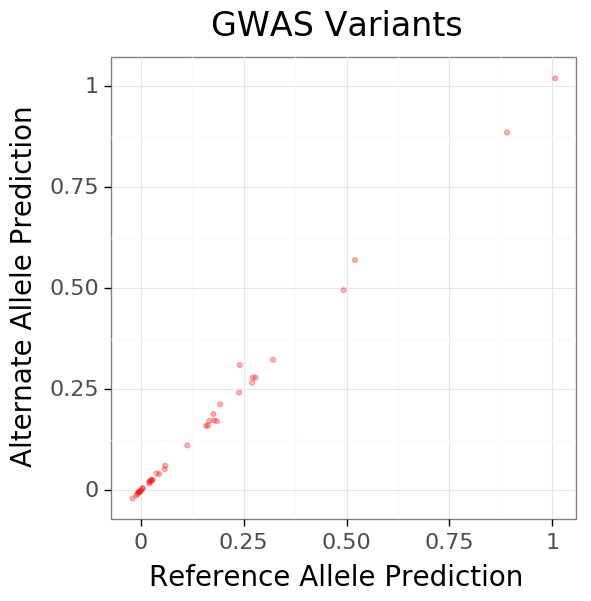

<ggplot: (-9223363249135826295)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
6,chr1,155135335,155135336,rs4460629,C,T,9.149490e-01,0.002004,0.018767,Y,0.184915,0.171194,-0.013721
5,chr1,155135036,155135037,rs35749011,A,G,5.326700e-14,-0.536007,0.066947,Y,0.057969,0.052282,-0.005687
13,chr1,155207549,155207550,rs762488,C,T,6.654640e-01,0.008818,0.020404,Y,0.178393,0.172842,-0.005551
35,chr1,205670871,205670872,rs12751694,A,G,7.916090e-01,0.051321,0.195357,Y,0.890088,0.885170,-0.004917
1,chr1,154983930,154983931,rs77982133,C,T,4.117510e-01,0.038985,0.047293,Y,0.270740,0.266005,-0.004735
12,chr1,155207367,155207368,rs74500255,A,T,2.015240e-01,1.753920,1.169310,Y,0.044837,0.040164,-0.004673
18,chr1,155208006,155208007,rs364897,C,T,2.004270e-01,-1.170800,0.809268,Y,0.028772,0.024702,-0.004070
31,chr1,155822971,155822972,rs822490,C,T,1.005310e-01,-0.032386,0.019693,Y,0.020869,0.016905,-0.003964
27,chr1,155822578,155822579,rs191848370,A,G,6.280000e-01,-0.087976,0.179494,Y,0.163508,0.160790,-0.002719
36,chr1,205671001,205671002,rs116664067,A,T,5.785580e-01,0.050852,0.092143,Y,0.113087,0.111227,-0.001860


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
9,chr1,155140023,155140024,rs114413971,A,C,0.326770,0.045034,0.046174,Y,0.492831,0.495317,0.002486
28,chr1,155822629,155822630,rs112685832,A,C,0.260298,0.037156,0.033118,Y,0.239030,0.241750,0.002720
17,chr1,155207985,155207986,rs74462743,C,T,0.144436,2.080070,1.183400,Y,0.038514,0.042045,0.003532
37,chr1,205671167,205671168,rs1417725,A,G,0.022548,0.114527,0.050882,Y,0.166853,0.172119,0.005266
14,chr1,155207626,155207627,rs2009578,A,G,0.882222,0.003030,0.020456,Y,0.271964,0.278992,0.007028
34,chr1,205670726,205670727,rs823098,A,G,0.114962,0.079276,0.050799,Y,1.007172,1.019161,0.011990
19,chr1,155208361,155208362,rs147138516,C,G,0.014743,1.417620,0.495539,Y,0.176430,0.188875,0.012445
26,chr1,155822529,155822530,rs13376235,A,G,0.521447,-0.028032,0.043575,Y,0.193116,0.212857,0.019741
10,chr1,155140027,155140028,rs12131522,C,T,0.958053,0.000990,0.018828,Y,0.520425,0.569928,0.049503
33,chr1,205670369,205670370,rs6673687,A,T,0.000008,-0.086770,0.019520,Y,0.240522,0.309740,0.069218


SNPs NOT in Peaks:


(408, 12)

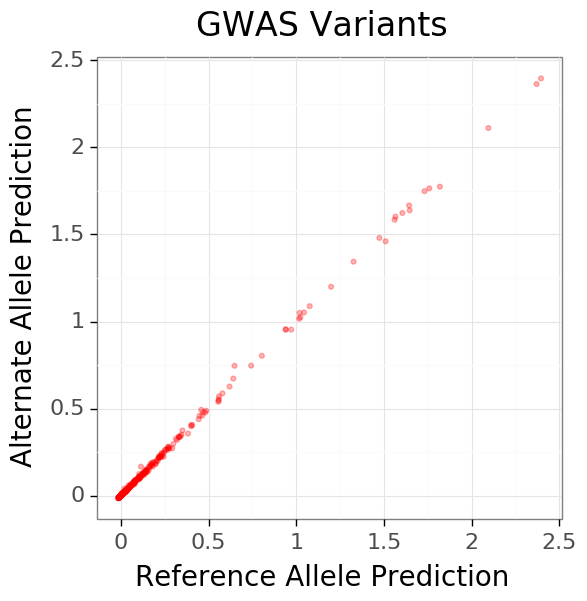

<ggplot: (-9223363250152596350)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
316,chr1,205718858,205718859,rs7536483,A,T,4.290230e-02,0.038184,0.018846,Y,1.509446,1.460546,-0.048899
85,chr1,155113074,155113075,rs12745576,A,C,9.734980e-01,-0.001967,0.059259,Y,1.818723,1.774218,-0.044506
28,chr1,154914552,154914553,rs6690352,C,T,2.598440e-01,0.542296,0.450027,Y,0.382727,0.356677,-0.026051
37,chr1,154916380,154916381,rs190798318,C,T,3.521610e-01,-0.239792,0.264808,Y,0.293364,0.271789,-0.021575
89,chr1,155115260,155115261,rs4246529,C,T,9.256370e-02,0.032142,0.019125,Y,0.243777,0.224200,-0.019577
81,chr1,155109973,155109974,rs144486053,G,T,2.418940e-01,-0.090938,0.078615,Y,0.971221,0.953358,-0.017863
407,chr1,205744218,205744219,rs1572931,C,T,8.115450e-02,-0.047969,0.027636,Y,0.555501,0.539202,-0.016300
157,chr1,155205378,155205379,rs12752133,C,T,1.240970e-13,0.553975,0.070121,Y,0.197836,0.182603,-0.015233
11,chr1,154911651,154911652,rs4845694,C,G,7.796100e-01,0.005313,0.018987,Y,0.150899,0.135845,-0.015054
285,chr1,205674637,205674638,rs114794039,A,G,1.524520e-01,0.097961,0.069256,Y,0.182289,0.167428,-0.014861


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
223,chr1,155412037,155412038,rs11264371,C,T,0.578178,0.012187,0.021899,Y,0.019365,0.040089,0.020725
51,chr1,154987526,154987527,rs11264295,C,T,0.973705,-0.000623,0.018902,Y,0.351118,0.374194,0.023076
58,chr1,154990297,154990298,rs2242194,C,G,0.757144,-0.006030,0.019504,Y,1.643215,1.666491,0.023276
144,chr1,155139509,155139510,rs7556304,C,T,0.938406,0.001451,0.018780,Y,1.561024,1.584467,0.023443
315,chr1,205718810,205718811,rs12727532,C,T,0.454834,-0.208047,0.284532,Y,1.018890,1.049558,0.030668
314,chr1,205718468,205718469,rs12047038,A,G,0.001904,-0.067468,0.021833,Y,0.640878,0.672544,0.031666
93,chr1,155118588,155118589,rs147847496,C,T,0.840517,0.012015,0.059622,Y,0.458236,0.492841,0.034605
4,chr1,154910012,154910013,rs877343,A,G,0.762849,0.005721,0.018957,Y,1.565254,1.602016,0.036762
286,chr1,205674897,205674898,rs111299170,C,T,0.329323,-0.034498,0.035505,Y,0.114593,0.166609,0.052017
0,chr1,154909169,154909170,rs17356361,C,T,0.276788,0.055702,0.050864,Y,0.648009,0.745719,0.097710


FOLD:  1
All SNPs:


(313, 12)

SNPs in Peaks:


(9, 12)

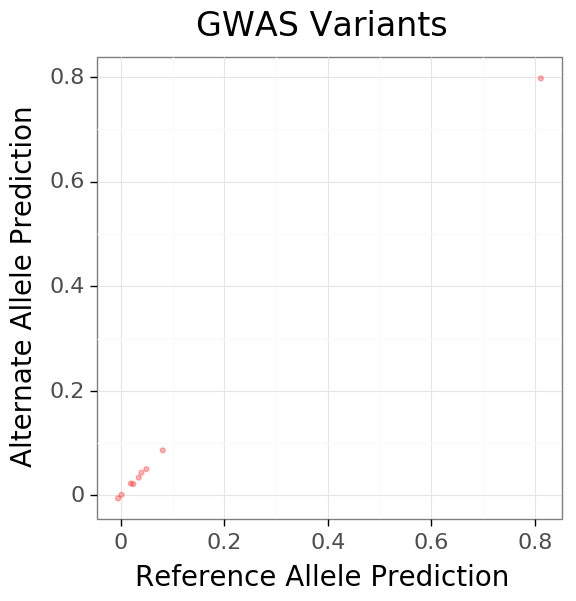

<ggplot: (-9223363250152661774)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
0,chr2,169109956,169109957,rs13002388,A,G,6.338120e-01,-0.012918,0.027152,Y,0.811750,0.797279,-0.014472
4,chr2,169110621,169110622,rs12622375,A,G,2.420800e-03,-0.057436,0.018949,Y,0.023622,0.021800,-0.001822
1,chr2,169110394,169110395,rs1474055,C,T,1.112500e-11,0.184632,0.026727,Y,0.034377,0.033897,-0.000480
8,chr2,169132643,169132644,rs67058614,D,I,3.756770e-01,0.024522,0.027746,Y,-0.005638,-0.005638,0.000000
7,chr2,169132611,169132612,rs77548116,C,T,7.952470e-01,0.012166,0.046951,Y,0.000992,0.001195,0.000203
2,chr2,169110422,169110423,rs147610000,C,T,5.147330e-02,-0.088236,0.045731,Y,0.049012,0.050315,0.001302
6,chr2,169131721,169131722,rs955896,A,T,3.743930e-01,0.024463,0.027606,Y,0.018978,0.022820,0.003842
5,chr2,169131135,169131136,rs183501421,C,T,3.234590e-01,-0.195448,0.202374,Y,0.039534,0.043535,0.004000
3,chr2,169110500,169110501,rs12474289,A,G,7.941460e-01,0.128192,0.499616,Y,0.080622,0.086232,0.005609


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
0,chr2,169109956,169109957,rs13002388,A,G,6.338120e-01,-0.012918,0.027152,Y,0.811750,0.797279,-0.014472
4,chr2,169110621,169110622,rs12622375,A,G,2.420800e-03,-0.057436,0.018949,Y,0.023622,0.021800,-0.001822
1,chr2,169110394,169110395,rs1474055,C,T,1.112500e-11,0.184632,0.026727,Y,0.034377,0.033897,-0.000480
8,chr2,169132643,169132644,rs67058614,D,I,3.756770e-01,0.024522,0.027746,Y,-0.005638,-0.005638,0.000000
7,chr2,169132611,169132612,rs77548116,C,T,7.952470e-01,0.012166,0.046951,Y,0.000992,0.001195,0.000203
2,chr2,169110422,169110423,rs147610000,C,T,5.147330e-02,-0.088236,0.045731,Y,0.049012,0.050315,0.001302
6,chr2,169131721,169131722,rs955896,A,T,3.743930e-01,0.024463,0.027606,Y,0.018978,0.022820,0.003842
5,chr2,169131135,169131136,rs183501421,C,T,3.234590e-01,-0.195448,0.202374,Y,0.039534,0.043535,0.004000
3,chr2,169110500,169110501,rs12474289,A,G,7.941460e-01,0.128192,0.499616,Y,0.080622,0.086232,0.005609


SNPs NOT in Peaks:


(304, 12)

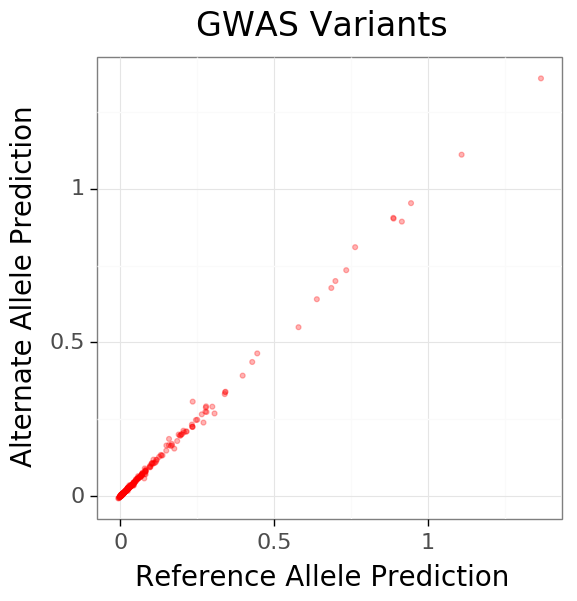

<ggplot: (8786702083655)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
2,chr2,169087232,169087233,rs16855155,A,G,4.915430e-01,-0.117109,0.167852,Y,0.306345,0.269296,-0.037050
62,chr2,169096718,169096719,rs13401489,G,T,6.194720e-03,0.051431,0.018802,Y,0.270337,0.239500,-0.030836
203,chr2,169147533,169147534,rs2138754,C,T,4.890620e-02,-0.036881,0.018724,Y,0.579561,0.549499,-0.030062
12,chr2,169088773,169088774,rs1878485,G,T,8.766850e-01,0.008866,0.057200,Y,0.915769,0.892627,-0.023142
86,chr2,169106699,169106700,rs74271810,C,G,9.943820e-01,-0.000962,0.136617,Y,0.175338,0.155024,-0.020313
249,chr2,169155460,169155461,rs13432275,A,C,7.537470e-03,0.053040,0.019896,Y,0.077613,0.058161,-0.019452
226,chr2,169151572,169151573,rs10930319,C,G,4.326780e-02,-0.037820,0.018710,Y,0.081970,0.071356,-0.010614
80,chr2,169104348,169104349,rs181364589,A,T,7.559290e-01,0.060341,0.195246,Y,1.368445,1.358010,-0.010435
201,chr2,169147029,169147030,rs78166116,A,G,3.485210e-01,-0.206268,0.215022,Y,0.235068,0.225236,-0.009831
79,chr2,169103999,169104000,rs76179989,G,T,9.560470e-12,-0.185191,0.026721,Y,0.686267,0.676972,-0.009295


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
93,chr2,169109230,169109231,rs10930318,C,T,0.678427,-0.011262,0.027194,Y,0.079242,0.090675,0.011434
85,chr2,169106176,169106177,rs114802580,A,G,0.256585,-0.162802,0.140754,Y,0.107553,0.119243,0.011690
77,chr2,169103143,169103144,rs73013478,C,T,0.632657,-0.015436,0.032347,Y,0.888943,0.902255,0.013312
64,chr2,169096810,169096811,rs116311695,C,G,0.161103,0.089341,0.063100,Y,0.278727,0.292337,0.013610
298,chr2,169169589,169169590,rs115802045,C,T,0.916351,0.016400,0.157416,Y,0.149602,0.165239,0.015637
182,chr2,169140909,169140910,rs4458184,A,C,0.564476,0.016130,0.028039,Y,0.887945,0.904875,0.016930
63,chr2,169096765,169096766,rs1517323,C,T,0.063687,-0.039536,0.021375,Y,0.445228,0.464373,0.019145
303,chr2,169171245,169171246,rs58843270,A,G,0.000206,-0.146987,0.038954,Y,0.158183,0.186466,0.028282
268,chr2,169158403,169158404,rs1517340,A,G,0.013007,-0.046962,0.018924,Y,0.763787,0.809558,0.045771
181,chr2,169140638,169140639,rs6741911,A,C,0.609587,-0.014043,0.027537,Y,0.235211,0.307638,0.072427


FOLD:  2
All SNPs:


(212, 12)

SNPs in Peaks:


(12, 12)

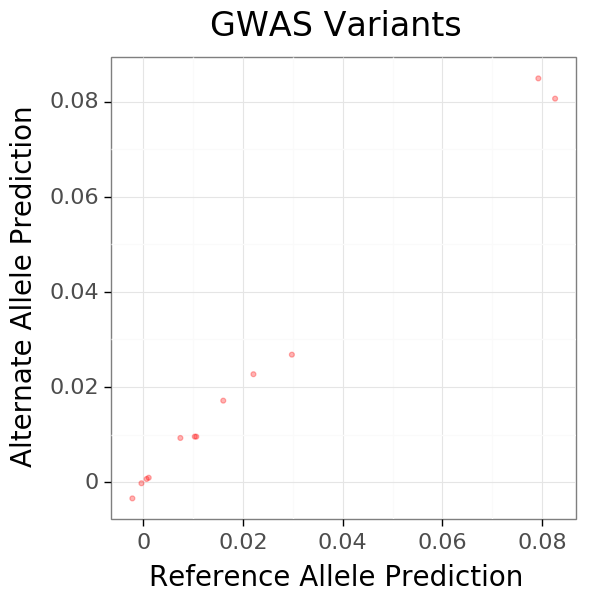

<ggplot: (-9223363250026557545)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
1,chr3,182710680,182710681,rs4859261,C,T,4.221840e-08,0.111944,0.020551,Y,0.029803,0.026806,-0.002997
8,chr3,182739836,182739837,rs77458140,G,T,7.987470e-01,-0.014804,0.058171,Y,0.082623,0.080658,-0.001966
5,chr3,182714378,182714379,rs186753914,A,G,3.377360e-01,-0.142495,0.146379,Y,-0.002203,-0.003425,-0.001221
7,chr3,182739778,182739779,rs182753925,C,T,9.171920e-02,-0.295525,0.181985,Y,0.010622,0.009563,-0.001059
4,chr3,182713941,182713942,rs74902465,A,G,4.302800e-08,-0.112069,0.020585,Y,0.010320,0.009565,-0.000754
11,chr3,182740801,182740802,rs73883999,C,T,9.454170e-02,0.421845,0.267292,Y,0.001074,0.000920,-0.000154
10,chr3,182740762,182740763,rs146449896,D,I,9.030890e-02,-0.427681,0.267704,Y,0.000657,0.000657,0.000000
2,chr3,182710940,182710941,rs78126209,A,G,8.569130e-01,0.010954,0.060833,Y,-0.000383,-0.000245,0.000137
3,chr3,182711005,182711006,rs144166036,G,T,3.460340e-01,-0.428322,0.478385,Y,0.022091,0.022692,0.000601
0,chr3,182710489,182710490,rs147515099,A,G,5.579360e-01,-0.044117,0.074948,Y,0.016035,0.017133,0.001098


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
5,chr3,182714378,182714379,rs186753914,A,G,3.377360e-01,-0.142495,0.146379,Y,-0.002203,-0.003425,-0.001221
7,chr3,182739778,182739779,rs182753925,C,T,9.171920e-02,-0.295525,0.181985,Y,0.010622,0.009563,-0.001059
4,chr3,182713941,182713942,rs74902465,A,G,4.302800e-08,-0.112069,0.020585,Y,0.010320,0.009565,-0.000754
11,chr3,182740801,182740802,rs73883999,C,T,9.454170e-02,0.421845,0.267292,Y,0.001074,0.000920,-0.000154
10,chr3,182740762,182740763,rs146449896,D,I,9.030890e-02,-0.427681,0.267704,Y,0.000657,0.000657,0.000000
2,chr3,182710940,182710941,rs78126209,A,G,8.569130e-01,0.010954,0.060833,Y,-0.000383,-0.000245,0.000137
3,chr3,182711005,182711006,rs144166036,G,T,3.460340e-01,-0.428322,0.478385,Y,0.022091,0.022692,0.000601
0,chr3,182710489,182710490,rs147515099,A,G,5.579360e-01,-0.044117,0.074948,Y,0.016035,0.017133,0.001098
6,chr3,182739738,182739739,rs11928508,C,G,4.694950e-08,0.113244,0.020874,Y,0.007427,0.009282,0.001855
9,chr3,182739950,182739951,rs73883998,C,T,8.534280e-02,0.433547,0.267406,Y,0.079260,0.084916,0.005656


SNPs NOT in Peaks:


(200, 12)

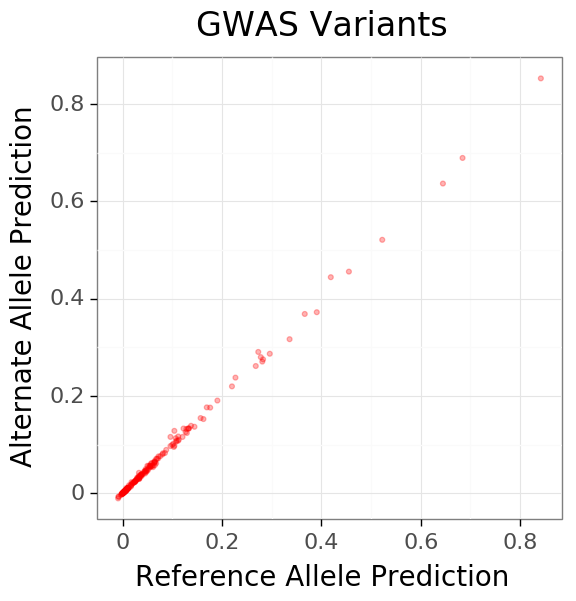

<ggplot: (-9223363250152629472)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
66,chr3,182729103,182729104,rs12496089,G,T,9.055830e-01,-0.006024,0.050753,Y,0.336144,0.316811,-0.019333
67,chr3,182729141,182729142,rs116438848,A,G,4.600150e-01,0.061375,0.083598,Y,0.390845,0.372211,-0.018635
101,chr3,182737208,182737209,rs1135365,A,T,6.764830e-01,-0.015106,0.036138,Y,0.281176,0.270800,-0.010376
31,chr3,182718334,182718335,rs189240771,A,G,9.633470e-01,0.023232,0.536104,Y,0.162771,0.152821,-0.009950
71,chr3,182729625,182729626,rs57575693,A,G,3.942610e-01,0.309809,0.377993,Y,0.296266,0.286900,-0.009366
69,chr3,182729531,182729532,rs77687927,G,T,8.083060e-01,-0.041156,0.170430,Y,0.644739,0.636334,-0.008405
64,chr3,182728580,182728581,rs142457109,C,T,2.532620e-01,-0.428124,0.394626,Y,0.144743,0.136977,-0.007766
129,chr3,182748495,182748496,rs10937108,A,T,4.053010e-10,-0.150923,0.024465,Y,0.103210,0.095614,-0.007596
75,chr3,182730772,182730773,rs186945002,G,T,7.851590e-01,-0.033262,0.122523,Y,0.282733,0.275395,-0.007338
74,chr3,182730348,182730349,rs188817002,A,T,2.585330e-02,0.496198,0.235008,Y,0.061269,0.054156,-0.007113


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
181,chr3,182761828,182761829,rs57211814,C,T,1.374020e-01,0.514338,0.323222,Y,0.049947,0.056949,0.007002
1,chr3,182704187,182704188,rs73066937,C,T,1.089850e-01,-0.573422,0.332846,Y,0.169475,0.176827,0.007352
78,chr3,182732230,182732231,rs9290751,A,G,4.032660e-10,-0.151436,0.024546,Y,0.032963,0.042492,0.009529
191,chr3,182763652,182763653,rs3772721,A,C,9.513320e-01,0.003558,0.058394,Y,0.841832,0.852235,0.010404
152,chr3,182753388,182753389,rs114588304,A,G,7.310890e-01,-0.282310,0.795366,Y,0.227184,0.237893,0.010709
154,chr3,182754574,182754575,rs10937109,A,G,6.397410e-01,-0.016941,0.036122,Y,0.122653,0.133403,0.010750
190,chr3,182763580,182763581,rs1502762,A,G,6.601880e-05,-0.092512,0.023362,Y,0.273133,0.290621,0.017488
102,chr3,182737509,182737510,rs6443842,A,G,6.769160e-01,-0.015084,0.036138,Y,0.096383,0.116177,0.019795
41,chr3,182721367,182721368,rs76575391,C,G,7.271710e-01,-0.020656,0.059355,Y,0.104260,0.128621,0.024362
50,chr3,182725046,182725047,rs76823265,C,G,7.680770e-01,0.017398,0.059124,Y,0.419081,0.444097,0.025017


FOLD:  3
All SNPs:


(90, 12)

SNPs NOT in Peaks:


(90, 12)

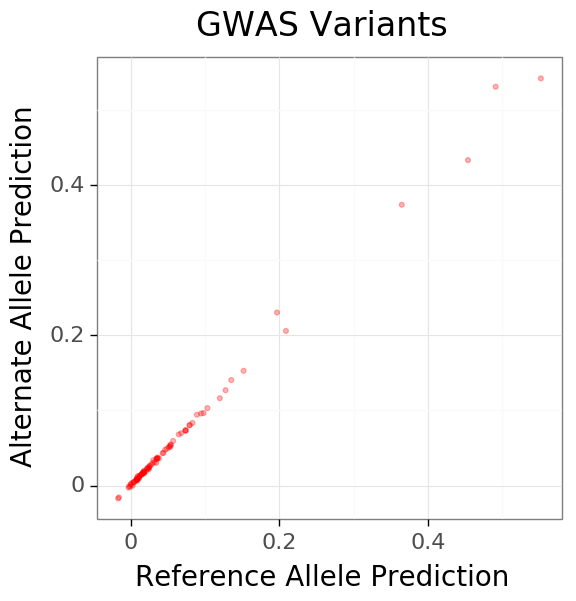

<ggplot: (8786702081670)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
13,chr6,27671662,27671663,rs112219934,A,G,7.545050e-01,0.113176,0.367971,Y,0.453589,0.432922,-0.020668
11,chr6,27671598,27671599,rs149417812,C,T,8.407370e-01,-0.024350,0.120784,Y,0.551572,0.541652,-0.009920
42,chr6,27676854,27676855,rs61025649,C,T,3.058820e-01,-0.131009,0.130237,Y,0.034534,0.030094,-0.004441
63,chr6,27681215,27681216,rs9468199,A,G,1.768120e-09,-0.143608,0.023593,Y,0.119964,0.116162,-0.003802
14,chr6,27671825,27671826,rs13192965,A,G,4.338700e-01,-0.026299,0.033509,Y,0.208881,0.205637,-0.003243
26,chr6,27674326,27674327,rs78523698,C,T,1.335780e-01,-0.092829,0.061170,Y,0.002828,-0.000144,-0.002972
19,chr6,27673073,27673074,rs16867921,C,G,4.782470e-02,0.067200,0.034218,Y,0.024759,0.021795,-0.002964
8,chr6,27671359,27671360,rs186281424,G,T,4.318160e-01,-0.216143,0.283047,Y,0.009027,0.006847,-0.002180
20,chr6,27673613,27673614,rs77853383,G,T,5.746110e-02,-0.064808,0.034366,Y,0.053575,0.051477,-0.002098
40,chr6,27676794,27676795,rs4713118,A,G,1.837570e-08,0.118983,0.020996,Y,0.038105,0.036029,-0.002076


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
18,chr6,27672695,27672696,rs9368526,C,T,0.048438,-0.067011,0.034215,Y,0.000314,0.002031,0.001718
21,chr6,27673678,27673679,rs191578809,C,T,0.446837,-0.148957,0.193001,Y,0.057188,0.059274,0.002086
85,chr6,27685158,27685159,rs74783880,C,T,0.017956,0.087005,0.036404,Y,0.009701,0.012689,0.002988
55,chr6,27679725,27679726,rs184375926,C,T,0.223262,-0.157757,0.127205,Y,0.030384,0.033586,0.003202
62,chr6,27681125,27681126,rs144057412,C,T,0.555350,0.081081,0.136319,Y,0.064739,0.067983,0.003244
64,chr6,27681485,27681486,rs115693476,A,G,0.424208,-0.461612,0.616952,Y,0.135347,0.140245,0.004898
61,chr6,27681037,27681038,rs73389015,A,G,0.469753,-0.291216,0.421511,Y,0.089173,0.094143,0.004971
12,chr6,27671657,27671658,rs6930169,G,T,0.206325,0.097462,0.078000,Y,0.364621,0.373504,0.008884
9,chr6,27671457,27671458,rs77032218,A,G,0.059146,0.064289,0.034317,Y,0.196810,0.230167,0.033357
10,chr6,27671590,27671591,rs140187308,C,T,0.342305,0.177072,0.183344,Y,0.490868,0.530531,0.039662


FOLD:  5
All SNPs:


(2339, 12)

SNPs in Peaks:


(56, 12)

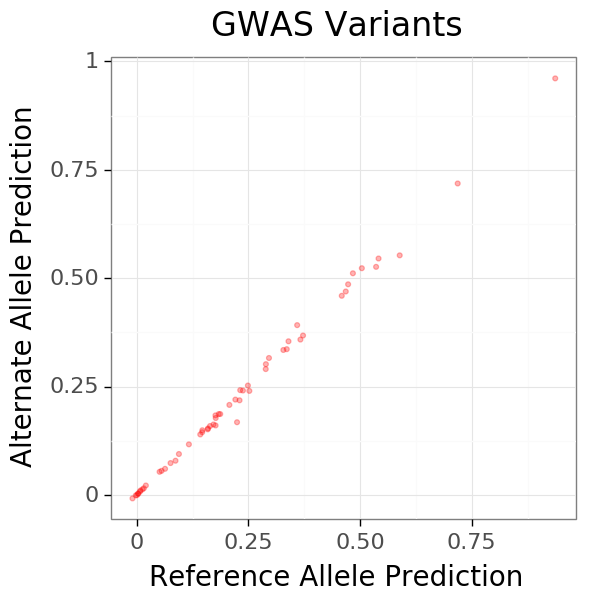

<ggplot: (8786702139368)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
45,chr4,987663,987664,rs3806758,C,G,0.100219,-0.037952,0.023033,Y,0.224547,0.167794,-0.056753
11,chr4,875994,875995,rs2279185,C,G,0.554847,-0.024914,0.042066,Y,0.588651,0.552708,-0.035944
46,chr4,987673,987674,rs3806759,A,G,0.644937,0.015097,0.032813,Y,0.176607,0.160397,-0.016209
23,chr4,959063,959064,rs143484618,A,G,0.121640,0.175635,0.116098,Y,0.252132,0.240044,-0.012087
16,chr4,957356,957357,rs75854631,A,G,0.106170,0.080468,0.050315,Y,0.230190,0.218400,-0.011789
18,chr4,957778,957779,rs2335500,A,G,0.961210,-0.002649,0.054401,Y,0.535821,0.526165,-0.009655
1,chr4,874986,874987,rs3775131,C,T,0.419328,0.039773,0.049009,Y,0.171896,0.162573,-0.009323
14,chr4,876318,876319,rs3736087,C,T,0.000442,0.087918,0.024840,Y,0.366363,0.358411,-0.007952
38,chr4,987276,987277,rs11936407,C,T,0.004757,0.055141,0.019494,Y,0.086862,0.079002,-0.007860
44,chr4,987554,987555,rs3806757,C,G,0.109142,-0.080699,0.050886,Y,0.158896,0.151452,-0.007444


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
47,chr4,987704,987705,rs3806760,A,G,5.847880e-01,0.011547,0.021144,Y,0.176230,0.183620,0.007390
26,chr4,960331,960332,rs11248059,C,G,7.720080e-07,0.137055,0.027375,Y,0.231686,0.241773,0.010087
37,chr4,987210,987211,rs2276905,C,T,3.077370e-01,-0.155840,0.155903,Y,0.289155,0.301699,0.012543
15,chr4,876399,876400,rs3736086,C,T,5.207610e-01,-0.027152,0.042145,Y,0.473186,0.485901,0.012716
27,chr4,960542,960543,rs35117553,G,T,2.365500e-01,0.057519,0.048939,Y,0.339727,0.354483,0.014756
4,chr4,875155,875156,rs3775129,A,G,4.289400e-04,-0.087336,0.024621,Y,0.503879,0.523041,0.019162
12,chr4,876141,876142,rs10902760,C,G,5.229730e-01,-0.027015,0.042157,Y,0.296037,0.315951,0.019914
34,chr4,986736,986737,rs115548745,A,G,8.147180e-01,-0.148069,0.623177,Y,0.936729,0.960816,0.024086
17,chr4,957598,957599,rs192259574,A,C,7.639040e-01,-0.179317,0.585179,Y,0.483885,0.511331,0.027446
3,chr4,875144,875145,rs3775130,A,G,3.748770e-05,-0.121438,0.029109,Y,0.359135,0.391748,0.032613


SNPs NOT in Peaks:


(2283, 12)

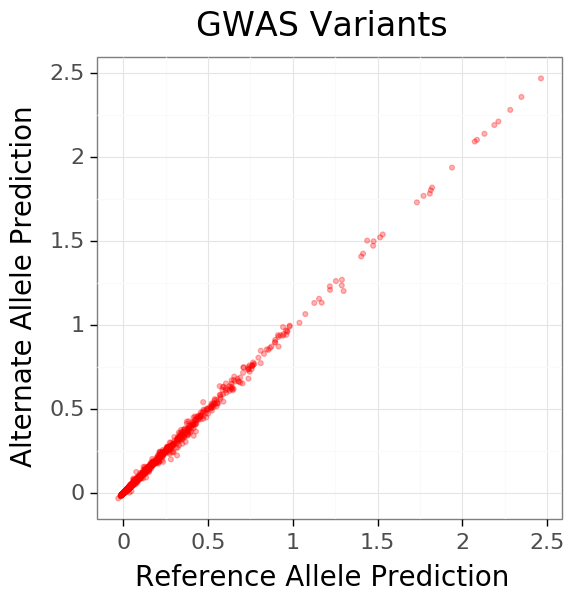

<ggplot: (-9223363250152749245)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
207,chr4,956364,956365,rs61757581,C,G,4.205890e-01,0.100553,0.126414,Y,1.299193,1.204301,-0.094892
1333,chr4,90721492,90721493,rs28720123,A,G,2.469290e-02,0.838997,0.426378,Y,0.317217,0.225603,-0.091614
773,chr4,90607295,90607296,rs11735874,A,C,2.325880e-01,0.081447,0.068973,Y,0.280873,0.202644,-0.078230
769,chr4,90607077,90607078,rs10029694,C,G,6.572040e-04,0.099345,0.029465,Y,0.415504,0.343155,-0.072349
213,chr4,961373,961374,rs1377586,A,G,5.111900e-09,0.109895,0.018848,Y,0.367904,0.306621,-0.061282
1271,chr4,90709594,90709595,rs115322031,C,T,3.383940e-02,-0.168068,0.080846,Y,0.428571,0.368327,-0.060245
31,chr4,873023,873024,rs77689311,C,T,4.175760e-01,0.039911,0.048993,Y,0.738005,0.682714,-0.055291
1337,chr4,90721895,90721896,rs28536191,A,G,1.080770e-01,-0.783807,0.548018,Y,0.349045,0.295362,-0.053683
1149,chr4,90683706,90683707,rs17016107,A,G,3.816100e-01,0.091578,0.105945,Y,0.297399,0.245746,-0.051653
1593,chr4,90759047,90759048,rs2619363,G,T,1.427720e-08,0.117808,0.020641,Y,1.288309,1.237454,-0.050855


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
253,chr4,971266,971267,rs11731377,G,T,1.386110e-04,-0.095813,0.024939,Y,0.386299,0.428874,0.042575
132,chr4,940904,940905,rs35208825,A,G,7.985180e-03,0.092293,0.035165,Y,0.592001,0.634890,0.042889
420,chr4,90508045,90508046,rs182778415,A,T,1.631020e-01,0.263486,0.195131,Y,0.586825,0.632216,0.045391
279,chr4,979387,979388,rs185055324,C,T,5.735210e-04,0.418104,0.115711,Y,0.941954,0.989637,0.047683
1876,chr4,90810732,90810733,rs74664209,C,G,1.338330e-09,0.272700,0.043602,Y,0.605650,0.654309,0.048659
2016,chr4,90835558,90835559,rs17806425,C,T,1.356870e-03,0.174296,0.053331,Y,0.076603,0.127539,0.050935
934,chr4,90638896,90638897,rs60838312,A,G,5.445150e-01,-0.024937,0.041275,Y,0.375047,0.427790,0.052743
60,chr4,901982,901983,rs190834547,A,G,6.898110e-01,-0.056041,0.139568,Y,1.438204,1.504002,0.065798
1258,chr4,90705960,90705961,rs143963281,C,T,4.412930e-01,-0.157300,0.208153,Y,0.568373,0.638063,0.069691
3,chr4,869169,869170,rs11733713,A,G,5.487240e-05,0.118337,0.028998,Y,0.471224,0.543240,0.072015


FOLD:  7
All SNPs:


(5222, 12)

SNPs in Peaks:


(473, 12)

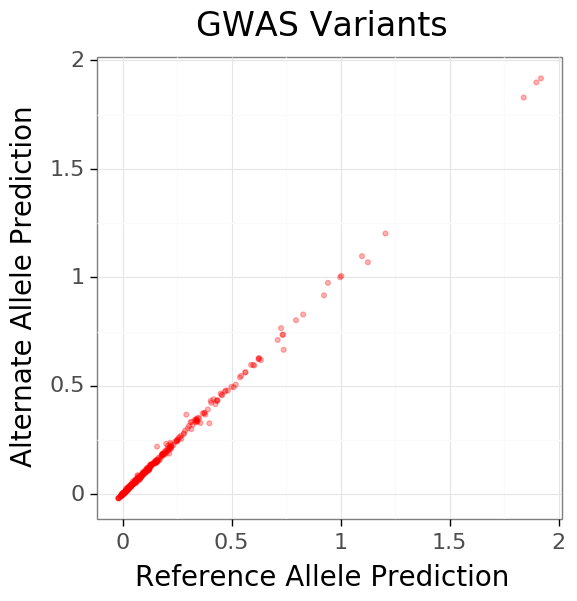

<ggplot: (-9223363250152681556)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
174,chr17,43909690,43909691,rs116060954,A,G,9.040240e-01,-0.021208,0.176350,Y,0.738086,0.665615,-0.072471
262,chr17,44024562,44024563,rs62062785,G,T,3.333700e-22,-0.227320,0.023921,Y,0.397430,0.326880,-0.070550
2,chr17,43394569,43394570,rs115344032,C,G,1.227880e-03,0.301428,0.089844,Y,1.124592,1.069286,-0.055305
390,chr17,44200015,44200016,rs62061856,C,T,2.687150e-22,0.227719,0.023911,Y,0.356327,0.328127,-0.028200
250,chr17,44014137,44014138,rs12150460,G,T,4.038280e-22,-0.226906,0.023926,Y,0.213622,0.187241,-0.026381
0,chr17,43394063,43394064,rs149462394,A,C,1.230650e-03,-0.301259,0.089811,Y,0.509387,0.493145,-0.016242
196,chr17,43938796,43938797,rs55646970,A,G,3.325480e-22,-0.227446,0.023934,Y,0.633908,0.618392,-0.015516
161,chr17,43906828,43906829,rs17689882,A,G,1.342250e-22,0.229399,0.023918,Y,0.314504,0.299963,-0.014541
111,chr17,43791584,43791585,rs1608954,A,G,4.283540e-01,-0.493689,0.661817,Y,0.268835,0.255403,-0.013432
263,chr17,44024660,44024661,rs62062786,C,G,4.529580e-22,0.226334,0.023892,Y,0.518617,0.505411,-0.013206


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
27,chr17,43546057,43546058,rs62065399,G,T,1.641740e-21,-0.241974,0.025985,Y,0.218202,0.237577,0.019375
64,chr17,43767628,43767629,rs62055752,A,G,2.688420e-22,0.228087,0.023950,Y,0.311010,0.330907,0.019897
76,chr17,43778752,43778753,rs62056876,C,T,3.247470e-22,-0.227538,0.023938,Y,0.067692,0.087670,0.019978
89,chr17,43784994,43784995,rs62056913,C,T,2.273570e-22,-0.228491,0.023952,Y,0.417068,0.438006,0.020939
210,chr17,43983801,43983802,rs62056806,A,G,3.939880e-22,-0.226704,0.023898,Y,0.404029,0.430631,0.026602
389,chr17,44199670,44199671,rs62061855,A,G,7.115390e-22,0.225965,0.023969,Y,0.199284,0.232336,0.033052
198,chr17,43938997,43938998,rs734629,A,C,7.653870e-01,0.144327,0.475459,Y,0.941123,0.974248,0.033125
20,chr17,43483774,43483775,rs1230101,A,G,1.069460e-02,-0.051516,0.020132,Y,0.726216,0.765662,0.039446
338,chr17,44121917,44121918,rs77768866,C,T,2.510300e-22,-0.227852,0.023909,Y,0.157499,0.219270,0.061771
261,chr17,44024552,44024553,rs62062784,C,G,3.332810e-22,-0.227322,0.023922,Y,0.291496,0.366736,0.075239


SNPs NOT in Peaks:


(4749, 12)

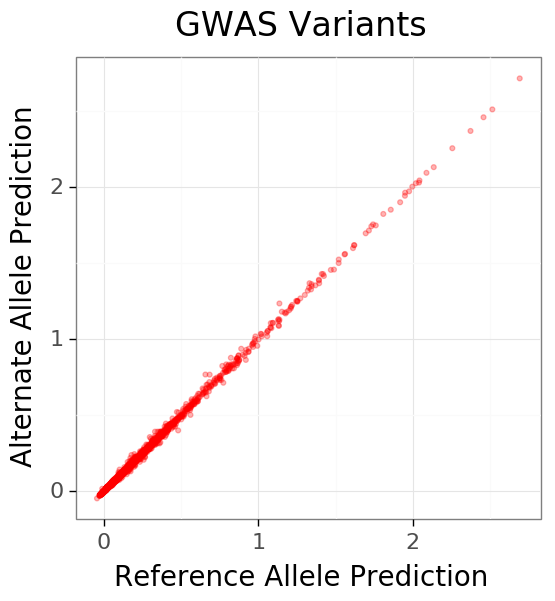

<ggplot: (8786828092799)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
251,chr17,43508303,43508304,rs34018943,A,G,4.345530e-21,-0.238910,0.025929,Y,0.480912,0.401414,-0.079498
1024,chr17,43783370,43783371,rs6503444,C,T,7.243710e-01,-0.012226,0.034624,Y,0.773244,0.714608,-0.058636
1968,chr17,43930262,43930263,rs183338496,C,G,1.146550e-01,-0.359248,0.218883,Y,0.560708,0.503381,-0.057326
4079,chr17,44249838,44249839,rs9911018,C,T,3.050030e-01,0.129542,0.124182,Y,0.919044,0.864726,-0.054317
1147,chr17,43799810,43799811,rs76667867,C,G,3.947480e-22,0.227029,0.023934,Y,0.257934,0.208334,-0.049600
1356,chr17,43829404,43829405,rs1880755,C,T,1.418830e-08,0.107805,0.019046,Y,1.133288,1.088189,-0.045099
1307,chr17,43823084,43823085,rs8071902,A,G,6.604970e-01,-0.140157,0.313098,Y,0.360392,0.315732,-0.044660
2798,chr17,44051513,44051514,rs112165071,A,G,9.574640e-01,0.016743,0.316662,Y,0.365686,0.323037,-0.042648
272,chr17,43514954,43514955,rs62064655,A,G,3.846580e-21,0.239334,0.025940,Y,0.266978,0.225129,-0.041849
1297,chr17,43821478,43821479,rs8082105,A,G,3.243470e-02,-0.050907,0.023700,Y,0.173268,0.132271,-0.040997


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
2313,chr17,43973652,43973653,rs62056780,C,T,3.938360e-22,-0.226705,0.023898,Y,0.889034,0.938016,0.048981
2676,chr17,44031596,44031597,rs878918,A,G,1.638560e-05,0.086030,0.019890,Y,0.472700,0.522434,0.049733
2083,chr17,43945100,43945101,rs11869096,A,G,2.069490e-03,-0.057993,0.018814,Y,0.822121,0.878636,0.056515
2084,chr17,43945106,43945107,rs62055475,C,T,3.880030e-22,0.226886,0.023913,Y,0.766656,0.825193,0.058537
1529,chr17,43853072,43853073,rs35152905,G,T,3.004800e-02,-0.055595,0.025500,Y,0.297303,0.357634,0.060331
3809,chr17,44208144,44208145,rs17661428,C,G,4.018590e-22,-0.227792,0.024019,Y,0.178671,0.239764,0.061093
3104,chr17,44094667,44094668,rs2316948,C,G,2.222920e-22,-0.228177,0.023913,Y,0.331072,0.393265,0.062193
1212,chr17,43810608,43810609,rs62054394,A,T,2.953920e-22,0.227674,0.023930,Y,0.684860,0.767847,0.082987
2323,chr17,43974889,43974890,rs62056784,C,G,3.938970e-22,-0.226704,0.023898,Y,1.136244,1.235697,0.099453
2299,chr17,43971785,43971786,rs11575895,A,G,3.939740e-22,-0.226704,0.023898,Y,0.657250,0.768721,0.111470


FOLD:  8
All SNPs:


(4093, 12)

SNPs in Peaks:


(136, 12)

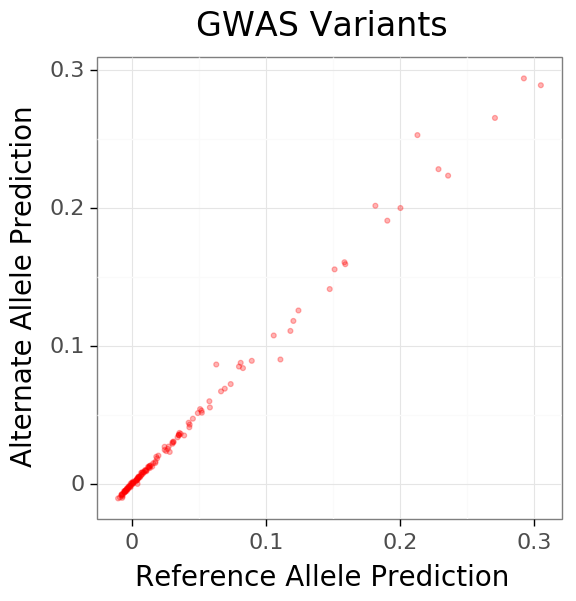

<ggplot: (8786677252307)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
60,chr12,41312147,41312148,rs1372543,A,G,0.509090,-0.031469,0.047479,Y,0.110770,0.090394,-0.020376
88,chr12,41459242,41459243,rs181012052,C,T,0.683461,0.066059,0.160853,Y,0.304854,0.289218,-0.015636
74,chr12,41407403,41407404,rs278899,A,G,0.005572,0.061770,0.022185,Y,0.235736,0.223660,-0.012076
130,chr12,123268884,123268885,rs75875275,A,G,0.106533,0.065856,0.040486,Y,0.118213,0.111094,-0.007119
119,chr12,42300681,42300682,rs17576430,C,T,0.430900,-0.146159,0.182091,Y,0.147516,0.141448,-0.006068
59,chr12,41311737,41311738,rs73126511,C,T,0.888058,-0.010252,0.072930,Y,0.270648,0.265506,-0.005143
58,chr12,41311589,41311590,rs10784949,A,G,0.319568,0.019300,0.019403,Y,0.028281,0.023356,-0.004924
103,chr12,41477220,41477221,rs185511401,C,T,0.387408,-0.111650,0.130896,Y,0.004297,0.000188,-0.004109
9,chr12,34123490,34123491,rs142024504,A,G,0.937564,-0.018390,0.232488,Y,0.039034,0.035314,-0.003720
84,chr12,41438385,41438386,rs10879578,G,T,0.041140,-0.062255,0.030289,Y,-0.007096,-0.009904,-0.002808


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
128,chr12,123268777,123268778,rs1696355,A,T,1.869780e-01,0.050976,0.038865,Y,0.049232,0.051523,0.002292
56,chr12,41311418,41311419,rs10506179,C,T,3.187960e-01,0.019336,0.019409,Y,0.158507,0.160897,0.002390
53,chr12,41311120,41311121,rs56294359,C,T,3.036750e-01,-0.019400,0.018857,Y,0.024465,0.027097,0.002633
48,chr12,40921830,40921831,rs150842995,A,G,2.562610e-01,-0.749163,0.732634,Y,0.050910,0.054416,0.003506
75,chr12,41408134,41408135,rs397967,A,G,2.227530e-09,-0.333909,0.053696,Y,0.151154,0.155725,0.004570
78,chr12,41408811,41408812,rs278900,A,T,5.234740e-06,0.186955,0.040175,Y,0.079899,0.085245,0.005346
117,chr12,42300417,42300418,rs74658662,G,T,4.308650e-01,0.146171,0.182091,Y,0.081161,0.087971,0.006810
122,chr12,123238416,123238417,rs79350782,G,T,1.216290e-01,0.064001,0.041032,Y,0.181541,0.201833,0.020292
54,chr12,41311339,41311340,rs187801857,A,T,5.163180e-01,-0.192545,0.304514,Y,0.062967,0.086760,0.023793
77,chr12,41408740,41408741,rs35862989,A,T,4.578600e-02,-0.086695,0.043869,Y,0.212883,0.253064,0.040181


SNPs NOT in Peaks:


(3957, 12)

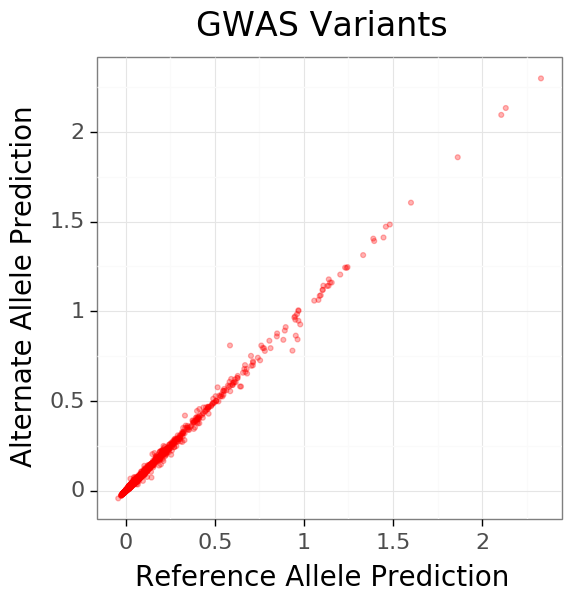

<ggplot: (8786677330552)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
3925,chr12,123337761,123337762,rs12298151,A,G,6.186260e-01,-0.019407,0.038896,Y,0.935479,0.780633,-0.154846
1629,chr12,40413305,40413306,rs28370664,A,C,1.753300e-20,-0.502667,0.051311,Y,0.964243,0.843413,-0.120830
2298,chr12,40894172,40894173,rs17597637,G,T,3.290310e-01,-0.025448,0.026134,Y,0.954108,0.864381,-0.089728
3770,chr12,123303945,123303946,rs1798569,A,C,8.556560e-01,-0.011185,0.061397,Y,0.143751,0.073227,-0.070524
3948,chr12,123342229,123342230,rs1587856,A,G,6.940980e-01,0.011758,0.029932,Y,0.646789,0.580724,-0.066065
3881,chr12,123326326,123326327,rs897392,A,G,5.222260e-01,-0.017940,0.028083,Y,0.641183,0.580929,-0.060254
1908,chr12,40732123,40732124,rs4767972,C,T,1.455140e-01,-0.038195,0.026148,Y,0.254381,0.200529,-0.053852
3208,chr12,41462234,41462235,rs166806,C,T,7.904560e-02,0.050942,0.028856,Y,0.979050,0.927005,-0.052046
3402,chr12,42149726,42149727,rs118167883,C,T,8.941480e-01,0.013411,0.100626,Y,0.196826,0.145989,-0.050837
62,chr12,33200884,33200885,rs10844438,G,T,2.493900e-02,0.042965,0.019146,Y,0.329482,0.281835,-0.047647


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
1708,chr12,40438429,40438430,rs10878031,A,T,0.130339,-0.028517,0.018842,Y,0.025451,0.067075,0.041624
3048,chr12,41401999,41402000,rs10879518,C,G,0.075285,0.049666,0.027785,Y,0.412418,0.455079,0.042661
1940,chr12,40737075,40737076,rs17461964,C,T,0.145592,-0.038182,0.026144,Y,0.399728,0.444286,0.044558
3859,chr12,123320874,123320875,rs79355888,C,T,0.775812,0.105058,0.363941,Y,0.760579,0.809223,0.048644
1579,chr12,40397235,40397236,rs28370644,C,T,0.063192,0.052799,0.028573,Y,0.702586,0.751713,0.049127
3567,chr12,43054197,43054198,rs188012290,A,G,0.949234,-0.007650,0.120559,Y,0.160402,0.210014,0.049612
3584,chr12,123225533,123225534,rs139695358,C,T,0.556668,0.165595,0.275913,Y,0.148929,0.203854,0.054925
2182,chr12,40840033,40840034,rs1346309,C,G,0.072099,0.033944,0.018883,Y,0.515390,0.576284,0.060894
1068,chr12,34417692,34417693,rs12824730,C,T,0.288800,0.039501,0.037388,Y,0.331826,0.418807,0.086981
1941,chr12,40737115,40737116,rs10784518,G,T,0.145578,-0.038183,0.026144,Y,0.584631,0.809750,0.225119


FOLD:  9
All SNPs:


(323, 12)

SNPs in Peaks:


(43, 12)

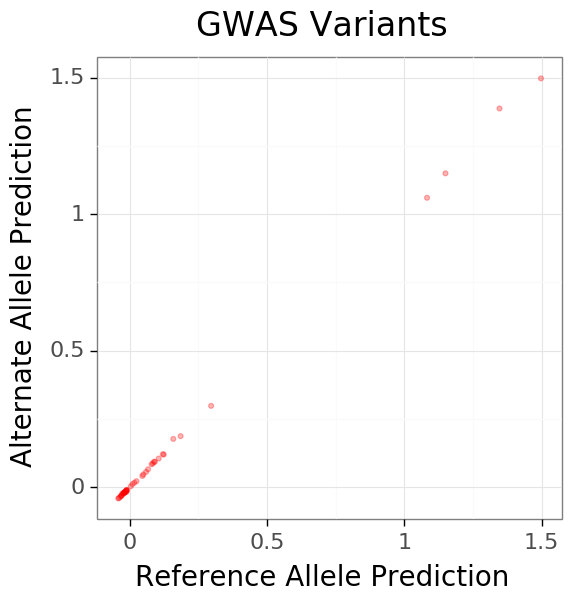

<ggplot: (8786702027128)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
9,chr10,121368348,121368349,rs115879160,G,T,8.644330e-01,-0.026199,0.153915,Y,1.082559,1.060187,-0.022372
28,chr10,121532890,121532891,rs144030311,A,G,9.665760e-01,0.008238,0.197415,Y,-0.012074,-0.017695,-0.005621
21,chr10,121458850,121458851,rs117953397,C,G,9.221510e-02,-0.063552,0.037469,Y,0.045933,0.041373,-0.004560
17,chr10,121369051,121369052,rs7075463,A,C,7.305470e-01,0.007336,0.021312,Y,0.124028,0.119658,-0.004370
34,chr10,121536635,121536636,rs72826422,C,G,6.396350e-02,-0.071163,0.038100,Y,0.059348,0.056321,-0.003027
3,chr10,121292329,121292330,rs185953720,G,T,9.753270e-01,-0.004413,0.143041,Y,0.049378,0.046814,-0.002564
22,chr10,121458911,121458912,rs192486997,C,T,2.886300e-01,-0.151916,0.146046,Y,0.024601,0.022321,-0.002280
6,chr10,121292936,121292937,rs79210761,C,T,9.462420e-01,-0.004115,0.060907,Y,-0.034838,-0.035807,-0.000969
15,chr10,121368873,121368874,rs145701507,C,T,5.835250e-01,-0.159246,0.296942,Y,0.066825,0.065866,-0.000958
32,chr10,121536327,121536328,rs117896735,A,G,1.754070e-09,-0.449792,0.071012,Y,-0.016993,-0.017728,-0.000735


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
13,chr10,121368582,121368583,rs142590307,C,T,0.875046,0.034921,0.222869,Y,0.091692,0.093240,0.001548
2,chr10,121292123,121292124,rs10787976,A,G,0.277104,0.036571,0.033790,Y,0.009954,0.011566,0.001612
8,chr10,121368169,121368170,rs11199044,A,C,0.739901,0.013698,0.041330,Y,0.296356,0.298158,0.001802
40,chr10,121710444,121710445,rs2420792,A,G,0.651818,0.009404,0.020851,Y,0.185228,0.187220,0.001993
37,chr10,121663221,121663222,rs188110292,A,G,0.132260,0.487241,0.307452,Y,0.084018,0.087330,0.003311
27,chr10,121532886,121532887,rs61867903,G,T,0.310642,-0.044365,0.043523,Y,-0.026893,-0.022242,0.004651
18,chr10,121369103,121369104,rs138715304,G,T,0.306950,-0.070275,0.069407,Y,0.079524,0.084192,0.004668
16,chr10,121369014,121369015,rs12416614,C,T,0.848030,-0.032586,0.170783,Y,0.088441,0.093406,0.004965
14,chr10,121368847,121368848,rs7075175,C,G,0.734674,-0.007222,0.021319,Y,0.158656,0.177184,0.018528
12,chr10,121368477,121368478,rs11199045,C,G,0.170513,0.030679,0.022435,Y,1.346423,1.387199,0.040776


SNPs NOT in Peaks:


(280, 12)

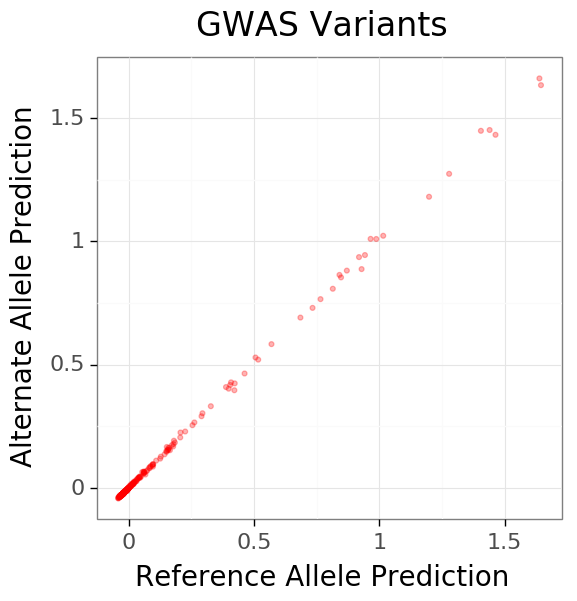

<ggplot: (8786677298717)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
116,chr10,121410904,121410905,rs192502283,C,G,0.079809,-0.183773,0.102930,Y,0.929354,0.887104,-0.042251
82,chr10,121376917,121376918,rs11199049,A,G,0.145982,-0.030658,0.021127,Y,1.463861,1.431574,-0.032287
160,chr10,121464050,121464051,rs17099211,C,G,0.068557,-0.069240,0.037712,Y,0.421588,0.395964,-0.025624
197,chr10,121655932,121655933,rs7084324,C,G,0.000031,0.117998,0.028010,Y,1.198567,1.180350,-0.018217
120,chr10,121411861,121411862,rs196335,C,T,0.767136,0.009306,0.031394,Y,1.645306,1.632846,-0.012460
219,chr10,121659957,121659958,rs71482901,A,G,0.510371,-0.027022,0.040917,Y,0.066337,0.054246,-0.012090
64,chr10,121373474,121373475,rs11199046,C,G,0.502958,0.013896,0.020730,Y,0.164410,0.152846,-0.011564
208,chr10,121658842,121658843,rs12257358,A,C,0.000735,0.077735,0.023169,Y,0.096449,0.086340,-0.010108
63,chr10,121373469,121373470,rs75952843,C,G,0.283884,0.073726,0.069449,Y,0.177238,0.167967,-0.009271
128,chr10,121414598,121414599,rs12250770,C,T,0.002635,-0.065469,0.021867,Y,0.814423,0.807388,-0.007035


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
11,chr10,121296385,121296386,rs2277267,A,G,0.818605,-0.036102,0.158173,Y,0.919091,0.935760,0.016669
264,chr10,121712667,121712668,rs12775642,A,G,0.155717,-0.029580,0.020811,Y,0.206434,0.224658,0.018224
133,chr10,121415685,121415686,rs72840788,A,G,0.000068,-0.090207,0.022506,Y,0.408366,0.428009,0.019643
25,chr10,121298567,121298568,rs76021313,C,T,0.596301,-0.062890,0.117769,Y,0.388215,0.408854,0.020639
198,chr10,121656067,121656068,rs35225459,A,G,0.506163,-0.027262,0.040872,Y,1.639045,1.660244,0.021199
84,chr10,121377046,121377047,rs11199050,C,T,0.429689,-0.016900,0.021376,Y,0.987876,1.009165,0.021289
126,chr10,121414205,121414206,rs148789629,C,T,0.023714,-0.361682,0.152992,Y,0.841013,0.863538,0.022526
127,chr10,121414236,121414237,rs196336,C,T,0.804786,-0.004853,0.019640,Y,0.505865,0.528713,0.022848
121,chr10,121412132,121412133,rs55725412,A,G,0.138118,-0.030363,0.020508,Y,1.405548,1.447727,0.042179
118,chr10,121411631,121411632,rs112168846,A,G,0.416034,0.041580,0.051391,Y,0.965275,1.009664,0.044389


In [8]:
get_results_all_folds('PD_CTRL_MDTG')

TASK:  PD_GBA1_MDTG
FOLD:  0
All SNPs:


(446, 12)

SNPs in Peaks:


(38, 12)

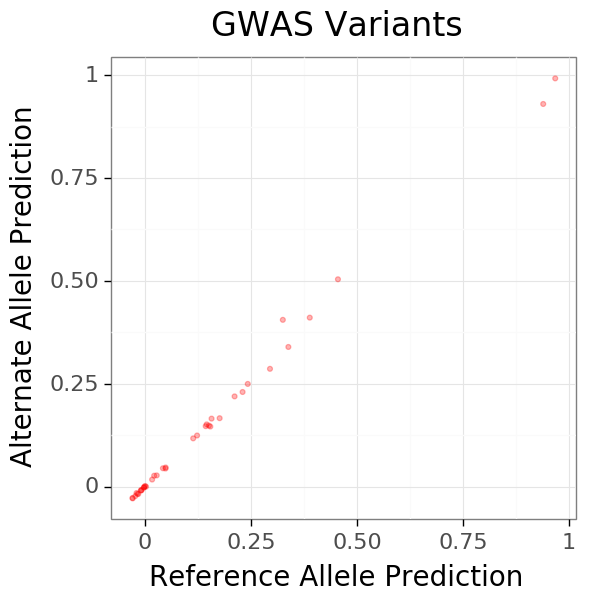

<ggplot: (8785709754681)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
6,chr1,155135335,155135336,rs4460629,C,T,9.149490e-01,0.002004,0.018767,Y,0.176435,0.166383,-0.010052
35,chr1,205670871,205670872,rs12751694,A,G,7.916090e-01,0.051321,0.195357,Y,0.939051,0.930056,-0.008995
1,chr1,154983930,154983931,rs77982133,C,T,4.117510e-01,0.038985,0.047293,Y,0.295096,0.286362,-0.008734
13,chr1,155207549,155207550,rs762488,C,T,6.654640e-01,0.008818,0.020404,Y,0.154508,0.146094,-0.008414
18,chr1,155208006,155208007,rs364897,C,T,2.004270e-01,-1.170800,0.809268,Y,0.048833,0.044003,-0.004830
36,chr1,205671001,205671002,rs116664067,A,T,5.785580e-01,0.050852,0.092143,Y,0.151272,0.148269,-0.003003
22,chr1,155821440,155821441,rs13376121,C,G,5.248140e-01,-0.027811,0.043584,Y,0.002989,0.000007,-0.002983
5,chr1,155135036,155135037,rs35749011,A,G,5.326700e-14,-0.536007,0.066947,Y,0.049223,0.046568,-0.002656
24,chr1,155821773,155821774,rs4971064,C,T,5.157930e-01,-0.028345,0.043468,Y,-0.015335,-0.017847,-0.002512
29,chr1,155822721,155822722,rs822489,C,T,8.747710e-01,0.006706,0.042514,Y,0.028144,0.027338,-0.000806


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
32,chr1,205669322,205669323,rs823099,A,C,0.070324,-0.034245,0.018910,Y,-0.019440,-0.015460,0.003980
17,chr1,155207985,155207986,rs74462743,C,T,0.144436,2.080070,1.183400,Y,0.022094,0.026612,0.004518
26,chr1,155822529,155822530,rs13376235,A,G,0.521447,-0.028032,0.043575,Y,0.145893,0.151328,0.005435
14,chr1,155207626,155207627,rs2009578,A,G,0.882222,0.003030,0.020456,Y,0.242682,0.249655,0.006973
19,chr1,155208361,155208362,rs147138516,C,G,0.014743,1.417620,0.495539,Y,0.211671,0.219376,0.007705
37,chr1,205671167,205671168,rs1417725,A,G,0.022548,0.114527,0.050882,Y,0.157381,0.165316,0.007935
9,chr1,155140023,155140024,rs114413971,A,C,0.326770,0.045034,0.046174,Y,0.388850,0.410764,0.021914
34,chr1,205670726,205670727,rs823098,A,G,0.114962,0.079276,0.050799,Y,0.967355,0.992237,0.024882
10,chr1,155140027,155140028,rs12131522,C,T,0.958053,0.000990,0.018828,Y,0.455269,0.503999,0.048731
33,chr1,205670369,205670370,rs6673687,A,T,0.000008,-0.086770,0.019520,Y,0.325362,0.405407,0.080045


SNPs NOT in Peaks:


(408, 12)

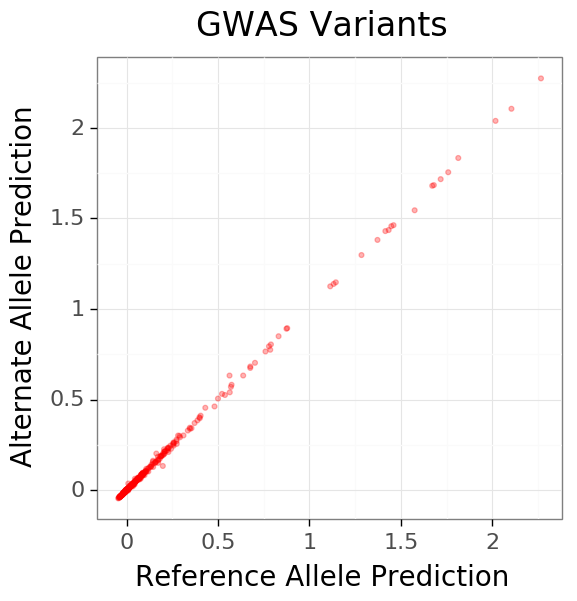

<ggplot: (8785708238372)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
11,chr1,154911651,154911652,rs4845694,C,G,7.796100e-01,0.005313,0.018987,Y,0.197832,0.133430,-0.064402
316,chr1,205718858,205718859,rs7536483,A,T,4.290230e-02,0.038184,0.018846,Y,1.575073,1.545196,-0.029877
57,chr1,154989595,154989596,rs6673081,C,T,8.020330e-01,-0.004747,0.018935,Y,0.564063,0.540104,-0.023960
157,chr1,155205378,155205379,rs12752133,C,T,1.240970e-13,0.553975,0.070121,Y,0.172268,0.150629,-0.021639
37,chr1,154916380,154916381,rs190798318,C,T,3.521610e-01,-0.239792,0.264808,Y,0.480569,0.462070,-0.018500
338,chr1,205724050,205724051,rs823120,C,T,8.704600e-02,0.085802,0.050692,Y,0.274089,0.255658,-0.018431
89,chr1,155115260,155115261,rs4246529,C,T,9.256370e-02,0.032142,0.019125,Y,0.228886,0.210730,-0.018156
311,chr1,205717823,205717824,rs4951261,A,C,2.659710e-06,-0.091003,0.019448,Y,0.145016,0.127948,-0.017068
220,chr1,155392868,155392869,rs113597615,C,T,7.898990e-02,0.199254,0.115714,Y,0.118646,0.103012,-0.015635
283,chr1,205673916,205673917,rs151258054,C,T,4.970860e-01,-0.070105,0.104191,Y,0.098030,0.082926,-0.015104


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
403,chr1,205743425,205743426,rs823143,A,C,3.079780e-02,0.040657,0.018812,Y,0.144153,0.162505,0.018352
40,chr1,154916602,154916603,rs9236,A,C,8.905540e-01,-0.062807,0.456061,Y,0.830980,0.849765,0.018785
36,chr1,154916106,154916107,rs2335409,A,G,8.668470e-01,0.003227,0.019247,Y,0.281417,0.301466,0.020049
78,chr1,155108167,155108168,rs12726330,A,G,1.639030e-14,-0.543259,0.066430,Y,1.813574,1.833830,0.020256
404,chr1,205743502,205743503,rs11803735,A,G,4.161370e-01,0.082596,0.102687,Y,0.204586,0.225882,0.021296
319,chr1,205719191,205719192,rs111265946,A,C,8.706610e-02,0.067528,0.039786,Y,2.017429,2.038828,0.021399
93,chr1,155118588,155118589,rs147847496,C,T,8.405170e-01,0.012015,0.059622,Y,0.430207,0.454754,0.024546
223,chr1,155412037,155412038,rs11264371,C,T,5.781780e-01,0.012187,0.021899,Y,0.008943,0.036548,0.027604
286,chr1,205674897,205674898,rs111299170,C,T,3.293230e-01,-0.034498,0.035505,Y,0.162362,0.202007,0.039645
0,chr1,154909169,154909170,rs17356361,C,T,2.767880e-01,0.055702,0.050864,Y,0.562663,0.632647,0.069985


FOLD:  1
All SNPs:


(313, 12)

SNPs in Peaks:


(9, 12)

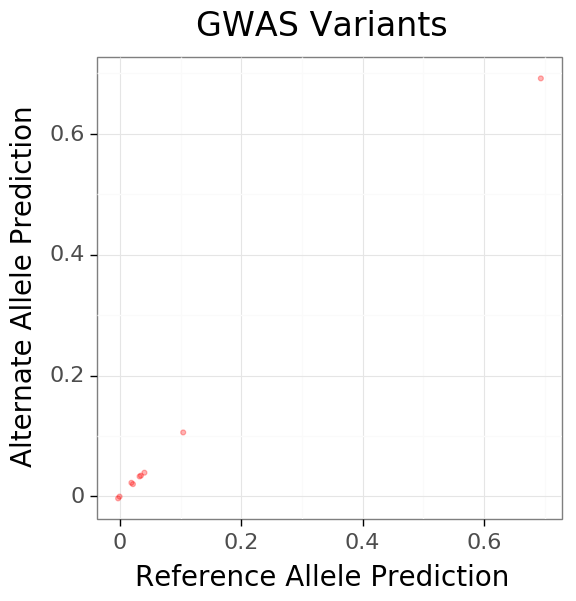

<ggplot: (-9223363251141034415)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
0,chr2,169109956,169109957,rs13002388,A,G,6.338120e-01,-0.012918,0.027152,Y,0.693752,0.691850,-0.001902
1,chr2,169110394,169110395,rs1474055,C,T,1.112500e-11,0.184632,0.026727,Y,0.040494,0.039126,-0.001368
5,chr2,169131135,169131136,rs183501421,C,T,3.234590e-01,-0.195448,0.202374,Y,0.021547,0.020185,-0.001362
7,chr2,169132611,169132612,rs77548116,C,T,7.952470e-01,0.012166,0.046951,Y,-0.002853,-0.003390,-0.000538
2,chr2,169110422,169110423,rs147610000,C,T,5.147330e-02,-0.088236,0.045731,Y,0.034679,0.034272,-0.000407
8,chr2,169132643,169132644,rs67058614,D,I,3.756770e-01,0.024522,0.027746,Y,-0.000468,-0.000468,0.000000
4,chr2,169110621,169110622,rs12622375,A,G,2.420800e-03,-0.057436,0.018949,Y,0.032513,0.032962,0.000449
3,chr2,169110500,169110501,rs12474289,A,G,7.941460e-01,0.128192,0.499616,Y,0.104389,0.105784,0.001395
6,chr2,169131721,169131722,rs955896,A,T,3.743930e-01,0.024463,0.027606,Y,0.019046,0.022427,0.003381


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
0,chr2,169109956,169109957,rs13002388,A,G,6.338120e-01,-0.012918,0.027152,Y,0.693752,0.691850,-0.001902
1,chr2,169110394,169110395,rs1474055,C,T,1.112500e-11,0.184632,0.026727,Y,0.040494,0.039126,-0.001368
5,chr2,169131135,169131136,rs183501421,C,T,3.234590e-01,-0.195448,0.202374,Y,0.021547,0.020185,-0.001362
7,chr2,169132611,169132612,rs77548116,C,T,7.952470e-01,0.012166,0.046951,Y,-0.002853,-0.003390,-0.000538
2,chr2,169110422,169110423,rs147610000,C,T,5.147330e-02,-0.088236,0.045731,Y,0.034679,0.034272,-0.000407
8,chr2,169132643,169132644,rs67058614,D,I,3.756770e-01,0.024522,0.027746,Y,-0.000468,-0.000468,0.000000
4,chr2,169110621,169110622,rs12622375,A,G,2.420800e-03,-0.057436,0.018949,Y,0.032513,0.032962,0.000449
3,chr2,169110500,169110501,rs12474289,A,G,7.941460e-01,0.128192,0.499616,Y,0.104389,0.105784,0.001395
6,chr2,169131721,169131722,rs955896,A,T,3.743930e-01,0.024463,0.027606,Y,0.019046,0.022427,0.003381


SNPs NOT in Peaks:


(304, 12)

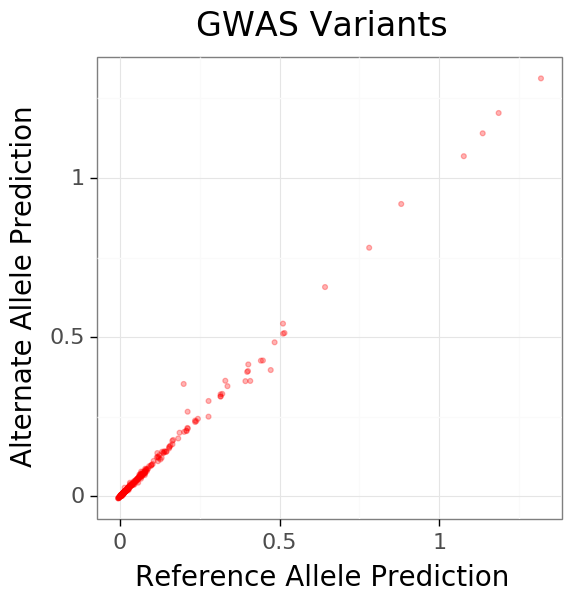

<ggplot: (-9223363251146537924)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
10,chr2,169088313,169088314,rs116239781,A,G,0.536545,0.025167,0.040612,Y,0.472077,0.396868,-0.075209
203,chr2,169147533,169147534,rs2138754,C,T,0.048906,-0.036881,0.018724,Y,0.407953,0.362649,-0.045304
2,chr2,169087232,169087233,rs16855155,A,G,0.491543,-0.117109,0.167852,Y,0.392795,0.362026,-0.030769
86,chr2,169106699,169106700,rs74271810,C,G,0.994382,-0.000962,0.136617,Y,0.277142,0.250501,-0.026641
296,chr2,169168731,169168732,rs75572897,C,T,0.909009,0.015731,0.137376,Y,0.447625,0.426862,-0.020763
221,chr2,169150945,169150946,rs2203704,C,T,0.044228,-0.037655,0.018713,Y,0.441336,0.426303,-0.015033
249,chr2,169155460,169155461,rs13432275,A,C,0.007537,0.053040,0.019896,Y,0.056617,0.043423,-0.013195
23,chr2,169090336,169090337,rs138015412,C,G,0.355969,-0.254197,0.266511,Y,0.126610,0.116351,-0.010259
226,chr2,169151572,169151573,rs10930319,C,G,0.043268,-0.037820,0.018710,Y,0.077565,0.067312,-0.010253
192,chr2,169143262,169143263,rs73971596,A,C,0.600123,0.017872,0.034161,Y,0.065395,0.055801,-0.009594


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
169,chr2,169136489,169136490,rs1400637,A,C,0.000002,-0.099235,0.020889,Y,0.186389,0.200178,0.013789
182,chr2,169140909,169140910,rs4458184,A,C,0.564476,0.016130,0.028039,Y,0.642362,0.657309,0.014947
11,chr2,169088635,169088636,rs10177444,A,G,0.001815,0.059667,0.019138,Y,1.186542,1.203602,0.017060
303,chr2,169171245,169171246,rs58843270,A,G,0.000206,-0.146987,0.038954,Y,0.116663,0.136302,0.019639
298,chr2,169169589,169169590,rs115802045,C,T,0.916351,0.016400,0.157416,Y,0.277286,0.299724,0.022439
268,chr2,169158403,169158404,rs1517340,A,G,0.013007,-0.046962,0.018924,Y,0.510565,0.542476,0.031912
180,chr2,169140481,169140482,rs67033359,C,G,0.587779,0.014912,0.027550,Y,0.329788,0.363187,0.033399
77,chr2,169103143,169103144,rs73013478,C,T,0.632657,-0.015436,0.032347,Y,0.881165,0.918031,0.036865
201,chr2,169147029,169147030,rs78166116,A,G,0.348521,-0.206268,0.215022,Y,0.211668,0.266110,0.054442
181,chr2,169140638,169140639,rs6741911,A,C,0.609587,-0.014043,0.027537,Y,0.199282,0.353132,0.153850


FOLD:  2
All SNPs:


(212, 12)

SNPs in Peaks:


(12, 12)

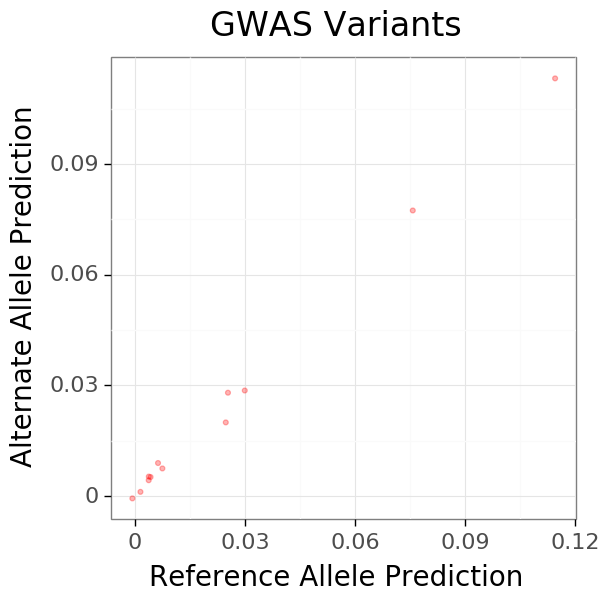

<ggplot: (-9223363251148013603)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
1,chr3,182710680,182710681,rs4859261,C,T,4.221840e-08,0.111944,0.020551,Y,0.024793,0.019974,-0.004819
8,chr3,182739836,182739837,rs77458140,G,T,7.987470e-01,-0.014804,0.058171,Y,0.114606,0.113211,-0.001395
7,chr3,182739778,182739779,rs182753925,C,T,9.171920e-02,-0.295525,0.181985,Y,0.029970,0.028617,-0.001353
4,chr3,182713941,182713942,rs74902465,A,G,4.302800e-08,-0.112069,0.020585,Y,0.001517,0.001152,-0.000364
10,chr3,182740762,182740763,rs146449896,D,I,9.030890e-02,-0.427681,0.267704,Y,0.007500,0.007500,0.000000
3,chr3,182711005,182711006,rs144166036,G,T,3.460340e-01,-0.428322,0.478385,Y,-0.000684,-0.000617,0.000067
2,chr3,182710940,182710941,rs78126209,A,G,8.569130e-01,0.010954,0.060833,Y,0.003768,0.004303,0.000535
11,chr3,182740801,182740802,rs73883999,C,T,9.454170e-02,0.421845,0.267292,Y,0.004280,0.005170,0.000890
5,chr3,182714378,182714379,rs186753914,A,G,3.377360e-01,-0.142495,0.146379,Y,0.003797,0.005292,0.001496
9,chr3,182739950,182739951,rs73883998,C,T,8.534280e-02,0.433547,0.267406,Y,0.075793,0.077412,0.001618


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
7,chr3,182739778,182739779,rs182753925,C,T,9.171920e-02,-0.295525,0.181985,Y,0.029970,0.028617,-0.001353
4,chr3,182713941,182713942,rs74902465,A,G,4.302800e-08,-0.112069,0.020585,Y,0.001517,0.001152,-0.000364
10,chr3,182740762,182740763,rs146449896,D,I,9.030890e-02,-0.427681,0.267704,Y,0.007500,0.007500,0.000000
3,chr3,182711005,182711006,rs144166036,G,T,3.460340e-01,-0.428322,0.478385,Y,-0.000684,-0.000617,0.000067
2,chr3,182710940,182710941,rs78126209,A,G,8.569130e-01,0.010954,0.060833,Y,0.003768,0.004303,0.000535
11,chr3,182740801,182740802,rs73883999,C,T,9.454170e-02,0.421845,0.267292,Y,0.004280,0.005170,0.000890
5,chr3,182714378,182714379,rs186753914,A,G,3.377360e-01,-0.142495,0.146379,Y,0.003797,0.005292,0.001496
9,chr3,182739950,182739951,rs73883998,C,T,8.534280e-02,0.433547,0.267406,Y,0.075793,0.077412,0.001618
6,chr3,182739738,182739739,rs11928508,C,G,4.694950e-08,0.113244,0.020874,Y,0.025386,0.028022,0.002636
0,chr3,182710489,182710490,rs147515099,A,G,5.579360e-01,-0.044117,0.074948,Y,0.006312,0.008968,0.002656


SNPs NOT in Peaks:


(200, 12)

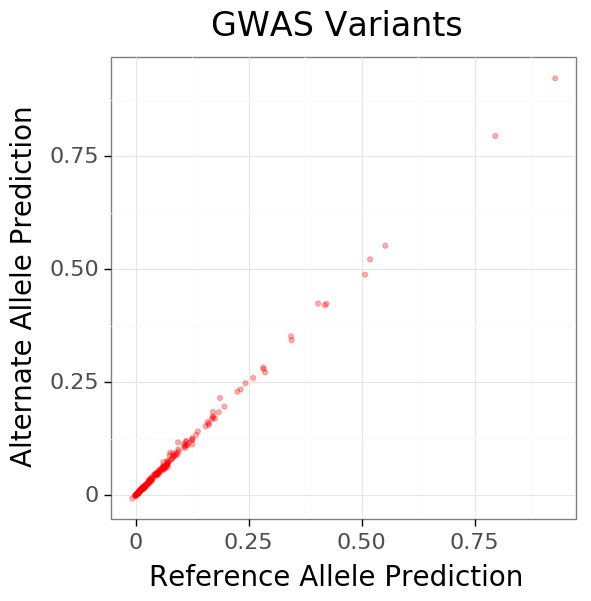

<ggplot: (-9223363251148052522)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
70,chr3,182729596,182729597,rs59889069,C,T,6.407380e-01,-0.016834,0.036003,Y,0.507336,0.488293,-0.019043
67,chr3,182729141,182729142,rs116438848,A,G,4.600150e-01,0.061375,0.083598,Y,0.286493,0.272276,-0.014217
129,chr3,182748495,182748496,rs10937108,A,T,4.053010e-10,-0.150923,0.024465,Y,0.125775,0.113125,-0.012650
192,chr3,182764954,182764955,rs28793315,C,T,1.071090e-06,0.135823,0.028233,Y,0.071318,0.062744,-0.008574
54,chr3,182725563,182725564,rs76291226,A,G,1.931550e-04,0.153489,0.041932,Y,0.063208,0.057274,-0.005934
62,chr3,182728181,182728182,rs4074310,G,T,1.454780e-11,0.162319,0.024386,Y,0.927805,0.922325,-0.005480
116,chr3,182743267,182743268,rs7640612,A,C,4.892030e-08,-0.112918,0.020842,Y,0.161336,0.155952,-0.005384
31,chr3,182718334,182718335,rs189240771,A,G,9.633470e-01,0.023232,0.536104,Y,0.175513,0.170148,-0.005364
159,chr3,182755209,182755210,rs2270968,G,T,4.525560e-08,-0.116779,0.021523,Y,0.065244,0.060305,-0.004940
42,chr3,182721731,182721732,rs10470519,A,C,7.575610e-01,0.011157,0.036098,Y,0.035870,0.031202,-0.004669


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
49,chr3,182724406,182724407,rs6791884,A,G,6.003890e-09,-0.119866,0.020751,Y,0.112722,0.120790,0.008068
190,chr3,182763580,182763581,rs1502762,A,G,6.601880e-05,-0.092512,0.023362,Y,0.343606,0.351820,0.008214
47,chr3,182723736,182723737,rs4241561,A,G,2.300040e-01,-0.039922,0.033128,Y,0.082315,0.092398,0.010083
123,chr3,182747371,182747372,rs74461518,A,T,7.216620e-01,-0.295577,0.802200,Y,0.061286,0.073983,0.012697
61,chr3,182727962,182727963,rs6762726,C,G,8.303120e-02,-0.594392,0.316995,Y,0.171079,0.184475,0.013396
102,chr3,182737509,182737510,rs6443842,A,G,6.769160e-01,-0.015084,0.036138,Y,0.074991,0.088550,0.013559
41,chr3,182721367,182721368,rs76575391,C,G,7.271710e-01,-0.020656,0.059355,Y,0.076719,0.094455,0.017736
50,chr3,182725046,182725047,rs76823265,C,G,7.680770e-01,0.017398,0.059124,Y,0.403463,0.424646,0.021183
59,chr3,182727752,182727753,rs6762373,C,T,7.745310e-02,0.608016,0.317674,Y,0.093727,0.117528,0.023801
66,chr3,182729103,182729104,rs12496089,G,T,9.055830e-01,-0.006024,0.050753,Y,0.186729,0.215493,0.028764


FOLD:  3
All SNPs:


(90, 12)

SNPs NOT in Peaks:


(90, 12)

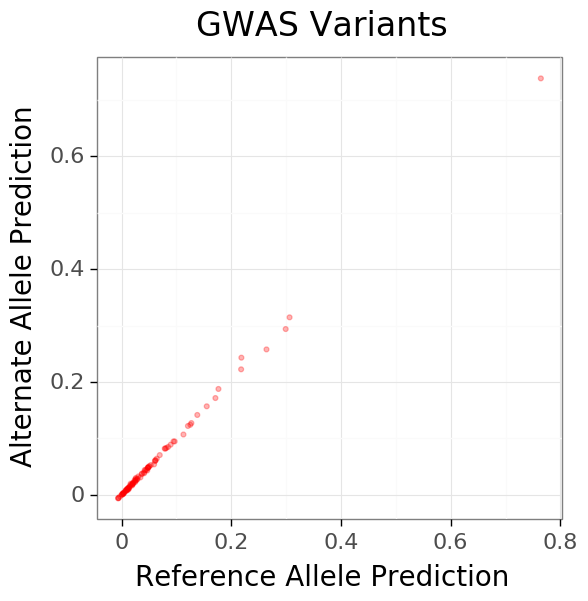

<ggplot: (-9223363251148066395)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
11,chr6,27671598,27671599,rs149417812,C,T,0.840737,-0.024350,0.120784,Y,0.764422,0.738284,-0.026138
13,chr6,27671662,27671663,rs112219934,A,G,0.754505,0.113176,0.367971,Y,0.264221,0.257868,-0.006353
4,chr6,27670599,27670600,rs138542729,C,G,0.836961,0.024944,0.120816,Y,0.112839,0.107006,-0.005833
49,chr6,27679125,27679126,rs73389013,C,G,0.469550,0.291358,0.421535,Y,0.059325,0.054028,-0.005298
14,chr6,27671825,27671826,rs13192965,A,G,0.433870,-0.026299,0.033509,Y,0.299234,0.293975,-0.005260
32,chr6,27675124,27675125,rs78996076,A,C,0.533804,-0.049045,0.079322,Y,0.046873,0.043247,-0.003625
72,chr6,27683188,27683189,rs143208290,C,T,0.742819,-0.133695,0.414069,Y,0.034392,0.031000,-0.003392
43,chr6,27676962,27676963,rs115568705,C,T,0.516755,-0.528771,0.866056,Y,0.041277,0.038323,-0.002954
7,chr6,27671293,27671294,rs114842791,G,T,0.438768,0.390454,0.533470,Y,0.011465,0.008563,-0.002901
84,chr6,27685061,27685062,rs79223588,A,G,0.017906,0.087042,0.036404,Y,0.013571,0.010856,-0.002715


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
54,chr6,27679717,27679718,rs9393846,C,T,7.154160e-07,-0.111785,0.022390,Y,0.030589,0.032753,0.002164
1,chr6,27670455,27670456,rs187250453,A,C,8.796630e-01,0.037668,0.249845,Y,0.025541,0.028192,0.002651
51,chr6,27679445,27679446,rs9368527,A,C,7.567050e-05,-0.077616,0.019555,Y,0.016632,0.019980,0.003347
62,chr6,27681125,27681126,rs144057412,C,T,5.553500e-01,0.081081,0.136319,Y,0.078762,0.082237,0.003475
60,chr6,27680851,27680852,rs189502770,A,G,6.625160e-01,-0.105724,0.245229,Y,0.138098,0.141667,0.003570
29,chr6,27674634,27674635,rs145243438,C,T,7.558220e-01,-0.042672,0.137998,Y,0.026146,0.030026,0.003880
15,chr6,27671888,27671889,rs182800448,A,T,8.432460e-01,-0.023957,0.120769,Y,0.217993,0.222554,0.004561
12,chr6,27671657,27671658,rs6930169,G,T,2.063250e-01,0.097462,0.078000,Y,0.306318,0.314723,0.008406
9,chr6,27671457,27671458,rs77032218,A,G,5.914630e-02,0.064289,0.034317,Y,0.176656,0.187759,0.011102
10,chr6,27671590,27671591,rs140187308,C,T,3.423050e-01,0.177072,0.183344,Y,0.218456,0.243201,0.024745


FOLD:  5
All SNPs:


(2339, 12)

SNPs in Peaks:


(56, 12)

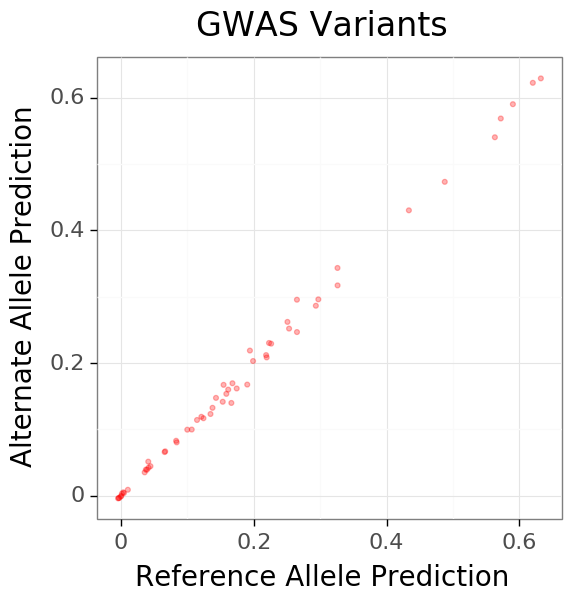

<ggplot: (-9223363251148037418)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
45,chr4,987663,987664,rs3806758,C,G,0.100219,-0.037952,0.023033,Y,0.166166,0.139694,-0.026472
18,chr4,957778,957779,rs2335500,A,G,0.961210,-0.002649,0.054401,Y,0.563108,0.540362,-0.022746
46,chr4,987673,987674,rs3806759,A,G,0.644937,0.015097,0.032813,Y,0.190086,0.167382,-0.022704
1,chr4,874986,874987,rs3775131,C,T,0.419328,0.039773,0.049009,Y,0.264983,0.246606,-0.018377
21,chr4,958306,958307,rs114739803,C,T,0.804092,0.024863,0.099980,Y,0.487631,0.473150,-0.014481
8,chr4,875529,875530,rs2279187,C,T,0.000147,0.108625,0.028316,Y,0.174217,0.161534,-0.012683
0,chr4,874863,874864,rs3775132,C,T,0.144866,-0.072860,0.050438,Y,0.134742,0.123028,-0.011714
16,chr4,957356,957357,rs75854631,A,G,0.106170,0.080468,0.050315,Y,0.153180,0.141477,-0.011703
19,chr4,958090,958091,rs34406303,C,G,0.005279,0.096682,0.035040,Y,0.219357,0.208362,-0.010995
30,chr4,973371,973372,rs10008164,A,G,0.432413,-0.351977,0.429125,Y,0.326179,0.316979,-0.009200


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
26,chr4,960331,960332,rs11248059,C,G,7.720080e-07,0.137055,0.027375,Y,0.226081,0.229099,0.003018
33,chr4,986484,986485,rs28536019,C,T,4.241090e-01,0.362625,0.433452,Y,0.198884,0.202914,0.004030
5,chr4,875266,875267,rs58429160,A,G,4.694770e-04,-0.086781,0.024633,Y,0.143006,0.147330,0.004324
37,chr4,987210,987211,rs2276905,C,T,3.077370e-01,-0.155840,0.155903,Y,0.222926,0.230144,0.007218
38,chr4,987276,987277,rs11936407,C,T,4.756650e-03,0.055141,0.019494,Y,0.040994,0.051172,0.010178
10,chr4,875887,875888,rs2279186,A,G,5.958260e-07,0.107279,0.021649,Y,0.250672,0.261920,0.011248
15,chr4,876399,876400,rs3736086,C,T,5.207610e-01,-0.027152,0.042145,Y,0.154470,0.166993,0.012523
3,chr4,875144,875145,rs3775130,A,G,3.748770e-05,-0.121438,0.029109,Y,0.326058,0.343264,0.017205
27,chr4,960542,960543,rs35117553,G,T,2.365500e-01,0.057519,0.048939,Y,0.194112,0.218681,0.024569
25,chr4,960081,960082,rs4690324,A,G,7.611090e-01,0.007708,0.025337,Y,0.264937,0.295384,0.030447


SNPs NOT in Peaks:


(2283, 12)

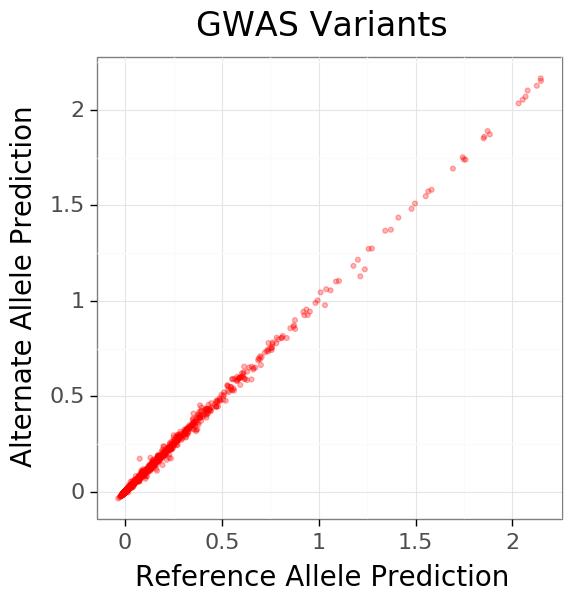

<ggplot: (8785706668769)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
207,chr4,956364,956365,rs61757581,C,G,4.205890e-01,0.100553,0.126414,Y,1.214819,1.128775,-0.086044
1593,chr4,90759047,90759048,rs2619363,G,T,1.427720e-08,0.117808,0.020641,Y,1.237838,1.165385,-0.072452
878,chr4,90630901,90630902,rs356174,G,T,9.513740e-12,-0.133660,0.019521,Y,0.652820,0.588966,-0.063854
265,chr4,975565,975566,rs114865405,A,G,4.198930e-01,0.158328,0.200142,Y,0.236666,0.175548,-0.061118
1589,chr4,90758389,90758390,rs2301135,C,G,1.585330e-01,-0.026366,0.018701,Y,1.032243,0.977914,-0.054329
1333,chr4,90721492,90721493,rs28720123,A,G,2.469290e-02,0.838997,0.426378,Y,0.164815,0.110495,-0.054319
1015,chr4,90655322,90655323,rs79613539,A,G,3.699850e-01,0.094174,0.106367,Y,0.193466,0.140841,-0.052625
769,chr4,90607077,90607078,rs10029694,C,G,6.572040e-04,0.099345,0.029465,Y,0.367045,0.317834,-0.049211
174,chr4,951947,951948,rs34311866,C,T,2.476780e-12,-0.165559,0.023347,Y,0.227077,0.178714,-0.048364
1170,chr4,90687134,90687135,rs58877857,A,C,4.388050e-01,0.081552,0.106476,Y,0.214096,0.168050,-0.046047


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
129,chr4,940660,940661,rs188911015,A,G,2.421530e-01,0.086433,0.074627,Y,0.553052,0.591659,0.038607
132,chr4,940904,940905,rs35208825,A,G,7.985180e-03,0.092293,0.035165,Y,0.740045,0.779587,0.039542
1258,chr4,90705960,90705961,rs143963281,C,T,4.412930e-01,-0.157300,0.208153,Y,0.614818,0.655580,0.040762
1875,chr4,90810674,90810675,rs145554255,C,G,4.210600e-01,0.080849,0.099540,Y,0.197376,0.238709,0.041333
1876,chr4,90810732,90810733,rs74664209,C,G,1.338330e-09,0.272700,0.043602,Y,0.250640,0.296506,0.045866
177,chr4,952409,952410,rs748483,A,G,8.014240e-07,0.136879,0.027381,Y,0.394619,0.442473,0.047854
2016,chr4,90835558,90835559,rs17806425,C,T,1.356870e-03,0.174296,0.053331,Y,0.130728,0.178974,0.048246
100,chr4,910875,910876,rs12646291,C,T,1.491090e-01,0.072222,0.050518,Y,0.352727,0.410361,0.057634
934,chr4,90638896,90638897,rs60838312,A,G,5.445150e-01,-0.024937,0.041275,Y,0.386612,0.453216,0.066604
847,chr4,90625809,90625810,rs12505231,A,C,1.304240e-02,0.142261,0.058364,Y,0.075187,0.173826,0.098639


FOLD:  7
All SNPs:


(5222, 12)

SNPs in Peaks:


(473, 12)

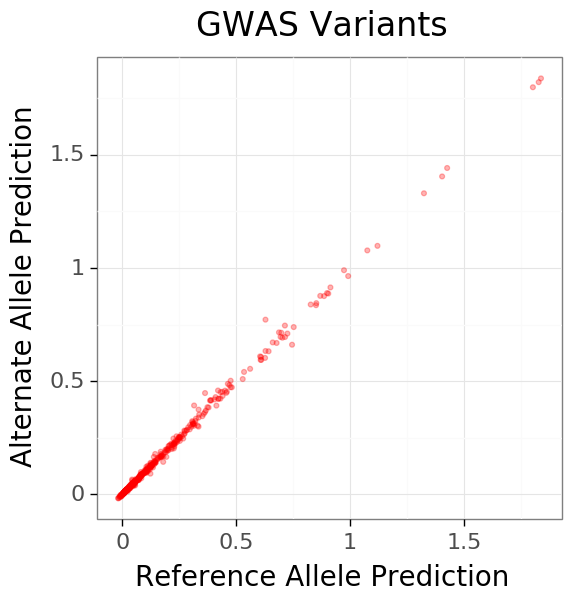

<ggplot: (-9223363251148143251)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
263,chr17,44024660,44024661,rs62062786,C,G,4.529580e-22,0.226334,0.023892,Y,0.745252,0.660788,-0.084464
61,chr17,43767188,43767189,rs2040845,C,G,2.691480e-22,0.228087,0.023950,Y,0.179361,0.143286,-0.036074
390,chr17,44200015,44200016,rs62061856,C,T,2.687150e-22,0.227719,0.023911,Y,0.334671,0.298991,-0.035680
344,chr17,44122626,44122627,rs62063669,A,C,2.509760e-22,0.227852,0.023909,Y,0.123244,0.091183,-0.032062
388,chr17,44199290,44199291,rs4792830,C,T,3.336290e-02,-0.054123,0.025317,Y,0.193472,0.165312,-0.028160
2,chr17,43394569,43394570,rs115344032,C,G,1.227880e-03,0.301428,0.089844,Y,0.991760,0.964086,-0.027674
334,chr17,44121469,44121470,rs41399444,C,T,2.510320e-22,-0.227852,0.023909,Y,0.330561,0.303338,-0.027224
174,chr17,43909690,43909691,rs116060954,A,G,9.040240e-01,-0.021208,0.176350,Y,0.626710,0.602470,-0.024239
371,chr17,44168508,44168509,rs111364350,C,T,2.574080e-22,-0.227827,0.023912,Y,0.226250,0.202514,-0.023737
20,chr17,43483774,43483775,rs1230101,A,G,1.069460e-02,-0.051516,0.020132,Y,1.120384,1.097586,-0.022799


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
264,chr17,44024865,44024866,rs62062787,C,T,3.317200e-22,0.227330,0.023921,Y,0.687900,0.715382,0.027482
305,chr17,44087508,44087509,rs118039425,A,G,9.397840e-02,-0.089178,0.052727,Y,0.388137,0.416057,0.027920
210,chr17,43983801,43983802,rs62056806,A,G,3.939880e-22,-0.226704,0.023898,Y,0.384979,0.414201,0.029222
289,chr17,44065901,44065902,rs919464,C,T,2.189750e-22,-0.228225,0.023915,Y,0.713875,0.745452,0.031577
274,chr17,44043265,44043266,rs182397490,C,T,6.651150e-03,0.476457,0.167038,Y,0.144225,0.178183,0.033958
304,chr17,44087500,44087501,rs41543317,A,G,7.445630e-06,-0.085121,0.018961,Y,0.420158,0.458616,0.038457
261,chr17,44024552,44024553,rs62062784,C,G,3.332810e-22,-0.227322,0.023922,Y,0.334828,0.374008,0.039180
389,chr17,44199670,44199671,rs62061855,A,G,7.115390e-22,0.225965,0.023969,Y,0.315095,0.392377,0.077282
338,chr17,44121917,44121918,rs77768866,C,T,2.510300e-22,-0.227852,0.023909,Y,0.363167,0.447240,0.084073
89,chr17,43784994,43784995,rs62056913,C,T,2.273570e-22,-0.228491,0.023952,Y,0.628593,0.771487,0.142893


SNPs NOT in Peaks:


(4749, 12)

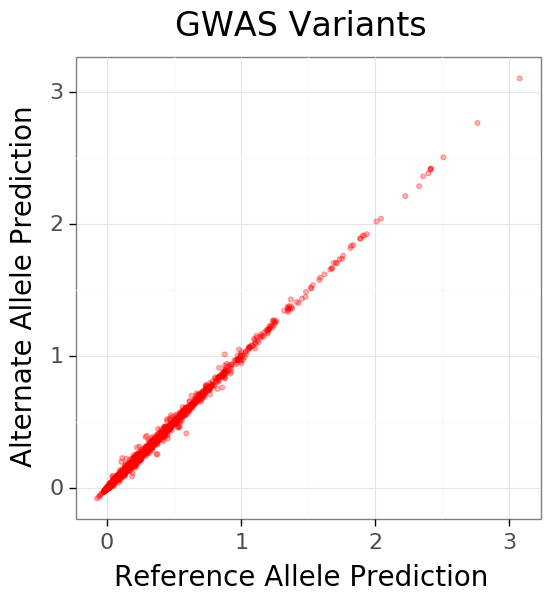

<ggplot: (8785706709487)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
907,chr17,43765881,43765882,rs6503443,C,T,9.382650e-21,0.210980,0.022961,Y,0.590577,0.416624,-0.173953
1297,chr17,43821478,43821479,rs8082105,A,G,3.243470e-02,-0.050907,0.023700,Y,0.375964,0.258061,-0.117903
2443,chr17,43993709,43993710,rs114020901,C,G,3.528520e-01,-0.378884,0.394921,Y,0.367995,0.260469,-0.107526
1176,chr17,43805590,43805591,rs62054388,C,T,3.345750e-22,-0.227387,0.023931,Y,0.186174,0.091588,-0.094586
4735,chr17,44866805,44866806,rs11658976,A,G,1.082640e-02,0.051482,0.020180,Y,0.858368,0.763849,-0.094519
3014,chr17,44081527,44081528,rs62064665,C,T,2.110720e-22,0.228320,0.023915,Y,0.452541,0.377479,-0.075062
706,chr17,43727061,43727062,rs453997,C,T,3.051050e-22,-0.227963,0.023968,Y,0.191068,0.117253,-0.073815
1146,chr17,43799804,43799805,rs77819001,A,C,3.941240e-22,0.227034,0.023934,Y,0.534454,0.461783,-0.072671
1307,chr17,43823084,43823085,rs8071902,A,G,6.604970e-01,-0.140157,0.313098,Y,0.535473,0.463194,-0.072279
2798,chr17,44051513,44051514,rs112165071,A,G,9.574640e-01,0.016743,0.316662,Y,0.541752,0.470544,-0.071209


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
662,chr17,43715045,43715046,rs189470858,A,G,4.648960e-01,-0.121642,0.164052,Y,0.476261,0.553532,0.077270
3104,chr17,44094667,44094668,rs2316948,C,G,2.222920e-22,-0.228177,0.023913,Y,0.446693,0.524057,0.077364
1496,chr17,43848968,43848969,rs62055937,G,T,3.037610e-22,-0.227711,0.023941,Y,0.834969,0.912783,0.077814
2564,chr17,44013281,44013282,rs73984643,G,T,3.507010e-01,0.424971,0.435111,Y,0.142170,0.225785,0.083615
1675,chr17,43886904,43886905,rs74370049,A,G,1.779730e-01,0.100561,0.075612,Y,0.222098,0.311498,0.089399
3332,chr17,44134954,44134955,rs12449717,C,G,6.692500e-01,0.042469,0.099993,Y,0.106254,0.201816,0.095563
1216,chr17,43810873,43810874,rs75022332,A,T,2.737840e-22,-0.232988,0.024483,Y,0.296157,0.398380,0.102222
3162,chr17,44105861,44105862,rs114542437,A,C,2.785290e-01,0.139420,0.126383,Y,0.286366,0.390251,0.103885
2343,chr17,43978120,43978121,rs62056796,A,G,3.939880e-22,-0.226704,0.023898,Y,0.113531,0.229964,0.116433
2299,chr17,43971785,43971786,rs11575895,A,G,3.939740e-22,-0.226704,0.023898,Y,0.877704,1.015248,0.137544


FOLD:  8
All SNPs:


(4093, 12)

SNPs in Peaks:


(136, 12)

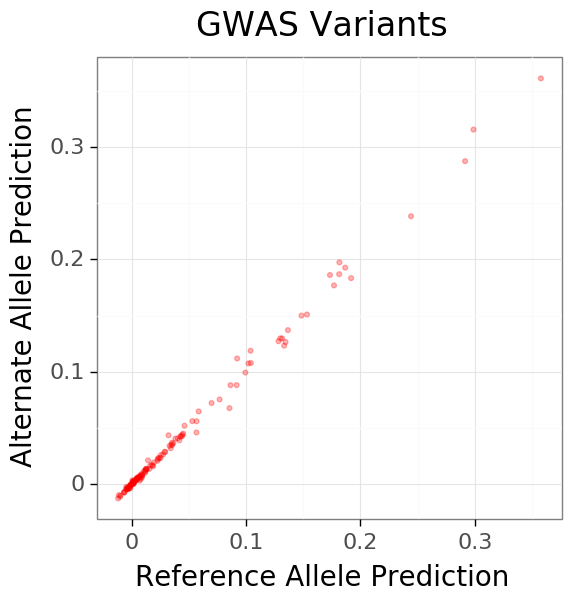

<ggplot: (-9223363251148053914)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
60,chr12,41312147,41312148,rs1372543,A,G,0.509090,-0.031469,0.047479,Y,0.085442,0.067636,-0.017806
9,chr12,34123490,34123491,rs142024504,A,G,0.937564,-0.018390,0.232488,Y,0.056589,0.045979,-0.010610
129,chr12,123268840,123268841,rs2454699,C,T,0.990383,0.001419,0.117667,Y,0.133263,0.123254,-0.010009
88,chr12,41459242,41459243,rs181012052,C,T,0.683461,0.066059,0.160853,Y,0.191794,0.183385,-0.008410
76,chr12,41408603,41408604,rs78037279,C,T,0.472893,0.188869,0.257034,Y,0.134509,0.126452,-0.008058
74,chr12,41407403,41407404,rs278899,A,G,0.005572,0.061770,0.022185,Y,0.244199,0.238467,-0.005731
119,chr12,42300681,42300682,rs17576430,C,T,0.430900,-0.146159,0.182091,Y,0.291444,0.287486,-0.003958
123,chr12,123268000,123268001,rs2936730,C,G,0.893199,-0.003892,0.028980,Y,0.006940,0.003100,-0.003840
116,chr12,42300410,42300411,rs150364966,A,G,0.264386,0.349826,0.325245,Y,0.091673,0.088152,-0.003521
53,chr12,41311120,41311121,rs56294359,C,T,0.303675,-0.019400,0.018857,Y,0.007706,0.004512,-0.003195


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
73,chr12,41407060,41407061,rs11179482,C,G,7.404100e-02,-0.049874,0.027781,Y,0.046184,0.051989,0.005804
77,chr12,41408740,41408741,rs35862989,A,T,4.578600e-02,-0.086695,0.043869,Y,0.186631,0.192700,0.006069
90,chr12,41460146,41460147,rs280378,A,C,7.555660e-01,-0.094502,0.307340,Y,0.058549,0.064690,0.006141
87,chr12,41458942,41458943,rs61924412,C,T,6.593180e-01,-0.032076,0.073008,Y,0.014247,0.021152,0.006905
43,chr12,40820403,40820404,rs11564249,C,T,2.873730e-04,0.209432,0.056315,Y,0.032164,0.043470,0.011307
75,chr12,41408134,41408135,rs397967,A,G,2.227530e-09,-0.333909,0.053696,Y,0.173338,0.186142,0.012803
117,chr12,42300417,42300418,rs74658662,G,T,4.308650e-01,0.146171,0.182091,Y,0.103915,0.118726,0.014811
122,chr12,123238416,123238417,rs79350782,G,T,1.216290e-01,0.064001,0.041032,Y,0.181570,0.197377,0.015807
63,chr12,41312642,41312643,rs144175278,C,T,7.520790e-02,0.152721,0.084239,Y,0.298801,0.315577,0.016775
54,chr12,41311339,41311340,rs187801857,A,T,5.163180e-01,-0.192545,0.304514,Y,0.092178,0.111850,0.019672


SNPs NOT in Peaks:


(3957, 12)

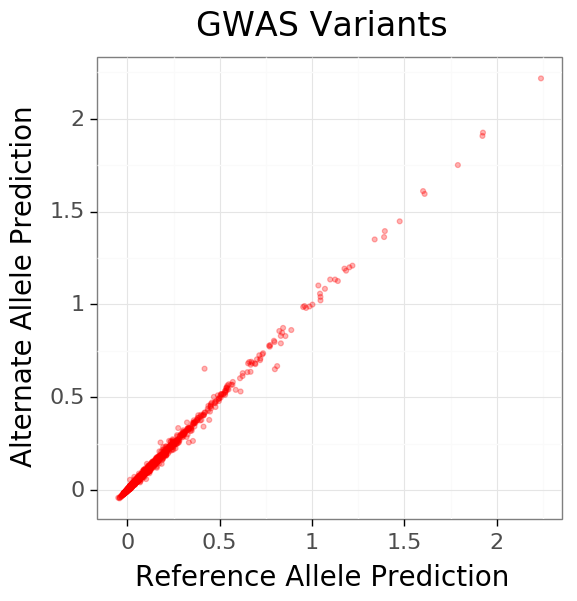

<ggplot: (8785706623110)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
3925,chr12,123337761,123337762,rs12298151,A,G,6.186260e-01,-0.019407,0.038896,Y,0.798807,0.651353,-0.147454
1629,chr12,40413305,40413306,rs28370664,A,C,1.753300e-20,-0.502667,0.051311,Y,0.811157,0.668225,-0.142932
3402,chr12,42149726,42149727,rs118167883,C,T,8.941480e-01,0.013411,0.100626,Y,0.355095,0.265038,-0.090057
2298,chr12,40894172,40894173,rs17597637,G,T,3.290310e-01,-0.025448,0.026134,Y,0.613142,0.531460,-0.081681
3770,chr12,123303945,123303946,rs1798569,A,C,8.556560e-01,-0.011185,0.061397,Y,0.333120,0.256869,-0.076251
62,chr12,33200884,33200885,rs10844438,G,T,2.493900e-02,0.042965,0.019146,Y,0.412392,0.342179,-0.070213
1163,chr12,34638125,34638126,rs148871662,C,T,8.480130e-01,-0.030516,0.158654,Y,0.443263,0.378291,-0.064972
3948,chr12,123342229,123342230,rs1587856,A,G,6.940980e-01,0.011758,0.029932,Y,0.586791,0.540283,-0.046508
1937,chr12,40736885,40736886,rs150954733,A,C,7.282880e-05,-0.493979,0.119268,Y,0.185869,0.141646,-0.044223
882,chr12,34148670,34148671,rs149952518,C,G,4.041430e-01,-0.046916,0.055903,Y,0.101634,0.059680,-0.041953


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
3172,chr12,41446008,41446009,rs11179617,A,G,0.056895,-0.049305,0.025777,Y,0.105761,0.141872,0.036111
925,chr12,34187330,34187331,rs7966991,C,G,0.913739,-0.024202,0.226314,Y,1.098271,1.134619,0.036348
1068,chr12,34417692,34417693,rs12824730,C,T,0.288800,0.039501,0.037388,Y,0.193878,0.232123,0.038245
1262,chr12,34662897,34662898,rs9300216,C,T,0.585729,0.114513,0.207129,Y,0.226065,0.265477,0.039413
608,chr12,33863084,33863085,rs7973375,A,G,0.602184,-0.037676,0.072614,Y,0.014586,0.056149,0.041563
3902,chr12,123329737,123329738,rs56272219,A,G,0.592485,0.020869,0.038893,Y,0.322872,0.364461,0.041589
3567,chr12,43054197,43054198,rs188012290,A,G,0.949234,-0.007650,0.120559,Y,0.275320,0.334507,0.059187
91,chr12,33206148,33206149,rs71457681,C,T,0.758961,-0.017871,0.058375,Y,1.034120,1.102388,0.068268
1752,chr12,40522562,40522563,rs73105427,A,G,0.481100,0.200384,0.292318,Y,0.179593,0.256744,0.077151
1941,chr12,40737115,40737116,rs10784518,G,T,0.145578,-0.038183,0.026144,Y,0.418090,0.654092,0.236002


FOLD:  9
All SNPs:


(323, 12)

SNPs in Peaks:


(43, 12)

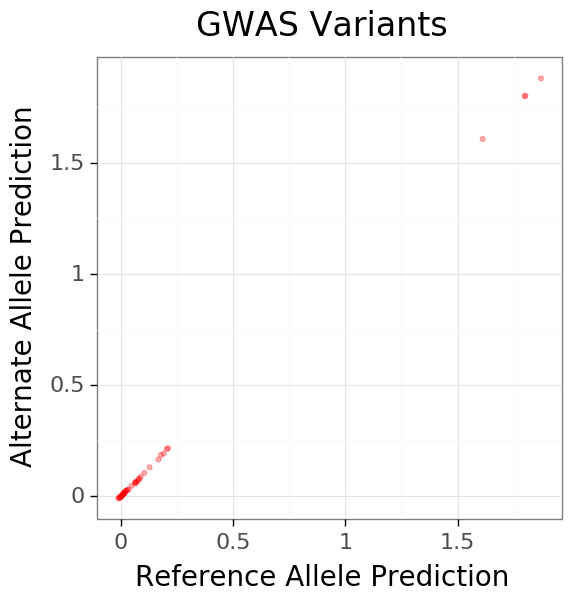

<ggplot: (-9223363251148330261)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
3,chr10,121292329,121292330,rs185953720,G,T,9.753270e-01,-0.004413,0.143041,Y,0.075316,0.070019,-0.005297
34,chr10,121536635,121536636,rs72826422,C,G,6.396350e-02,-0.071163,0.038100,Y,0.065785,0.061153,-0.004632
28,chr10,121532890,121532891,rs144030311,A,G,9.665760e-01,0.008238,0.197415,Y,-0.001573,-0.005940,-0.004366
21,chr10,121458850,121458851,rs117953397,C,G,9.221510e-02,-0.063552,0.037469,Y,0.062923,0.058894,-0.004030
42,chr10,121710488,121710489,rs118117788,C,T,2.147610e-08,0.403039,0.068671,Y,0.082511,0.078525,-0.003987
9,chr10,121368348,121368349,rs115879160,G,T,8.644330e-01,-0.026199,0.153915,Y,1.611258,1.607334,-0.003925
25,chr10,121460332,121460333,rs116984350,C,T,1.144750e-01,0.155602,0.100474,Y,0.035334,0.032039,-0.003295
16,chr10,121369014,121369015,rs12416614,C,T,8.480300e-01,-0.032586,0.170783,Y,0.066546,0.064370,-0.002175
39,chr10,121709909,121709910,rs7914591,C,T,7.836850e-01,0.005418,0.019742,Y,0.011455,0.010003,-0.001452
15,chr10,121368873,121368874,rs145701507,C,T,5.835250e-01,-0.159246,0.296942,Y,0.167528,0.166126,-0.001402


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
26,chr10,121532439,121532440,rs36063779,G,T,0.310946,-0.044338,0.043524,Y,0.021939,0.023929,0.001989
0,chr10,121291941,121291942,rs7076994,C,T,0.108689,-0.052327,0.032813,Y,0.014065,0.016080,0.002014
8,chr10,121368169,121368170,rs11199044,A,C,0.739901,0.013698,0.041330,Y,0.190447,0.192784,0.002337
2,chr10,121292123,121292124,rs10787976,A,G,0.277104,0.036571,0.033790,Y,0.021503,0.024493,0.002990
18,chr10,121369103,121369104,rs138715304,G,T,0.306950,-0.070275,0.069407,Y,0.128075,0.131252,0.003177
27,chr10,121532886,121532887,rs61867903,G,T,0.310642,-0.044365,0.043523,Y,-0.011652,-0.006695,0.004957
37,chr10,121663221,121663222,rs188110292,A,G,0.132260,0.487241,0.307452,Y,0.210877,0.216344,0.005466
13,chr10,121368582,121368583,rs142590307,C,T,0.875046,0.034921,0.222869,Y,0.178200,0.185895,0.007696
12,chr10,121368477,121368478,rs11199045,C,G,0.170513,0.030679,0.022435,Y,1.871283,1.879569,0.008286
14,chr10,121368847,121368848,rs7075175,C,G,0.734674,-0.007222,0.021319,Y,0.204144,0.213627,0.009483


SNPs NOT in Peaks:


(280, 12)

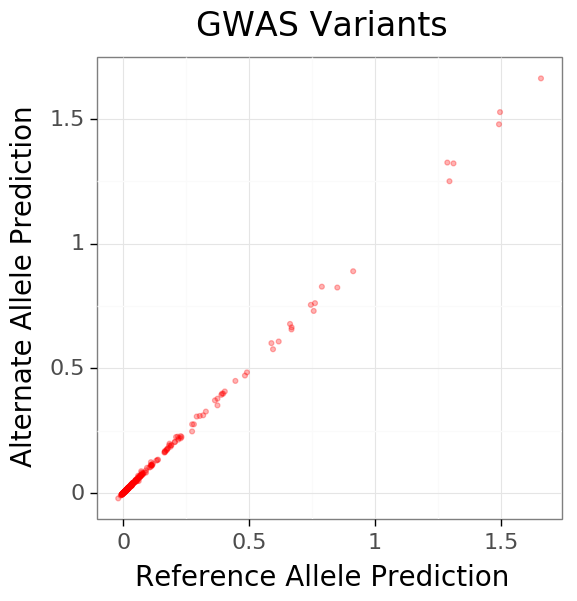

<ggplot: (-9223363251148152639)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
82,chr10,121376917,121376918,rs11199049,A,G,0.145982,-0.030658,0.021127,Y,1.295296,1.250033,-0.045263
119,chr10,121411636,121411637,rs2577336,C,G,0.206975,-0.024320,0.019284,Y,0.756096,0.729907,-0.026189
28,chr10,121298882,121298883,rs12411320,A,G,0.716052,0.058573,0.162274,Y,0.273006,0.246851,-0.026155
197,chr10,121655932,121655933,rs7084324,C,G,0.000031,0.117998,0.028010,Y,0.849811,0.823754,-0.026057
129,chr10,121414702,121414703,rs196337,C,T,0.981997,-0.000664,0.029428,Y,0.912843,0.889157,-0.023686
160,chr10,121464050,121464051,rs17099211,C,G,0.068557,-0.069240,0.037712,Y,0.373777,0.351397,-0.022380
130,chr10,121414758,121414759,rs11199061,A,C,0.405372,0.032578,0.039303,Y,0.594470,0.576395,-0.018075
120,chr10,121411861,121411862,rs196335,C,T,0.767136,0.009306,0.031394,Y,1.492125,1.478395,-0.013730
104,chr10,121408865,121408866,rs34966089,C,T,0.379355,0.035024,0.039677,Y,0.061082,0.048126,-0.012956
156,chr10,121462047,121462048,rs11199075,A,G,0.000274,0.080234,0.022175,Y,0.482976,0.470887,-0.012089


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
128,chr10,121414598,121414599,rs12250770,C,T,0.002635,-0.065469,0.021867,Y,0.588033,0.600856,0.012823
103,chr10,121408818,121408819,rs112976130,A,C,0.149216,-0.034486,0.023842,Y,0.109545,0.123585,0.014040
162,chr10,121464562,121464563,rs196232,C,T,0.631662,-0.350420,0.765679,Y,0.183389,0.197875,0.014486
37,chr10,121367763,121367764,rs17099080,C,T,0.168988,0.030790,0.022437,Y,0.291335,0.306545,0.015209
27,chr10,121298846,121298847,rs6585552,C,G,0.186698,-0.044158,0.033610,Y,0.209264,0.224562,0.015298
126,chr10,121414205,121414206,rs148789629,C,T,0.023714,-0.361682,0.152992,Y,0.662029,0.677812,0.015783
201,chr10,121657181,121657182,rs2456723,A,G,0.913433,0.002161,0.019876,Y,0.070871,0.087359,0.016488
121,chr10,121412132,121412133,rs55725412,A,G,0.138118,-0.030363,0.020508,Y,1.496181,1.527157,0.030976
84,chr10,121377046,121377047,rs11199050,C,T,0.429689,-0.016900,0.021376,Y,1.286823,1.324868,0.038045
118,chr10,121411631,121411632,rs112168846,A,G,0.416034,0.041580,0.051391,Y,0.788445,0.827280,0.038835


In [14]:
get_results_all_folds('PD_GBA1_MDTG')

TASK:  PD_CTRL_SUNI
FOLD:  0
All SNPs:


(446, 12)

SNPs in Peaks:


(38, 12)

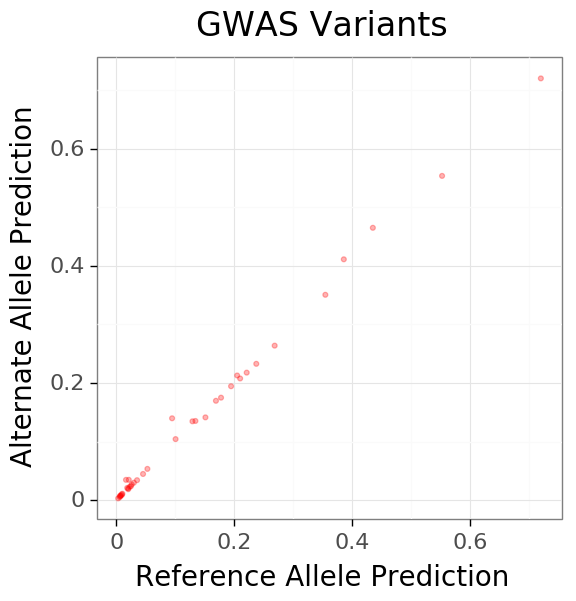

<ggplot: (8785706458965)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
6,chr1,155135335,155135336,rs4460629,C,T,0.914949,0.002004,0.018767,Y,0.151141,0.141237,-0.009904
14,chr1,155207626,155207627,rs2009578,A,G,0.882222,0.003030,0.020456,Y,0.268733,0.263752,-0.004981
2,chr1,154984020,154984021,rs114875695,A,G,0.269207,0.208802,0.194312,Y,0.237513,0.232703,-0.004810
9,chr1,155140023,155140024,rs114413971,A,C,0.326770,0.045034,0.046174,Y,0.354798,0.350629,-0.004169
13,chr1,155207549,155207550,rs762488,C,T,0.665464,0.008818,0.020404,Y,0.221242,0.217651,-0.003591
1,chr1,154983930,154983931,rs77982133,C,T,0.411751,0.038985,0.047293,Y,0.177659,0.174890,-0.002769
0,chr1,154983539,154983540,rs6686021,C,T,0.666264,-0.008833,0.020485,Y,0.210079,0.207670,-0.002409
32,chr1,205669322,205669323,rs823099,A,C,0.070324,-0.034245,0.018910,Y,0.020032,0.018499,-0.001533
29,chr1,155822721,155822722,rs822489,C,T,0.874771,0.006706,0.042514,Y,0.035041,0.033931,-0.001111
31,chr1,155822971,155822972,rs822490,C,T,0.100531,-0.032386,0.019693,Y,0.024735,0.023761,-0.000974


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
28,chr1,155822629,155822630,rs112685832,A,C,0.260298,0.037156,0.033118,Y,0.134161,0.135071,0.000910
12,chr1,155207367,155207368,rs74500255,A,T,0.201524,1.753920,1.169310,Y,0.018268,0.020657,0.002389
36,chr1,205671001,205671002,rs116664067,A,T,0.578558,0.050852,0.092143,Y,0.100476,0.104100,0.003624
37,chr1,205671167,205671168,rs1417725,A,G,0.022548,0.114527,0.050882,Y,0.129103,0.134504,0.005401
26,chr1,155822529,155822530,rs13376235,A,G,0.521447,-0.028032,0.043575,Y,0.205013,0.212810,0.007797
17,chr1,155207985,155207986,rs74462743,C,T,0.144436,2.080070,1.183400,Y,0.020992,0.034535,0.013544
18,chr1,155208006,155208007,rs364897,C,T,0.200427,-1.170800,0.809268,Y,0.016267,0.034484,0.018217
10,chr1,155140027,155140028,rs12131522,C,T,0.958053,0.000990,0.018828,Y,0.386153,0.411255,0.025102
19,chr1,155208361,155208362,rs147138516,C,G,0.014743,1.417620,0.495539,Y,0.435445,0.465080,0.029634
33,chr1,205670369,205670370,rs6673687,A,T,0.000008,-0.086770,0.019520,Y,0.094532,0.139663,0.045131


SNPs NOT in Peaks:


(408, 12)

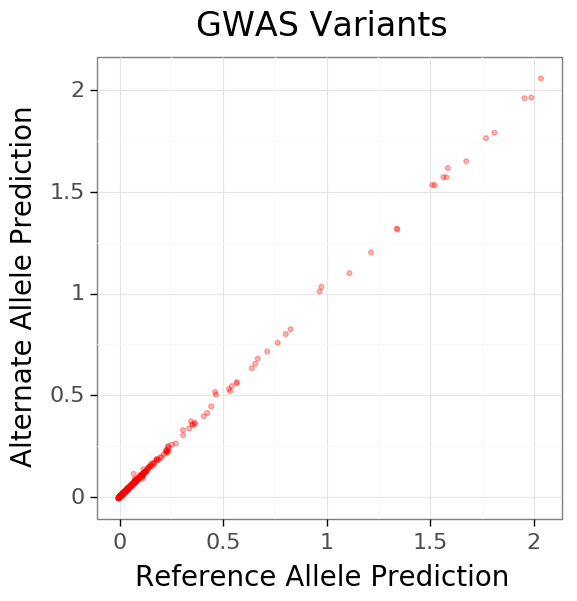

<ggplot: (-9223363251148338190)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
79,chr1,155108287,155108288,rs11264333,A,G,8.009820e-02,0.033430,0.019119,Y,1.341829,1.315398,-0.026431
322,chr1,205719857,205719858,rs865402,A,T,8.008280e-02,0.087904,0.050790,Y,1.989403,1.963337,-0.026067
85,chr1,155113074,155113075,rs12745576,A,C,9.734980e-01,-0.001967,0.059259,Y,1.675211,1.650318,-0.024893
11,chr1,154911651,154911652,rs4845694,C,G,7.796100e-01,0.005313,0.018987,Y,0.112287,0.090230,-0.022057
317,chr1,205718967,205718968,rs186075993,A,G,4.834930e-01,0.047620,0.068347,Y,1.811158,1.790522,-0.020636
144,chr1,155139509,155139510,rs7556304,C,T,9.384060e-01,0.001451,0.018780,Y,1.340023,1.319578,-0.020445
28,chr1,154914552,154914553,rs6690352,C,T,2.598440e-01,0.542296,0.450027,Y,0.534618,0.520577,-0.014042
321,chr1,205719532,205719533,rs823114,A,G,9.556550e-09,-0.108059,0.018875,Y,1.215199,1.202981,-0.012218
37,chr1,154916380,154916381,rs190798318,C,T,3.521610e-01,-0.239792,0.264808,Y,0.233682,0.221490,-0.012192
5,chr1,154910321,154910322,rs12045997,G,T,3.426640e-01,0.130869,0.140270,Y,1.110966,1.100434,-0.010531


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
404,chr1,205743502,205743503,rs11803735,A,G,0.416137,0.082596,0.102687,Y,0.115011,0.136997,0.021986
86,chr1,155113104,155113105,rs4971073,G,T,0.084931,-0.033555,0.019501,Y,1.510933,1.533756,0.022822
93,chr1,155118588,155118589,rs147847496,C,T,0.840517,0.012015,0.059622,Y,0.306290,0.329640,0.023350
1,chr1,154909210,154909211,rs181302437,C,T,0.703779,0.054683,0.142852,Y,0.345135,0.372493,0.027358
58,chr1,154990297,154990298,rs2242194,C,G,0.757144,-0.006030,0.019504,Y,1.586168,1.617178,0.031009
326,chr1,205720925,205720926,rs144606419,A,C,0.558080,-0.168112,0.281681,Y,0.466153,0.503429,0.037276
320,chr1,205719513,205719514,rs115521489,A,G,0.079034,-0.084285,0.048485,Y,0.966401,1.010356,0.043954
286,chr1,205674897,205674898,rs111299170,C,T,0.329323,-0.034498,0.035505,Y,0.068350,0.114540,0.046190
0,chr1,154909169,154909170,rs17356361,C,T,0.276788,0.055702,0.050864,Y,0.461620,0.516896,0.055276
315,chr1,205718810,205718811,rs12727532,C,T,0.454834,-0.208047,0.284532,Y,0.975344,1.033124,0.057781


FOLD:  1
All SNPs:


(313, 12)

SNPs in Peaks:


(9, 12)

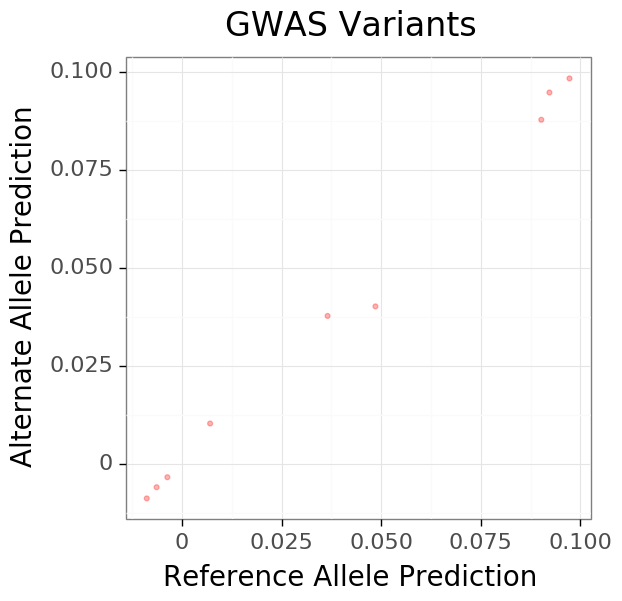

<ggplot: (-9223363251148330443)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
0,chr2,169109956,169109957,rs13002388,A,G,6.338120e-01,-0.012918,0.027152,Y,0.048558,0.040139,-0.008419
2,chr2,169110422,169110423,rs147610000,C,T,5.147330e-02,-0.088236,0.045731,Y,0.090200,0.087752,-0.002448
8,chr2,169132643,169132644,rs67058614,D,I,3.756770e-01,0.024522,0.027746,Y,-0.008850,-0.008850,0.000000
5,chr2,169131135,169131136,rs183501421,C,T,3.234590e-01,-0.195448,0.202374,Y,-0.003675,-0.003452,0.000223
7,chr2,169132611,169132612,rs77548116,C,T,7.952470e-01,0.012166,0.046951,Y,-0.006379,-0.005997,0.000382
3,chr2,169110500,169110501,rs12474289,A,G,7.941460e-01,0.128192,0.499616,Y,0.097271,0.098305,0.001034
4,chr2,169110621,169110622,rs12622375,A,G,2.420800e-03,-0.057436,0.018949,Y,0.036548,0.037709,0.001162
1,chr2,169110394,169110395,rs1474055,C,T,1.112500e-11,0.184632,0.026727,Y,0.092236,0.094710,0.002474
6,chr2,169131721,169131722,rs955896,A,T,3.743930e-01,0.024463,0.027606,Y,0.007053,0.010252,0.003199


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
0,chr2,169109956,169109957,rs13002388,A,G,6.338120e-01,-0.012918,0.027152,Y,0.048558,0.040139,-0.008419
2,chr2,169110422,169110423,rs147610000,C,T,5.147330e-02,-0.088236,0.045731,Y,0.090200,0.087752,-0.002448
8,chr2,169132643,169132644,rs67058614,D,I,3.756770e-01,0.024522,0.027746,Y,-0.008850,-0.008850,0.000000
5,chr2,169131135,169131136,rs183501421,C,T,3.234590e-01,-0.195448,0.202374,Y,-0.003675,-0.003452,0.000223
7,chr2,169132611,169132612,rs77548116,C,T,7.952470e-01,0.012166,0.046951,Y,-0.006379,-0.005997,0.000382
3,chr2,169110500,169110501,rs12474289,A,G,7.941460e-01,0.128192,0.499616,Y,0.097271,0.098305,0.001034
4,chr2,169110621,169110622,rs12622375,A,G,2.420800e-03,-0.057436,0.018949,Y,0.036548,0.037709,0.001162
1,chr2,169110394,169110395,rs1474055,C,T,1.112500e-11,0.184632,0.026727,Y,0.092236,0.094710,0.002474
6,chr2,169131721,169131722,rs955896,A,T,3.743930e-01,0.024463,0.027606,Y,0.007053,0.010252,0.003199


SNPs NOT in Peaks:


(304, 12)

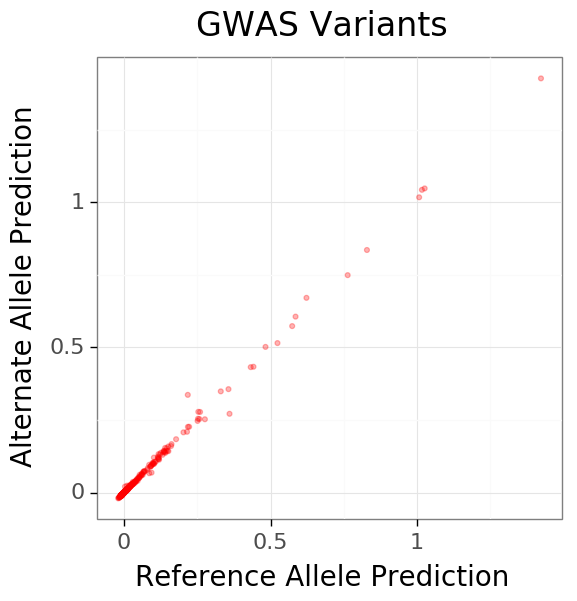

<ggplot: (-9223363251148401720)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
86,chr2,169106699,169106700,rs74271810,C,G,9.943820e-01,-0.000962,0.136617,Y,0.359763,0.271299,-0.088464
10,chr2,169088313,169088314,rs116239781,A,G,5.365450e-01,0.025167,0.040612,Y,0.093685,0.068550,-0.025135
2,chr2,169087232,169087233,rs16855155,A,G,4.915430e-01,-0.117109,0.167852,Y,0.275697,0.252462,-0.023235
249,chr2,169155460,169155461,rs13432275,A,C,7.537470e-03,0.053040,0.019896,Y,0.085806,0.066555,-0.019251
79,chr2,169103999,169104000,rs76179989,G,T,9.560470e-12,-0.185191,0.026721,Y,0.763034,0.749206,-0.013828
62,chr2,169096718,169096719,rs13401489,G,T,6.194720e-03,0.051431,0.018802,Y,0.151103,0.142460,-0.008643
11,chr2,169088635,169088636,rs10177444,A,G,1.815000e-03,0.059667,0.019138,Y,0.523436,0.515106,-0.008330
221,chr2,169150945,169150946,rs2203704,C,T,4.422780e-02,-0.037655,0.018713,Y,0.441561,0.433454,-0.008107
23,chr2,169090336,169090337,rs138015412,C,G,3.559690e-01,-0.254197,0.266511,Y,0.119380,0.113093,-0.006286
213,chr2,169149444,169149445,rs62176382,C,G,2.427310e-03,-0.236048,0.075860,Y,0.046312,0.040462,-0.005849


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
4,chr2,169087435,169087436,rs6735501,C,T,4.422540e-03,0.054176,0.019042,Y,0.259253,0.277651,0.018398
17,chr2,169089920,169089921,rs16855160,C,T,8.454380e-01,-0.006237,0.031972,Y,0.101719,0.120389,0.018670
220,chr2,169150881,169150882,rs2222151,A,G,1.642180e-11,-0.183024,0.026714,Y,0.329928,0.348671,0.018743
88,chr2,169107007,169107008,rs74331475,A,G,2.008930e-01,0.046094,0.036230,Y,0.482609,0.501895,0.019286
203,chr2,169147533,169147534,rs2138754,C,T,4.890620e-02,-0.036881,0.018724,Y,0.585154,0.606245,0.021091
81,chr2,169104870,169104871,rs75561378,C,T,9.247480e-01,0.012904,0.135680,Y,1.025790,1.048176,0.022386
76,chr2,169103028,169103029,rs115292050,A,G,1.559650e-01,-0.124033,0.086145,Y,0.253261,0.278092,0.024830
95,chr2,169112920,169112921,rs115313328,G,T,6.857880e-02,-0.360036,0.207297,Y,1.016385,1.043268,0.026883
77,chr2,169103143,169103144,rs73013478,C,T,6.326570e-01,-0.015436,0.032347,Y,0.622339,0.670991,0.048653
181,chr2,169140638,169140639,rs6741911,A,C,6.095870e-01,-0.014043,0.027537,Y,0.217367,0.336593,0.119227


FOLD:  2
All SNPs:


(212, 12)

SNPs in Peaks:


(12, 12)

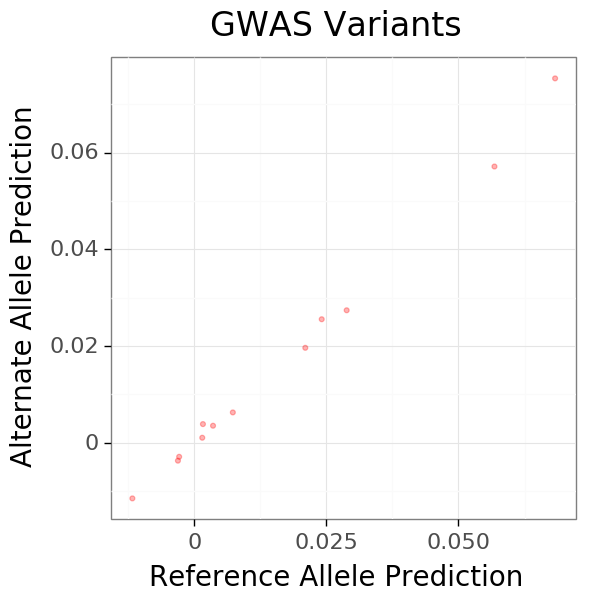

<ggplot: (-9223363251148393486)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
7,chr3,182739778,182739779,rs182753925,C,T,9.171920e-02,-0.295525,0.181985,Y,0.028838,0.027410,-0.001427
1,chr3,182710680,182710681,rs4859261,C,T,4.221840e-08,0.111944,0.020551,Y,0.021006,0.019651,-0.001355
3,chr3,182711005,182711006,rs144166036,G,T,3.460340e-01,-0.428322,0.478385,Y,0.007291,0.006294,-0.000997
11,chr3,182740801,182740802,rs73883999,C,T,9.454170e-02,0.421845,0.267292,Y,-0.003103,-0.003684,-0.000581
4,chr3,182713941,182713942,rs74902465,A,G,4.302800e-08,-0.112069,0.020585,Y,0.001504,0.001059,-0.000445
2,chr3,182710940,182710941,rs78126209,A,G,8.569130e-01,0.010954,0.060833,Y,-0.002870,-0.002879,-0.000008
10,chr3,182740762,182740763,rs146449896,D,I,9.030890e-02,-0.427681,0.267704,Y,0.003543,0.003543,0.000000
0,chr3,182710489,182710490,rs147515099,A,G,5.579360e-01,-0.044117,0.074948,Y,-0.011724,-0.011478,0.000246
8,chr3,182739836,182739837,rs77458140,G,T,7.987470e-01,-0.014804,0.058171,Y,0.056810,0.057128,0.000318
6,chr3,182739738,182739739,rs11928508,C,G,4.694950e-08,0.113244,0.020874,Y,0.024114,0.025557,0.001443


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
3,chr3,182711005,182711006,rs144166036,G,T,3.460340e-01,-0.428322,0.478385,Y,0.007291,0.006294,-0.000997
11,chr3,182740801,182740802,rs73883999,C,T,9.454170e-02,0.421845,0.267292,Y,-0.003103,-0.003684,-0.000581
4,chr3,182713941,182713942,rs74902465,A,G,4.302800e-08,-0.112069,0.020585,Y,0.001504,0.001059,-0.000445
2,chr3,182710940,182710941,rs78126209,A,G,8.569130e-01,0.010954,0.060833,Y,-0.002870,-0.002879,-0.000008
10,chr3,182740762,182740763,rs146449896,D,I,9.030890e-02,-0.427681,0.267704,Y,0.003543,0.003543,0.000000
0,chr3,182710489,182710490,rs147515099,A,G,5.579360e-01,-0.044117,0.074948,Y,-0.011724,-0.011478,0.000246
8,chr3,182739836,182739837,rs77458140,G,T,7.987470e-01,-0.014804,0.058171,Y,0.056810,0.057128,0.000318
6,chr3,182739738,182739739,rs11928508,C,G,4.694950e-08,0.113244,0.020874,Y,0.024114,0.025557,0.001443
5,chr3,182714378,182714379,rs186753914,A,G,3.377360e-01,-0.142495,0.146379,Y,0.001631,0.003880,0.002249
9,chr3,182739950,182739951,rs73883998,C,T,8.534280e-02,0.433547,0.267406,Y,0.068289,0.075346,0.007057


SNPs NOT in Peaks:


(200, 12)

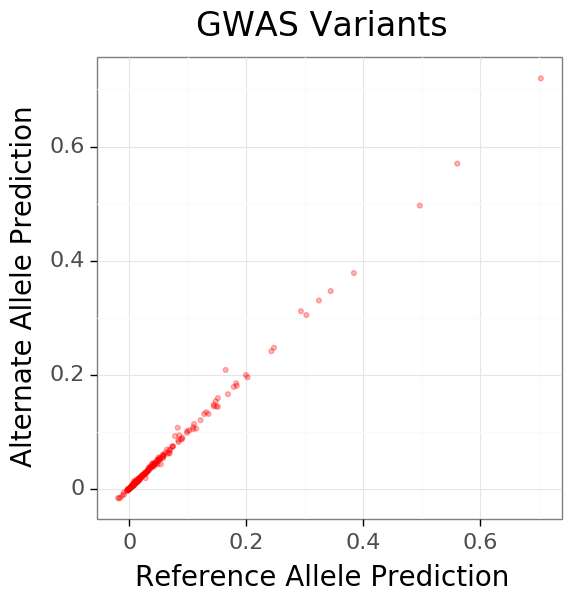

<ggplot: (-9223363251148554103)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
189,chr3,182763016,182763017,rs13088830,C,T,6.592040e-05,0.092522,0.023363,Y,0.053643,0.042885,-0.010757
155,chr3,182754694,182754695,rs10937110,A,C,7.920580e-01,0.009584,0.036311,Y,0.027625,0.018389,-0.009236
84,chr3,182733547,182733548,rs12486983,C,T,3.602720e-08,-0.117957,0.021583,Y,0.114171,0.105272,-0.008899
191,chr3,182763652,182763653,rs3772721,A,C,9.513320e-01,0.003558,0.058394,Y,0.151198,0.143571,-0.007627
11,chr3,182707806,182707807,rs77763419,A,G,8.886890e-01,-0.007030,0.050185,Y,0.068881,0.061861,-0.007020
98,chr3,182736304,182736305,rs11917378,A,G,7.830270e-01,-0.010022,0.036351,Y,0.201879,0.195111,-0.006768
153,chr3,182754453,182754454,rs182394799,A,G,3.283210e-01,-0.698055,0.666530,Y,0.048222,0.042574,-0.005648
162,chr3,182757178,182757179,rs9861464,C,T,6.336050e-01,0.017248,0.036114,Y,0.383712,0.378078,-0.005634
129,chr3,182748495,182748496,rs10937108,A,T,4.053010e-10,-0.150923,0.024465,Y,0.109153,0.104239,-0.004914
139,chr3,182751130,182751131,rs4859265,A,G,6.576890e-01,-0.016039,0.036130,Y,0.067532,0.063314,-0.004218


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
100,chr3,182736611,182736612,rs11917464,A,G,6.689850e-01,-0.015642,0.036519,Y,0.147429,0.153275,0.005846
33,chr3,182719224,182719225,rs1979984,C,T,6.088530e-01,0.017972,0.035049,Y,0.323981,0.329980,0.005999
154,chr3,182754574,182754575,rs10937109,A,G,6.397410e-01,-0.016941,0.036122,Y,0.151202,0.158785,0.007583
66,chr3,182729103,182729104,rs12496089,G,T,9.055830e-01,-0.006024,0.050753,Y,0.085170,0.093695,0.008526
69,chr3,182729531,182729532,rs77687927,G,T,8.083060e-01,-0.041156,0.170430,Y,0.560435,0.569998,0.009563
41,chr3,182721367,182721368,rs76575391,C,G,7.271710e-01,-0.020656,0.059355,Y,0.077985,0.092238,0.014253
62,chr3,182728181,182728182,rs4074310,G,T,1.454780e-11,0.162319,0.024386,Y,0.703335,0.719485,0.016149
50,chr3,182725046,182725047,rs76823265,C,G,7.680770e-01,0.017398,0.059124,Y,0.293170,0.311181,0.018011
49,chr3,182724406,182724407,rs6791884,A,G,6.003890e-09,-0.119866,0.020751,Y,0.082568,0.106802,0.024234
102,chr3,182737509,182737510,rs6443842,A,G,6.769160e-01,-0.015084,0.036138,Y,0.164492,0.208144,0.043652


FOLD:  3
All SNPs:


(90, 12)

SNPs NOT in Peaks:


(90, 12)

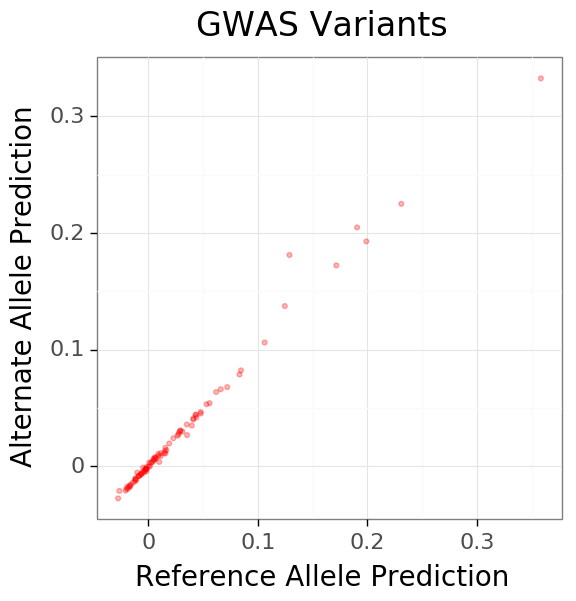

<ggplot: (-9223363251148511414)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
11,chr6,27671598,27671599,rs149417812,C,T,0.840737,-0.024350,0.120784,Y,0.358257,0.332541,-0.025716
49,chr6,27679125,27679126,rs73389013,C,G,0.469550,0.291358,0.421535,Y,0.035450,0.026893,-0.008557
42,chr6,27676854,27676855,rs61025649,C,T,0.305882,-0.131009,0.130237,Y,0.010059,0.003914,-0.006145
14,chr6,27671825,27671826,rs13192965,A,G,0.433870,-0.026299,0.033509,Y,0.198992,0.192866,-0.006126
13,chr6,27671662,27671663,rs112219934,A,G,0.754505,0.113176,0.367971,Y,0.230922,0.225046,-0.005876
32,chr6,27675124,27675125,rs78996076,A,C,0.533804,-0.049045,0.079322,Y,0.039778,0.034991,-0.004787
27,chr6,27674483,27674484,rs16867923,C,G,0.825084,-0.041457,0.186595,Y,0.015716,0.011160,-0.004556
61,chr6,27681037,27681038,rs73389015,A,G,0.469753,-0.291216,0.421511,Y,0.083283,0.078853,-0.004430
4,chr6,27670599,27670600,rs138542729,C,G,0.836961,0.024944,0.120816,Y,0.072094,0.068004,-0.004090
53,chr6,27679545,27679546,rs9468197,A,G,0.024338,-0.207894,0.089915,Y,0.014477,0.011429,-0.003049


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
26,chr6,27674326,27674327,rs78523698,C,T,1.335780e-01,-0.092829,0.061170,Y,0.006155,0.007973,0.001818
2,chr6,27670522,27670523,rs141690896,A,C,4.488100e-05,0.156259,0.037624,Y,0.004940,0.006816,0.001876
5,chr6,27670697,27670698,rs2393997,G,T,3.906920e-01,-0.025425,0.029698,Y,0.061946,0.063829,0.001883
38,chr6,27676309,27676310,rs9468195,A,G,2.258090e-08,0.118265,0.021004,Y,0.000854,0.003403,0.002549
51,chr6,27679445,27679446,rs9368527,A,C,7.567050e-05,-0.077616,0.019555,Y,-0.004677,-0.001004,0.003673
81,chr6,27684507,27684508,rs72845876,A,G,5.838400e-01,0.025693,0.047039,Y,-0.010071,-0.005304,0.004767
85,chr6,27685158,27685159,rs74783880,C,T,1.795560e-02,0.087005,0.036404,Y,-0.026332,-0.020900,0.005433
12,chr6,27671657,27671658,rs6930169,G,T,2.063250e-01,0.097462,0.078000,Y,0.124626,0.137474,0.012849
10,chr6,27671590,27671591,rs140187308,C,T,3.423050e-01,0.177072,0.183344,Y,0.190608,0.204840,0.014233
9,chr6,27671457,27671458,rs77032218,A,G,5.914630e-02,0.064289,0.034317,Y,0.128893,0.181251,0.052358


FOLD:  5
All SNPs:


(2339, 12)

SNPs in Peaks:


(56, 12)

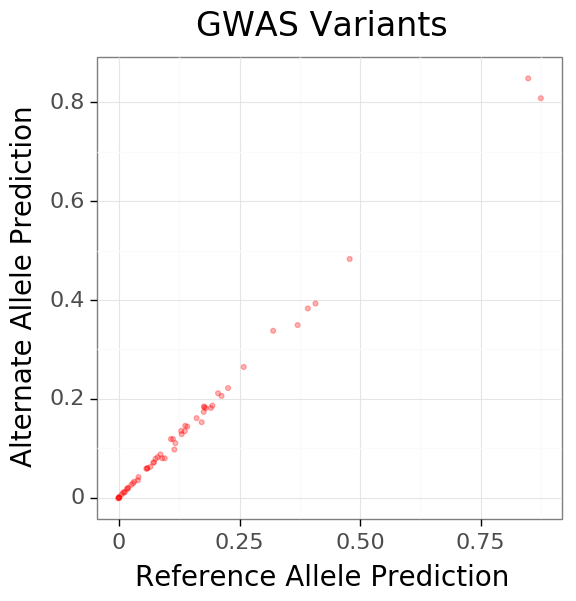

<ggplot: (8785706208674)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
34,chr4,986736,986737,rs115548745,A,G,0.814718,-0.148069,0.623177,Y,0.874960,0.808590,-0.066370
18,chr4,957778,957779,rs2335500,A,G,0.961210,-0.002649,0.054401,Y,0.370525,0.349172,-0.021353
46,chr4,987673,987674,rs3806759,A,G,0.644937,0.015097,0.032813,Y,0.171428,0.152450,-0.018978
16,chr4,957356,957357,rs75854631,A,G,0.106170,0.080468,0.050315,Y,0.114807,0.097122,-0.017685
12,chr4,876141,876142,rs10902760,C,G,0.522973,-0.027015,0.042157,Y,0.094894,0.079407,-0.015487
21,chr4,958306,958307,rs114739803,C,T,0.804092,0.024863,0.099980,Y,0.407582,0.392783,-0.014799
1,chr4,874986,874987,rs3775131,C,T,0.419328,0.039773,0.049009,Y,0.089617,0.079544,-0.010073
45,chr4,987663,987664,rs3806758,C,G,0.100219,-0.037952,0.023033,Y,0.190561,0.181352,-0.009209
32,chr4,973741,973742,rs145338564,C,T,0.159382,-0.155103,0.112275,Y,0.391728,0.382927,-0.008802
19,chr4,958090,958091,rs34406303,C,G,0.005279,0.096682,0.035040,Y,0.193822,0.185957,-0.007866


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
17,chr4,957598,957599,rs192259574,A,C,0.763904,-0.179317,0.585179,Y,0.478464,0.483079,0.004615
25,chr4,960081,960082,rs4690324,A,G,0.761109,0.007708,0.025337,Y,0.177194,0.182720,0.005525
20,chr4,958274,958275,rs145640981,A,C,0.321660,-0.147428,0.151537,Y,0.258759,0.264307,0.005548
11,chr4,875994,875995,rs2279185,C,G,0.554847,-0.024914,0.042066,Y,0.205479,0.211083,0.005604
23,chr4,959063,959064,rs143484618,A,G,0.121640,0.175635,0.116098,Y,0.128908,0.134879,0.005971
47,chr4,987704,987705,rs3806760,A,G,0.584788,0.011547,0.021144,Y,0.111918,0.118465,0.006547
30,chr4,973371,973372,rs10008164,A,G,0.432413,-0.351977,0.429125,Y,0.137309,0.145143,0.007834
33,chr4,986484,986485,rs28536019,C,T,0.424109,0.362625,0.433452,Y,0.176250,0.184292,0.008042
15,chr4,876399,876400,rs3736086,C,T,0.520761,-0.027152,0.042145,Y,0.107630,0.118294,0.010663
27,chr4,960542,960543,rs35117553,G,T,0.236550,0.057519,0.048939,Y,0.319851,0.337577,0.017726


SNPs NOT in Peaks:


(2283, 12)

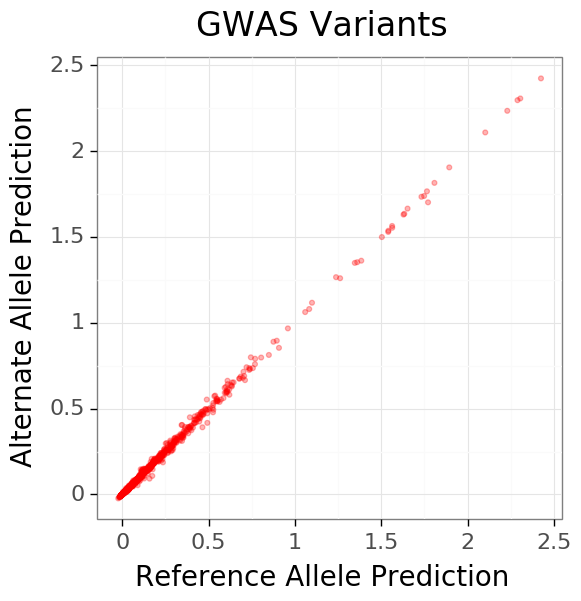

<ggplot: (-9223363251148609031)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
514,chr4,90554583,90554584,rs60949932,A,G,3.959100e-01,-0.327624,0.403171,Y,0.492774,0.416805,-0.075969
175,chr4,952009,952010,rs140597786,C,T,1.328630e-02,-0.421012,0.179248,Y,0.464575,0.391077,-0.073498
207,chr4,956364,956365,rs61757581,C,G,4.205890e-01,0.100553,0.126414,Y,1.770627,1.700119,-0.070508
1015,chr4,90655322,90655323,rs79613539,A,G,3.699850e-01,0.094174,0.106367,Y,0.174261,0.108047,-0.066214
265,chr4,975565,975566,rs114865405,A,G,4.198930e-01,0.158328,0.200142,Y,0.158284,0.092172,-0.066112
1593,chr4,90759047,90759048,rs2619363,G,T,1.427720e-08,0.117808,0.020641,Y,0.907617,0.853372,-0.054246
769,chr4,90607077,90607078,rs10029694,C,G,6.572040e-04,0.099345,0.029465,Y,0.235930,0.186830,-0.049101
1589,chr4,90758389,90758390,rs2301135,C,G,1.585330e-01,-0.026366,0.018701,Y,0.525991,0.478208,-0.047783
1152,chr4,90684123,90684124,rs35495602,A,G,2.969060e-21,0.353759,0.036066,Y,0.711006,0.665514,-0.045492
1271,chr4,90709594,90709595,rs115322031,C,T,3.383940e-02,-0.168068,0.080846,Y,0.620529,0.580420,-0.040109


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
330,chr4,77173914,77173915,rs13117238,A,C,2.443280e-03,-0.075207,0.024655,Y,0.533400,0.572061,0.038661
473,chr4,90522084,90522085,rs183851917,A,G,1.762410e-02,0.283012,0.123434,Y,0.107115,0.146796,0.039681
601,chr4,90574806,90574807,rs3846288,A,C,2.811430e-02,0.082683,0.038028,Y,0.257715,0.299325,0.041610
1353,chr4,90725487,90725488,rs149360914,A,C,6.364840e-01,-0.111872,0.233172,Y,0.251921,0.296701,0.044780
80,chr4,906903,906904,rs6842808,C,T,2.807460e-06,0.134106,0.028264,Y,0.609720,0.661928,0.052207
2024,chr4,90837532,90837533,rs3775472,A,C,1.171570e-06,-0.195925,0.039467,Y,0.744784,0.798276,0.053491
1258,chr4,90705960,90705961,rs143963281,C,T,4.412930e-01,-0.157300,0.208153,Y,0.391830,0.449277,0.057447
301,chr4,983809,983810,rs4690221,C,T,3.019550e-07,-0.098629,0.019313,Y,0.346989,0.404579,0.057589
867,chr4,90629342,90629343,rs190945966,C,T,9.729200e-01,-0.006007,0.176438,Y,0.343739,0.404356,0.060618
60,chr4,901982,901983,rs190834547,A,G,6.898110e-01,-0.056041,0.139568,Y,0.489737,0.552424,0.062687


FOLD:  7
All SNPs:


(5222, 12)

SNPs in Peaks:


(473, 12)

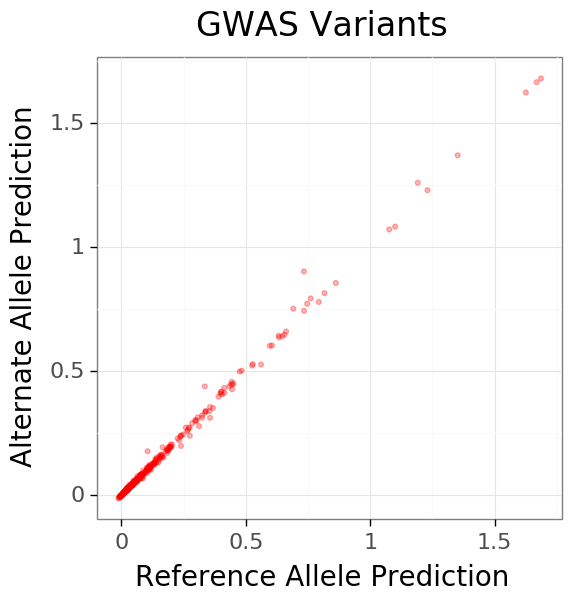

<ggplot: (8785706100200)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
285,chr17,44065669,44065670,rs919461,A,T,2.191480e-22,-0.228224,0.023915,Y,0.356160,0.312768,-0.043392
250,chr17,44014137,44014138,rs12150460,G,T,4.038280e-22,-0.226906,0.023926,Y,0.239490,0.199194,-0.040296
286,chr17,44065708,44065709,rs73317007,A,C,8.477580e-01,-0.045126,0.236176,Y,0.275163,0.240435,-0.034728
261,chr17,44024552,44024553,rs62062784,C,G,3.332810e-22,-0.227322,0.023922,Y,0.561160,0.527436,-0.033723
195,chr17,43938634,43938635,rs62054846,A,G,3.319000e-22,-0.227452,0.023934,Y,0.311995,0.279273,-0.032721
80,chr17,43779419,43779420,rs17688944,A,T,2.071310e-22,0.228691,0.023950,Y,0.086646,0.067747,-0.018900
2,chr17,43394569,43394570,rs115344032,C,G,1.227880e-03,0.301428,0.089844,Y,1.100368,1.083359,-0.017009
175,chr17,43909715,43909716,rs138693258,A,G,6.833910e-01,0.150703,0.375633,Y,0.444765,0.427756,-0.017009
371,chr17,44168508,44168509,rs111364350,C,T,2.574080e-22,-0.227827,0.023912,Y,0.168965,0.152166,-0.016799
86,chr17,43784777,43784778,rs1617406,A,G,1.859130e-03,0.075138,0.023992,Y,0.119046,0.102678,-0.016368


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
210,chr17,43983801,43983802,rs62056806,A,G,3.939880e-22,-0.226704,0.023898,Y,0.413348,0.433352,0.020004
337,chr17,44121847,44121848,rs140022642,A,C,1.786490e-01,-0.273722,0.196748,Y,0.475167,0.499017,0.023850
198,chr17,43938997,43938998,rs734629,A,C,7.653870e-01,0.144327,0.475459,Y,0.746661,0.772103,0.025442
389,chr17,44199670,44199671,rs62061855,A,G,7.115390e-22,0.225965,0.023969,Y,0.165467,0.193907,0.028441
264,chr17,44024865,44024866,rs62062787,C,T,3.317200e-22,0.227330,0.023921,Y,0.760995,0.793811,0.032816
262,chr17,44024562,44024563,rs62062785,G,T,3.333700e-22,-0.227320,0.023921,Y,0.690765,0.752471,0.061705
20,chr17,43483774,43483775,rs1230101,A,G,1.069460e-02,-0.051516,0.020132,Y,1.191123,1.259924,0.068801
274,chr17,44043265,44043266,rs182397490,C,T,6.651150e-03,0.476457,0.167038,Y,0.105219,0.177898,0.072680
338,chr17,44121917,44121918,rs77768866,C,T,2.510300e-22,-0.227852,0.023909,Y,0.335213,0.438945,0.103732
89,chr17,43784994,43784995,rs62056913,C,T,2.273570e-22,-0.228491,0.023952,Y,0.733809,0.902648,0.168838


SNPs NOT in Peaks:


(4749, 12)

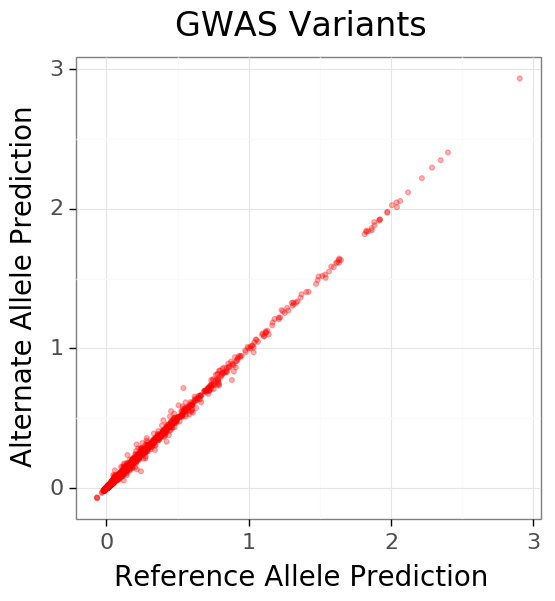

<ggplot: (-9223363251148603574)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
1176,chr17,43805590,43805591,rs62054388,C,T,3.345750e-22,-0.227387,0.023931,Y,0.242951,0.121743,-0.121207
1660,chr17,43881790,43881791,rs17689378,C,T,1.992770e-22,-0.228606,0.023931,Y,0.882259,0.774467,-0.107792
3014,chr17,44081527,44081528,rs62064665,C,T,2.110720e-22,0.228320,0.023915,Y,0.422692,0.333817,-0.088875
3813,chr17,44208312,44208313,rs6503457,G,T,5.165140e-21,-0.218345,0.023643,Y,0.213603,0.136243,-0.077361
33,chr17,43419848,43419849,rs116054740,A,G,1.619000e-01,0.102053,0.072051,Y,0.341537,0.273078,-0.068458
240,chr17,43504217,43504218,rs73307518,C,T,8.362310e-02,0.053452,0.030742,Y,0.122066,0.055854,-0.066212
3379,chr17,44144214,44144215,rs2301732,C,T,6.752360e-01,0.041674,0.100034,Y,0.608302,0.542651,-0.065650
4658,chr17,44843063,44843064,rs185661065,C,G,6.751550e-01,-0.100766,0.237627,Y,1.035129,0.972468,-0.062661
1695,chr17,43892600,43892601,rs242940,A,G,6.529650e-07,0.093336,0.018756,Y,0.895973,0.834635,-0.061338
2089,chr17,43945687,43945688,rs62055477,A,C,3.862230e-22,0.226898,0.023913,Y,0.273464,0.213820,-0.059644


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
2113,chr17,43947867,43947868,rs113380413,G,T,3.658110e-20,0.243724,0.027045,Y,0.446640,0.512933,0.066293
1675,chr17,43886904,43886905,rs74370049,A,G,1.779730e-01,0.100561,0.075612,Y,0.059378,0.127855,0.068477
3742,chr17,44196153,44196154,rs1468241,A,G,2.688840e-22,-0.227721,0.023912,Y,0.252451,0.324347,0.071896
2810,chr17,44053171,44053172,rs62063777,A,G,2.280540e-22,-0.228155,0.023917,Y,0.284097,0.360134,0.076038
4,chr17,43395391,43395392,rs144816933,A,G,1.323570e-03,-0.299743,0.089959,Y,0.507218,0.593569,0.086351
4655,chr17,44839655,44839656,rs147500870,C,T,5.458630e-01,-0.113214,0.185232,Y,0.400025,0.486471,0.086447
3162,chr17,44105861,44105862,rs114542437,A,C,2.785290e-01,0.139420,0.126383,Y,0.147831,0.237939,0.090108
3077,chr17,44091417,44091418,rs118109282,C,T,3.766400e-01,-0.087599,0.100243,Y,0.454554,0.551885,0.097331
3333,chr17,44134984,44134985,rs62060768,A,G,2.509110e-22,0.227852,0.023909,Y,0.211727,0.313454,0.101726
3380,chr17,44144234,44144235,rs117385703,C,T,9.072530e-01,-0.005888,0.050503,Y,0.541459,0.717195,0.175736


FOLD:  8
All SNPs:


(4093, 12)

SNPs in Peaks:


(136, 12)

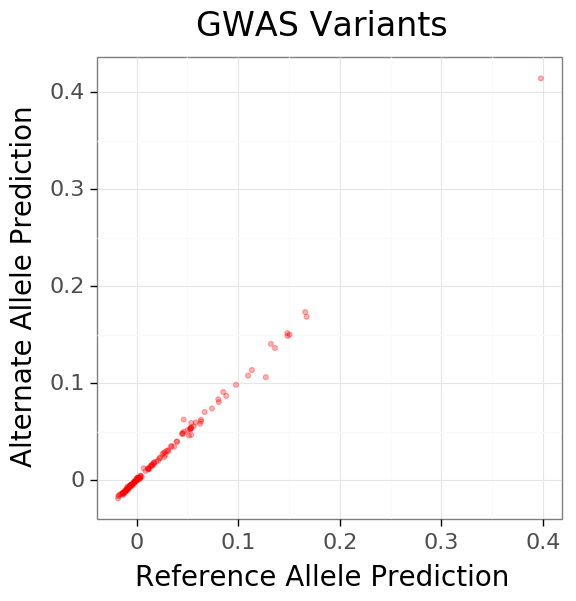

<ggplot: (8785708352127)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
77,chr12,41408740,41408741,rs35862989,A,T,0.045786,-0.086695,0.043869,Y,0.127120,0.106081,-0.021039
60,chr12,41312147,41312148,rs1372543,A,G,0.509090,-0.031469,0.047479,Y,0.053613,0.046658,-0.006955
76,chr12,41408603,41408604,rs78037279,C,T,0.472893,0.188869,0.257034,Y,0.051483,0.045857,-0.005626
129,chr12,123268840,123268841,rs2454699,C,T,0.990383,0.001419,0.117667,Y,0.062395,0.058052,-0.004343
58,chr12,41311589,41311590,rs10784949,A,G,0.319568,0.019300,0.019403,Y,0.027293,0.023735,-0.003558
127,chr12,123268734,123268735,rs12305822,C,T,0.107831,0.065615,0.040488,Y,0.063346,0.060513,-0.002833
23,chr12,40656677,40656678,rs17443552,A,C,0.000013,-0.112639,0.025625,Y,0.037006,0.034391,-0.002615
110,chr12,42145513,42145514,rs7978010,A,C,0.211876,-0.047986,0.038224,Y,0.028231,0.026019,-0.002213
88,chr12,41459242,41459243,rs181012052,C,T,0.683461,0.066059,0.160853,Y,0.109660,0.107716,-0.001943
11,chr12,40335821,40335822,rs112324988,C,T,0.467069,0.090835,0.126362,Y,-0.012949,-0.014873,-0.001924


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
57,chr12,41311466,41311467,rs11179042,C,T,0.294138,0.019780,0.018850,Y,0.045135,0.048358,0.003223
26,chr12,40794293,40794294,rs3899331,C,T,0.000299,0.206755,0.055769,Y,0.066857,0.070148,0.003291
135,chr12,123269814,123269815,rs1696320,A,G,0.908744,-0.003324,0.028990,Y,0.046684,0.050038,0.003354
90,chr12,41460146,41460147,rs280378,A,C,0.755566,-0.094502,0.307340,Y,0.053739,0.058873,0.005133
91,chr12,41460500,41460501,rs280377,C,T,0.755564,0.094481,0.307266,Y,0.006875,0.012126,0.005251
55,chr12,41311370,41311371,rs11179040,G,T,0.296227,-0.019698,0.018853,Y,0.085142,0.090808,0.005666
56,chr12,41311418,41311419,rs10506179,C,T,0.318796,0.019336,0.019409,Y,0.165965,0.173262,0.007297
89,chr12,41459908,41459909,rs280379,C,T,0.991462,-0.002761,0.258370,Y,0.132148,0.140378,0.008231
54,chr12,41311339,41311340,rs187801857,A,T,0.516318,-0.192545,0.304514,Y,0.046308,0.062326,0.016018
63,chr12,41312642,41312643,rs144175278,C,T,0.075208,0.152721,0.084239,Y,0.397916,0.414111,0.016195


SNPs NOT in Peaks:


(3957, 12)

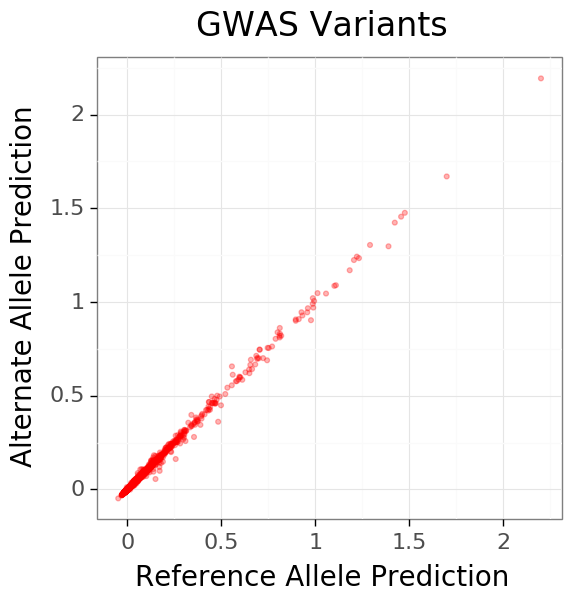

<ggplot: (8785706023958)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
3925,chr12,123337761,123337762,rs12298151,A,G,6.186260e-01,-0.019407,0.038896,Y,0.482921,0.361158,-0.121763
1937,chr12,40736885,40736886,rs150954733,A,C,7.282880e-05,-0.493979,0.119268,Y,0.256879,0.162247,-0.094632
2116,chr12,40832536,40832537,rs11176638,C,G,7.431780e-02,-0.033684,0.018884,Y,0.149408,0.055649,-0.093759
3884,chr12,123326598,123326599,rs10847864,G,T,7.060470e-14,0.153126,0.020362,Y,1.389823,1.297047,-0.092776
1305,chr12,37961304,37961305,rs1842606,C,T,9.250810e-01,0.001810,0.019248,Y,0.354365,0.279997,-0.074367
1943,chr12,40737240,40737241,rs4768232,C,T,1.455780e-01,-0.038183,0.026144,Y,0.977004,0.902868,-0.074135
2117,chr12,40832573,40832574,rs10878586,C,T,7.362080e-02,0.033763,0.018883,Y,0.171547,0.099252,-0.072295
3489,chr12,43046526,43046527,rs11181615,C,T,8.544260e-01,-0.003713,0.020243,Y,0.743351,0.689012,-0.054339
3945,chr12,123341692,123341693,rs150109184,C,T,9.860220e-01,0.004695,0.267387,Y,0.308939,0.258206,-0.050733
1908,chr12,40732123,40732124,rs4767972,C,T,1.455140e-01,-0.038195,0.026148,Y,0.170006,0.119829,-0.050177


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
987,chr12,34242463,34242464,rs10772144,A,C,0.764126,0.005767,0.019223,Y,0.068226,0.106749,0.038523
3902,chr12,123329737,123329738,rs56272219,A,G,0.592485,0.020869,0.038893,Y,0.799189,0.838144,0.038955
2191,chr12,40840844,40840845,rs79338363,G,T,0.801284,-0.047412,0.187245,Y,0.704376,0.745274,0.040897
3890,chr12,123327445,123327446,rs12298664,C,T,0.613898,-0.024684,0.048777,Y,0.141033,0.182424,0.041392
3891,chr12,123327900,123327901,rs10773657,A,C,0.723608,-0.010514,0.029764,Y,0.703444,0.746388,0.042944
3048,chr12,41401999,41402000,rs10879518,C,G,0.075285,0.049666,0.027785,Y,0.448930,0.495943,0.047013
1579,chr12,40397235,40397236,rs28370644,C,T,0.063192,0.052799,0.028573,Y,0.811069,0.861364,0.050295
1940,chr12,40737075,40737076,rs17461964,C,T,0.145592,-0.038182,0.026144,Y,0.560548,0.611945,0.051397
1941,chr12,40737115,40737116,rs10784518,G,T,0.145578,-0.038183,0.026144,Y,0.340264,0.397620,0.057356
2958,chr12,41382767,41382768,rs12829443,A,C,0.577037,0.020507,0.036683,Y,0.556231,0.656502,0.100271


FOLD:  9
All SNPs:


(323, 12)

SNPs in Peaks:


(43, 12)

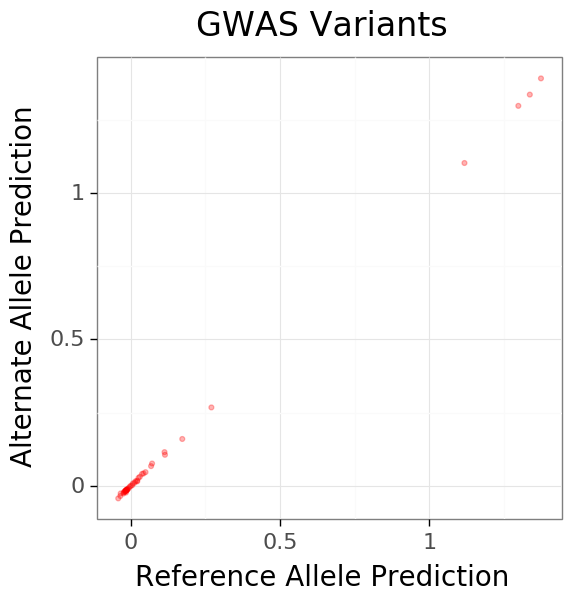

<ggplot: (8785706162040)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
9,chr10,121368348,121368349,rs115879160,G,T,8.644330e-01,-0.026199,0.153915,Y,1.117747,1.102964,-0.014783
42,chr10,121710488,121710489,rs118117788,C,T,2.147610e-08,0.403039,0.068671,Y,0.172245,0.160034,-0.012211
25,chr10,121460332,121460333,rs116984350,C,T,1.144750e-01,0.155602,0.100474,Y,0.114253,0.105967,-0.008286
28,chr10,121532890,121532891,rs144030311,A,G,9.665760e-01,0.008238,0.197415,Y,-0.016606,-0.023019,-0.006414
39,chr10,121709909,121709910,rs7914591,C,T,7.836850e-01,0.005418,0.019742,Y,0.021426,0.015245,-0.006181
34,chr10,121536635,121536636,rs72826422,C,G,6.396350e-02,-0.071163,0.038100,Y,0.020933,0.017464,-0.003468
16,chr10,121369014,121369015,rs12416614,C,T,8.480300e-01,-0.032586,0.170783,Y,0.004692,0.002060,-0.002632
13,chr10,121368582,121368583,rs142590307,C,T,8.750460e-01,0.034921,0.222869,Y,0.049200,0.046695,-0.002505
22,chr10,121458911,121458912,rs192486997,C,T,2.886300e-01,-0.151916,0.146046,Y,0.012462,0.010351,-0.002111
8,chr10,121368169,121368170,rs11199044,A,C,7.399010e-01,0.013698,0.041330,Y,0.269750,0.267828,-0.001921


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
24,chr10,121459517,121459518,rs196229,A,C,0.048786,-0.039016,0.019830,Y,-0.018008,-0.016817,0.001191
7,chr10,121293035,121293036,rs4752325,G,T,0.368242,-0.017320,0.019261,Y,-0.014478,-0.013194,0.001283
15,chr10,121368873,121368874,rs145701507,C,T,0.583525,-0.159246,0.296942,Y,0.025660,0.027106,0.001446
17,chr10,121369051,121369052,rs7075463,A,C,0.730547,0.007336,0.021312,Y,0.006416,0.007864,0.001448
30,chr10,121533034,121533035,rs72826419,C,T,0.070181,0.069370,0.038003,Y,-0.023753,-0.022162,0.001591
40,chr10,121710444,121710445,rs2420792,A,G,0.651818,0.009404,0.020851,Y,0.112803,0.115121,0.002318
18,chr10,121369103,121369104,rs138715304,G,T,0.306950,-0.070275,0.069407,Y,0.037501,0.040762,0.003260
14,chr10,121368847,121368848,rs7075175,C,G,0.734674,-0.007222,0.021319,Y,0.071072,0.076173,0.005101
27,chr10,121532886,121532887,rs61867903,G,T,0.310642,-0.044365,0.043523,Y,-0.034117,-0.025947,0.008169
12,chr10,121368477,121368478,rs11199045,C,G,0.170513,0.030679,0.022435,Y,1.374106,1.392104,0.017998


SNPs NOT in Peaks:


(280, 12)

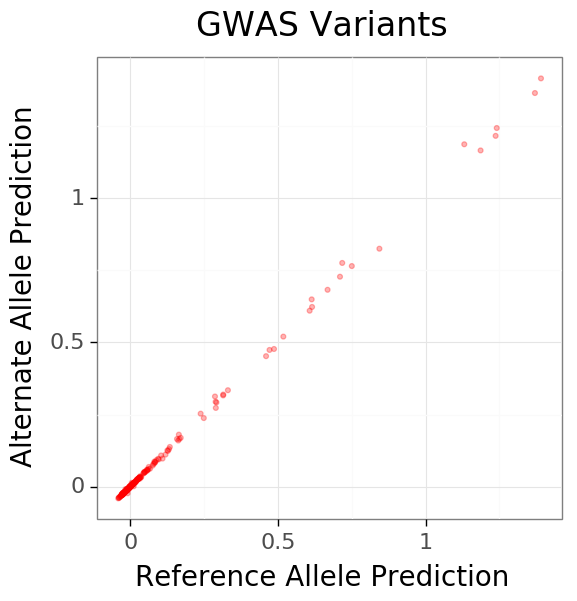

<ggplot: (8785706497442)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
82,chr10,121376917,121376918,rs11199049,A,G,0.145982,-0.030658,0.021127,Y,1.237395,1.215816,-0.021579
156,chr10,121462047,121462048,rs11199075,A,G,0.000274,0.080234,0.022175,Y,1.186437,1.165322,-0.021115
129,chr10,121414702,121414703,rs196337,C,T,0.981997,-0.000664,0.029428,Y,0.843715,0.824691,-0.019024
128,chr10,121414598,121414599,rs12250770,C,T,0.002635,-0.065469,0.021867,Y,0.289746,0.272864,-0.016882
202,chr10,121657445,121657446,rs190850399,A,G,0.195197,0.144371,0.109599,Y,-0.008907,-0.022975,-0.014067
251,chr10,121707175,121707176,rs117201436,C,T,0.937996,0.014033,0.179194,Y,0.109292,0.097284,-0.012008
22,chr10,121298412,121298413,rs10787977,C,T,0.500279,-0.018643,0.027707,Y,0.248985,0.237728,-0.011257
219,chr10,121659957,121659958,rs71482901,A,G,0.510371,-0.027022,0.040917,Y,0.011515,0.001307,-0.010207
200,chr10,121657050,121657051,rs7089740,A,G,0.760357,-0.010817,0.035422,Y,0.486818,0.477119,-0.009699
208,chr10,121658842,121658843,rs12257358,A,C,0.000735,0.077735,0.023169,Y,0.119366,0.111121,-0.008245


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
116,chr10,121410904,121410905,rs192502283,C,G,7.980900e-02,-0.183773,0.102930,Y,0.668230,0.682277,0.014047
117,chr10,121410917,121410918,rs144814361,C,T,3.133420e-11,0.468015,0.066748,Y,0.750293,0.764553,0.014260
130,chr10,121414758,121414759,rs11199061,A,C,4.053720e-01,0.032578,0.039303,Y,0.238377,0.252954,0.014576
37,chr10,121367763,121367764,rs17099080,C,T,1.689880e-01,0.030790,0.022437,Y,0.164545,0.180272,0.015728
84,chr10,121377046,121377047,rs11199050,C,T,4.296890e-01,-0.016900,0.021376,Y,0.710258,0.727636,0.017378
121,chr10,121412132,121412133,rs55725412,A,G,1.381180e-01,-0.030363,0.020508,Y,1.390950,1.414983,0.024033
26,chr10,121298690,121298691,rs112618631,C,G,6.944950e-02,-0.257034,0.145968,Y,0.286881,0.312514,0.025633
126,chr10,121414205,121414206,rs148789629,C,T,2.371360e-02,-0.361682,0.152992,Y,0.614389,0.649087,0.034699
198,chr10,121656067,121656068,rs35225459,A,G,5.061630e-01,-0.027262,0.040872,Y,1.131178,1.186633,0.055455
118,chr10,121411631,121411632,rs112168846,A,G,4.160340e-01,0.041580,0.051391,Y,0.717838,0.775318,0.057480


In [15]:
get_results_all_folds('PD_CTRL_SUNI')

TASK:  PD_GBA1_SUNI
FOLD:  0
All SNPs:


(446, 12)

SNPs in Peaks:


(38, 12)

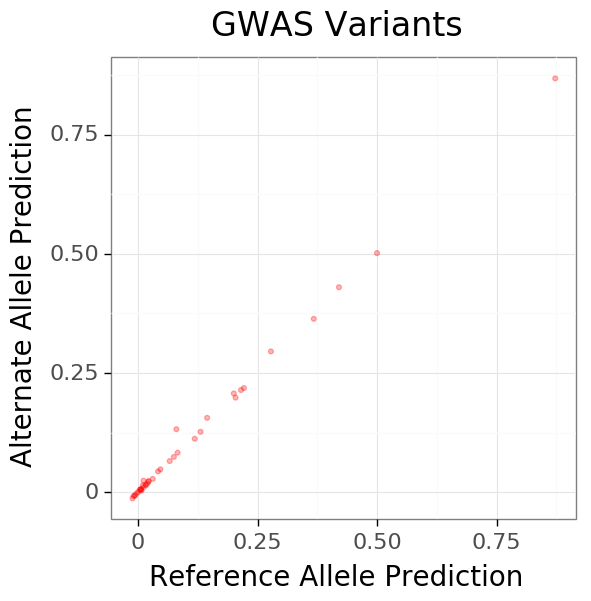

<ggplot: (8785706437419)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
14,chr1,155207626,155207627,rs2009578,A,G,8.822220e-01,0.003030,0.020456,Y,0.118708,0.112336,-0.006372
2,chr1,154984020,154984021,rs114875695,A,G,2.692070e-01,0.208802,0.194312,Y,0.204107,0.198498,-0.005608
34,chr1,205670726,205670727,rs823098,A,G,1.149620e-01,0.079276,0.050799,Y,0.872352,0.867641,-0.004711
30,chr1,155822914,155822915,rs79403246,A,G,2.195280e-01,-0.136976,0.113549,Y,0.007713,0.003538,-0.004175
13,chr1,155207549,155207550,rs762488,C,T,6.654640e-01,0.008818,0.020404,Y,0.130833,0.126910,-0.003924
9,chr1,155140023,155140024,rs114413971,A,C,3.267700e-01,0.045034,0.046174,Y,0.367540,0.363669,-0.003871
27,chr1,155822578,155822579,rs191848370,A,G,6.280000e-01,-0.087976,0.179494,Y,0.221485,0.218724,-0.002761
5,chr1,155135036,155135037,rs35749011,A,G,5.326700e-14,-0.536007,0.066947,Y,0.030918,0.028183,-0.002735
31,chr1,155822971,155822972,rs822490,C,T,1.005310e-01,-0.032386,0.019693,Y,0.016530,0.014542,-0.001988
24,chr1,155821773,155821774,rs4971064,C,T,5.157930e-01,-0.028345,0.043468,Y,-0.011409,-0.012677,-0.001267


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
35,chr1,205670871,205670872,rs12751694,A,G,0.791609,0.051321,0.195357,Y,0.499732,0.501476,0.001744
15,chr1,155207733,155207734,rs28678003,C,T,0.435811,-0.035557,0.045825,Y,0.041953,0.043805,0.001852
12,chr1,155207367,155207368,rs74500255,A,T,0.201524,1.753920,1.169310,Y,0.021877,0.023767,0.001890
17,chr1,155207985,155207986,rs74462743,C,T,0.144436,2.080070,1.183400,Y,0.010363,0.014820,0.004457
28,chr1,155822629,155822630,rs112685832,A,C,0.260298,0.037156,0.033118,Y,0.200365,0.207267,0.006902
10,chr1,155140027,155140028,rs12131522,C,T,0.958053,0.000990,0.018828,Y,0.420193,0.429899,0.009705
37,chr1,205671167,205671168,rs1417725,A,G,0.022548,0.114527,0.050882,Y,0.144607,0.156117,0.011510
18,chr1,155208006,155208007,rs364897,C,T,0.200427,-1.170800,0.809268,Y,0.011600,0.024434,0.012834
19,chr1,155208361,155208362,rs147138516,C,G,0.014743,1.417620,0.495539,Y,0.278021,0.295362,0.017340
33,chr1,205670369,205670370,rs6673687,A,T,0.000008,-0.086770,0.019520,Y,0.080328,0.132327,0.051999


SNPs NOT in Peaks:


(408, 12)

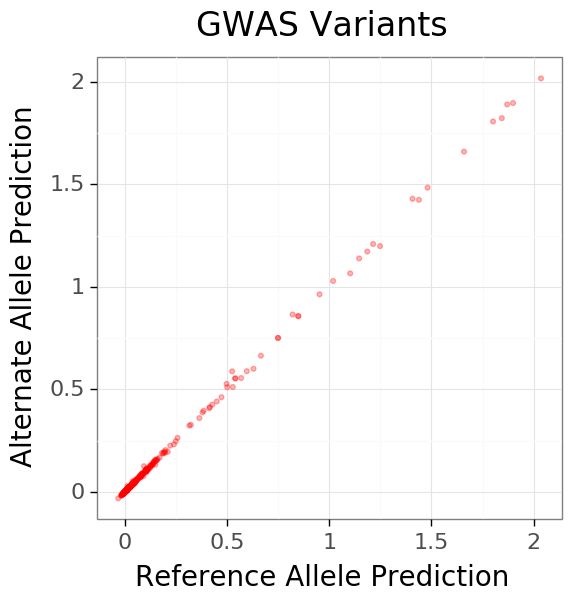

<ggplot: (-9223363251148445731)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
79,chr1,155108287,155108288,rs11264333,A,G,8.009820e-02,0.033430,0.019119,Y,1.248772,1.199030,-0.049742
316,chr1,205718858,205718859,rs7536483,A,T,4.290230e-02,0.038184,0.018846,Y,1.102514,1.066001,-0.036514
2,chr1,154909268,154909269,rs1109815,A,G,7.673580e-01,0.005605,0.018944,Y,0.629708,0.600787,-0.028921
85,chr1,155113074,155113075,rs12745576,A,C,9.734980e-01,-0.001967,0.059259,Y,1.844234,1.822872,-0.021362
322,chr1,205719857,205719858,rs865402,A,T,8.008280e-02,0.087904,0.050790,Y,2.035832,2.016784,-0.019048
143,chr1,155138842,155138843,rs75925257,A,G,1.292430e-01,0.048115,0.031862,Y,0.528222,0.511927,-0.016295
157,chr1,155205378,155205379,rs12752133,C,T,1.240970e-13,0.553975,0.070121,Y,0.148566,0.132790,-0.015776
398,chr1,205741426,205741427,rs823141,C,T,3.127230e-02,-0.040563,0.018821,Y,0.210325,0.196167,-0.014157
11,chr1,154911651,154911652,rs4845694,C,G,7.796100e-01,0.005313,0.018987,Y,0.091542,0.077504,-0.014038
58,chr1,154990297,154990298,rs2242194,C,G,7.571440e-01,-0.006030,0.019504,Y,1.438678,1.424778,-0.013900


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
314,chr1,205718468,205718469,rs12047038,A,G,0.001904,-0.067468,0.021833,Y,0.541066,0.553297,0.012231
154,chr1,155204987,155204988,rs80356771,A,G,0.000951,-1.467910,0.383923,Y,0.539135,0.554147,0.015013
238,chr1,155416616,155416617,rs192176580,A,G,0.911166,0.072908,0.659427,Y,0.037346,0.053119,0.015774
223,chr1,155412037,155412038,rs11264371,C,T,0.578178,0.012187,0.021899,Y,0.011979,0.028546,0.016567
86,chr1,155113104,155113105,rs4971073,G,T,0.084931,-0.033555,0.019501,Y,1.870426,1.889666,0.019241
4,chr1,154910012,154910013,rs877343,A,G,0.762849,0.005721,0.018957,Y,1.407423,1.429320,0.021897
1,chr1,154909210,154909211,rs181302437,C,T,0.703779,0.054683,0.142852,Y,0.497793,0.527524,0.029732
404,chr1,205743502,205743503,rs11803735,A,G,0.416137,0.082596,0.102687,Y,0.093428,0.125731,0.032303
315,chr1,205718810,205718811,rs12727532,C,T,0.454834,-0.208047,0.284532,Y,0.820463,0.865442,0.044979
0,chr1,154909169,154909170,rs17356361,C,T,0.276788,0.055702,0.050864,Y,0.524853,0.588354,0.063502


FOLD:  1
All SNPs:


(313, 12)

SNPs in Peaks:


(9, 12)

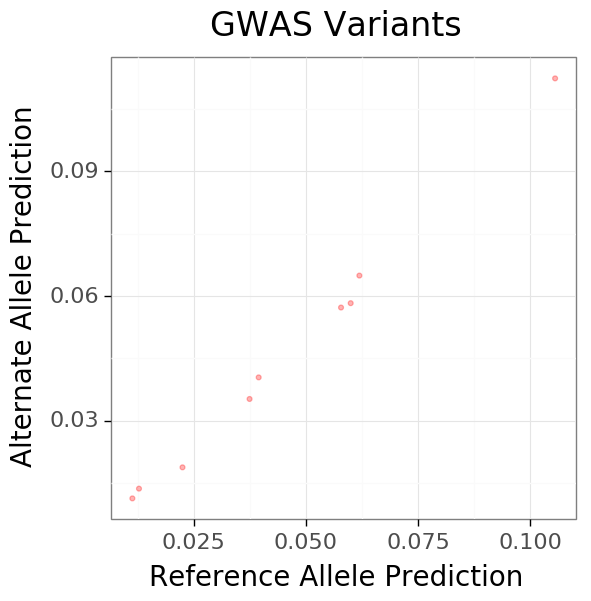

<ggplot: (-9223363251145043831)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
0,chr2,169109956,169109957,rs13002388,A,G,6.338120e-01,-0.012918,0.027152,Y,0.022477,0.018777,-0.003700
5,chr2,169131135,169131136,rs183501421,C,T,3.234590e-01,-0.195448,0.202374,Y,0.037426,0.035234,-0.002192
2,chr2,169110422,169110423,rs147610000,C,T,5.147330e-02,-0.088236,0.045731,Y,0.059967,0.058296,-0.001671
1,chr2,169110394,169110395,rs1474055,C,T,1.112500e-11,0.184632,0.026727,Y,0.057817,0.057246,-0.000571
8,chr2,169132643,169132644,rs67058614,D,I,3.756770e-01,0.024522,0.027746,Y,0.011301,0.011301,0.000000
7,chr2,169132611,169132612,rs77548116,C,T,7.952470e-01,0.012166,0.046951,Y,0.012776,0.013649,0.000873
6,chr2,169131721,169131722,rs955896,A,T,3.743930e-01,0.024463,0.027606,Y,0.039457,0.040431,0.000974
4,chr2,169110621,169110622,rs12622375,A,G,2.420800e-03,-0.057436,0.018949,Y,0.061905,0.064936,0.003031
3,chr2,169110500,169110501,rs12474289,A,G,7.941460e-01,0.128192,0.499616,Y,0.105538,0.112408,0.006870


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
0,chr2,169109956,169109957,rs13002388,A,G,6.338120e-01,-0.012918,0.027152,Y,0.022477,0.018777,-0.003700
5,chr2,169131135,169131136,rs183501421,C,T,3.234590e-01,-0.195448,0.202374,Y,0.037426,0.035234,-0.002192
2,chr2,169110422,169110423,rs147610000,C,T,5.147330e-02,-0.088236,0.045731,Y,0.059967,0.058296,-0.001671
1,chr2,169110394,169110395,rs1474055,C,T,1.112500e-11,0.184632,0.026727,Y,0.057817,0.057246,-0.000571
8,chr2,169132643,169132644,rs67058614,D,I,3.756770e-01,0.024522,0.027746,Y,0.011301,0.011301,0.000000
7,chr2,169132611,169132612,rs77548116,C,T,7.952470e-01,0.012166,0.046951,Y,0.012776,0.013649,0.000873
6,chr2,169131721,169131722,rs955896,A,T,3.743930e-01,0.024463,0.027606,Y,0.039457,0.040431,0.000974
4,chr2,169110621,169110622,rs12622375,A,G,2.420800e-03,-0.057436,0.018949,Y,0.061905,0.064936,0.003031
3,chr2,169110500,169110501,rs12474289,A,G,7.941460e-01,0.128192,0.499616,Y,0.105538,0.112408,0.006870


SNPs NOT in Peaks:


(304, 12)

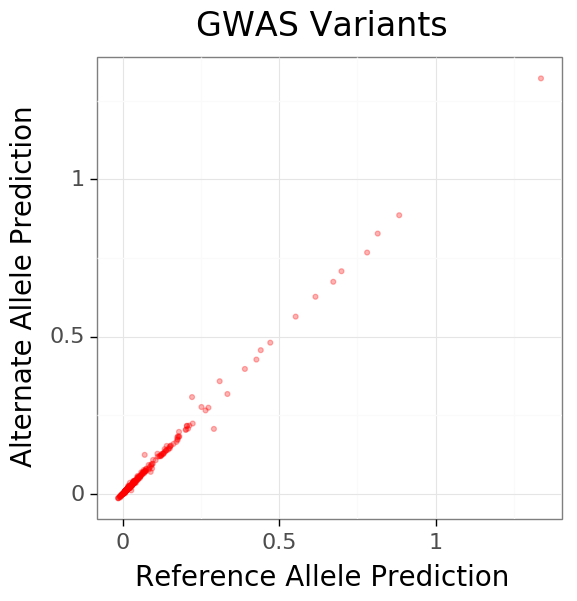

<ggplot: (8785706653290)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
86,chr2,169106699,169106700,rs74271810,C,G,0.994382,-0.000962,0.136617,Y,0.291826,0.207235,-0.084591
167,chr2,169135172,169135173,rs72623172,C,T,0.884466,-0.018818,0.129187,Y,0.089878,0.070710,-0.019168
11,chr2,169088635,169088636,rs10177444,A,G,0.001815,0.059667,0.019138,Y,0.335012,0.318178,-0.016834
145,chr2,169125080,169125081,rs11904323,A,C,0.652522,0.012301,0.027351,Y,0.027867,0.011912,-0.015955
80,chr2,169104348,169104349,rs181364589,A,T,0.755929,0.060341,0.195246,Y,1.336787,1.321071,-0.015716
221,chr2,169150945,169150946,rs2203704,C,T,0.044228,-0.037655,0.018713,Y,0.781342,0.767682,-0.013660
219,chr2,169150589,169150590,rs7563871,A,G,0.044636,-0.037586,0.018715,Y,0.094285,0.081357,-0.012928
10,chr2,169088313,169088314,rs116239781,A,G,0.536545,0.025167,0.040612,Y,0.042587,0.036187,-0.006400
72,chr2,169100640,169100641,rs78922175,C,G,0.668415,-0.037062,0.086137,Y,0.083943,0.077925,-0.006018
296,chr2,169168731,169168732,rs75572897,C,T,0.909009,0.015731,0.137376,Y,0.171906,0.165892,-0.006014


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
17,chr2,169089920,169089921,rs16855160,C,T,0.845438,-0.006237,0.031972,Y,0.141038,0.153177,0.012139
122,chr2,169119178,169119179,rs13392079,C,T,0.000001,0.101288,0.020854,Y,0.023467,0.036052,0.012584
182,chr2,169140909,169140910,rs4458184,A,C,0.564476,0.016130,0.028039,Y,0.815194,0.827950,0.012756
77,chr2,169103143,169103144,rs73013478,C,T,0.632657,-0.015436,0.032347,Y,0.441504,0.457462,0.015958
83,chr2,169105746,169105747,rs77611446,G,T,0.033717,0.155920,0.072216,Y,0.111369,0.128361,0.016992
180,chr2,169140481,169140482,rs67033359,C,G,0.587779,0.014912,0.027550,Y,0.180276,0.197859,0.017583
201,chr2,169147029,169147030,rs78166116,A,G,0.348521,-0.206268,0.215022,Y,0.252064,0.276833,0.024769
88,chr2,169107007,169107008,rs74331475,A,G,0.200893,0.046094,0.036230,Y,0.310258,0.358770,0.048511
217,chr2,169150501,169150502,rs62176383,C,T,0.588763,-0.025323,0.046958,Y,0.070689,0.124749,0.054060
181,chr2,169140638,169140639,rs6741911,A,C,0.609587,-0.014043,0.027537,Y,0.221986,0.308367,0.086381


FOLD:  2
All SNPs:


(212, 12)

SNPs in Peaks:


(12, 12)

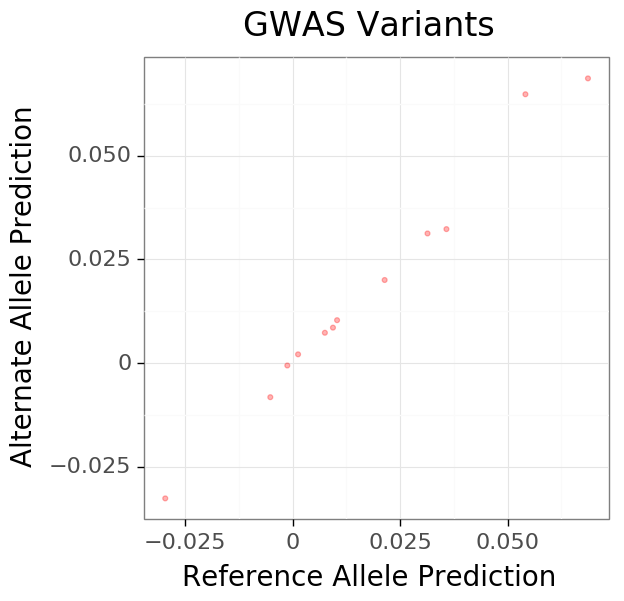

<ggplot: (-9223363251148155567)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
7,chr3,182739778,182739779,rs182753925,C,T,9.171920e-02,-0.295525,0.181985,Y,0.035772,0.032310,-0.003462
2,chr3,182710940,182710941,rs78126209,A,G,8.569130e-01,0.010954,0.060833,Y,-0.005175,-0.008223,-0.003048
0,chr3,182710489,182710490,rs147515099,A,G,5.579360e-01,-0.044117,0.074948,Y,-0.029598,-0.032631,-0.003033
1,chr3,182710680,182710681,rs4859261,C,T,4.221840e-08,0.111944,0.020551,Y,0.021408,0.020033,-0.001374
5,chr3,182714378,182714379,rs186753914,A,G,3.377360e-01,-0.142495,0.146379,Y,0.009392,0.008545,-0.000847
4,chr3,182713941,182713942,rs74902465,A,G,4.302800e-08,-0.112069,0.020585,Y,0.007512,0.007310,-0.000202
6,chr3,182739738,182739739,rs11928508,C,G,4.694950e-08,0.113244,0.020874,Y,0.031374,0.031263,-0.000111
8,chr3,182739836,182739837,rs77458140,G,T,7.987470e-01,-0.014804,0.058171,Y,0.068677,0.068657,-0.000021
10,chr3,182740762,182740763,rs146449896,D,I,9.030890e-02,-0.427681,0.267704,Y,0.010347,0.010347,0.000000
11,chr3,182740801,182740802,rs73883999,C,T,9.454170e-02,0.421845,0.267292,Y,-0.001220,-0.000582,0.000638


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
0,chr3,182710489,182710490,rs147515099,A,G,5.579360e-01,-0.044117,0.074948,Y,-0.029598,-0.032631,-0.003033
1,chr3,182710680,182710681,rs4859261,C,T,4.221840e-08,0.111944,0.020551,Y,0.021408,0.020033,-0.001374
5,chr3,182714378,182714379,rs186753914,A,G,3.377360e-01,-0.142495,0.146379,Y,0.009392,0.008545,-0.000847
4,chr3,182713941,182713942,rs74902465,A,G,4.302800e-08,-0.112069,0.020585,Y,0.007512,0.007310,-0.000202
6,chr3,182739738,182739739,rs11928508,C,G,4.694950e-08,0.113244,0.020874,Y,0.031374,0.031263,-0.000111
8,chr3,182739836,182739837,rs77458140,G,T,7.987470e-01,-0.014804,0.058171,Y,0.068677,0.068657,-0.000021
10,chr3,182740762,182740763,rs146449896,D,I,9.030890e-02,-0.427681,0.267704,Y,0.010347,0.010347,0.000000
11,chr3,182740801,182740802,rs73883999,C,T,9.454170e-02,0.421845,0.267292,Y,-0.001220,-0.000582,0.000638
3,chr3,182711005,182711006,rs144166036,G,T,3.460340e-01,-0.428322,0.478385,Y,0.001280,0.002109,0.000829
9,chr3,182739950,182739951,rs73883998,C,T,8.534280e-02,0.433547,0.267406,Y,0.054134,0.064830,0.010696


SNPs NOT in Peaks:


(200, 12)

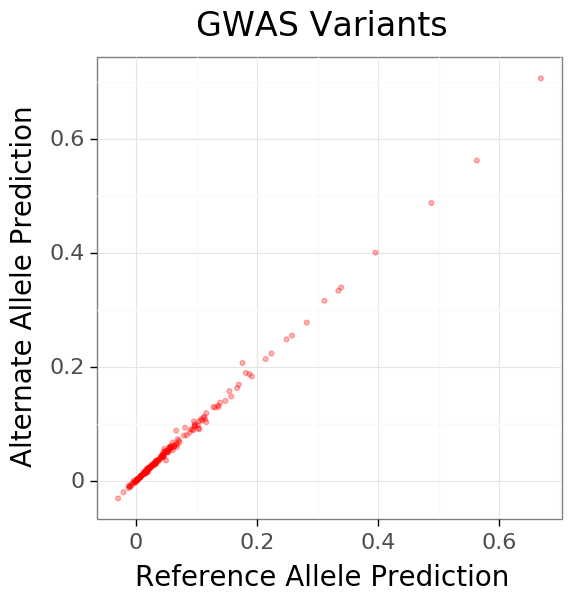

<ggplot: (-9223363251148102179)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
155,chr3,182754694,182754695,rs10937110,A,C,7.920580e-01,0.009584,0.036311,Y,0.049666,0.035814,-0.013852
84,chr3,182733547,182733548,rs12486983,C,T,3.602720e-08,-0.117957,0.021583,Y,0.104565,0.090962,-0.013603
72,chr3,182730173,182730174,rs9877549,C,T,6.854750e-01,-0.014656,0.036127,Y,0.116030,0.103162,-0.012868
116,chr3,182743267,182743268,rs7640612,A,C,4.892030e-08,-0.112918,0.020842,Y,0.103080,0.091956,-0.011124
64,chr3,182728580,182728581,rs142457109,C,T,2.532620e-01,-0.428124,0.394626,Y,0.157321,0.148347,-0.008974
127,chr3,182748161,182748162,rs180925703,C,T,4.597430e-01,-0.172539,0.239058,Y,0.067237,0.059369,-0.007868
129,chr3,182748495,182748496,rs10937108,A,T,4.053010e-10,-0.150923,0.024465,Y,0.191166,0.183485,-0.007681
191,chr3,182763652,182763653,rs3772721,A,C,9.513320e-01,0.003558,0.058394,Y,0.147784,0.140542,-0.007242
189,chr3,182763016,182763017,rs13088830,C,T,6.592040e-05,0.092522,0.023363,Y,0.060799,0.053941,-0.006858
112,chr3,182742859,182742860,rs34132711,C,T,5.902140e-01,0.073270,0.134914,Y,0.136318,0.129680,-0.006638


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
33,chr3,182719224,182719225,rs1979984,C,T,6.088530e-01,0.017972,0.035049,Y,0.395394,0.400934,0.005541
181,chr3,182761828,182761829,rs57211814,C,T,1.374020e-01,0.514338,0.323222,Y,0.044910,0.050625,0.005714
47,chr3,182723736,182723737,rs4241561,A,G,2.300040e-01,-0.039922,0.033128,Y,0.060483,0.067543,0.007060
154,chr3,182754574,182754575,rs10937109,A,G,6.397410e-01,-0.016941,0.036122,Y,0.181355,0.189726,0.008371
61,chr3,182727962,182727963,rs6762726,C,G,8.303120e-02,-0.594392,0.316995,Y,0.095610,0.104745,0.009135
120,chr3,182745730,182745731,rs78062768,C,T,1.002040e-01,0.413434,0.266097,Y,0.046679,0.056281,0.009602
66,chr3,182729103,182729104,rs12496089,G,T,9.055830e-01,-0.006024,0.050753,Y,0.081225,0.093340,0.012114
41,chr3,182721367,182721368,rs76575391,C,G,7.271710e-01,-0.020656,0.059355,Y,0.066457,0.088392,0.021935
102,chr3,182737509,182737510,rs6443842,A,G,6.769160e-01,-0.015084,0.036138,Y,0.175866,0.207083,0.031217
62,chr3,182728181,182728182,rs4074310,G,T,1.454780e-11,0.162319,0.024386,Y,0.668511,0.706987,0.038476


FOLD:  3
All SNPs:


(90, 12)

SNPs NOT in Peaks:


(90, 12)

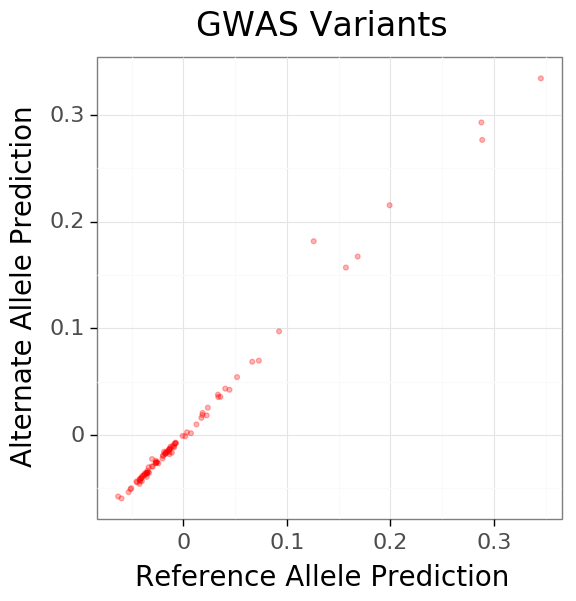

<ggplot: (8785706784092)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
14,chr6,27671825,27671826,rs13192965,A,G,0.433870,-0.026299,0.033509,Y,0.288766,0.276749,-0.012017
11,chr6,27671598,27671599,rs149417812,C,T,0.840737,-0.024350,0.120784,Y,0.345419,0.334457,-0.010962
49,chr6,27679125,27679126,rs73389013,C,G,0.469550,0.291358,0.421535,Y,0.007211,0.001593,-0.005618
19,chr6,27673073,27673074,rs16867921,C,G,0.047825,0.067200,0.034218,Y,-0.011158,-0.016642,-0.005484
8,chr6,27671359,27671360,rs186281424,G,T,0.431816,-0.216143,0.283047,Y,-0.013504,-0.018054,-0.004550
43,chr6,27676962,27676963,rs115568705,C,T,0.516755,-0.528771,0.866056,Y,0.022429,0.018327,-0.004103
41,chr6,27676835,27676836,rs73739606,C,G,0.056884,0.182852,0.093810,Y,-0.035525,-0.039384,-0.003858
53,chr6,27679545,27679546,rs9468197,A,G,0.024338,-0.207894,0.089915,Y,-0.042414,-0.045945,-0.003531
21,chr6,27673678,27673679,rs191578809,C,T,0.446837,-0.148957,0.193001,Y,0.072861,0.069669,-0.003191
7,chr6,27671293,27671294,rs114842791,G,T,0.438768,0.390454,0.533470,Y,0.001779,-0.001276,-0.003055


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
23,chr6,27673743,27673744,rs6910227,A,G,0.130470,0.061920,0.041238,Y,-0.018784,-0.015748,0.003036
44,chr6,27677316,27677317,rs142720400,C,T,0.878011,0.019235,0.125642,Y,0.040330,0.043402,0.003072
45,chr6,27677489,27677490,rs9380009,C,T,0.273376,0.108041,0.097235,Y,-0.033680,-0.030329,0.003350
35,chr6,27675469,27675470,rs12179134,A,G,0.003356,0.071388,0.024193,Y,0.033369,0.037806,0.004437
22,chr6,27673681,27673682,rs183886171,A,C,0.089972,0.296229,0.169583,Y,0.092400,0.097104,0.004703
15,chr6,27671888,27671889,rs182800448,A,T,0.843246,-0.023957,0.120769,Y,0.287958,0.293132,0.005174
85,chr6,27685158,27685159,rs74783880,C,T,0.017956,0.087005,0.036404,Y,-0.063153,-0.057741,0.005412
42,chr6,27676854,27676855,rs61025649,C,T,0.305882,-0.131009,0.130237,Y,-0.030380,-0.022636,0.007744
10,chr6,27671590,27671591,rs140187308,C,T,0.342305,0.177072,0.183344,Y,0.199222,0.215439,0.016218
9,chr6,27671457,27671458,rs77032218,A,G,0.059146,0.064289,0.034317,Y,0.125859,0.181714,0.055855


FOLD:  5
All SNPs:


(2339, 12)

SNPs in Peaks:


(56, 12)

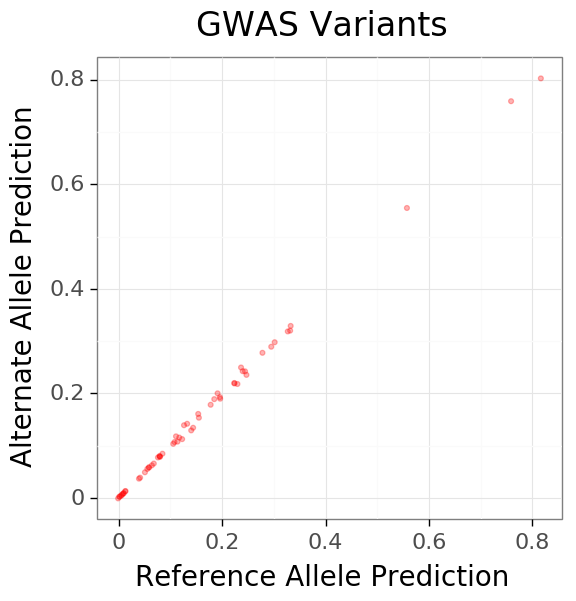

<ggplot: (8785709331169)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
34,chr4,986736,986737,rs115548745,A,G,0.814718,-0.148069,0.623177,Y,0.816262,0.802296,-0.013965
11,chr4,875994,875995,rs2279185,C,G,0.554847,-0.024914,0.042066,Y,0.247123,0.235572,-0.011550
16,chr4,957356,957357,rs75854631,A,G,0.106170,0.080468,0.050315,Y,0.229691,0.218154,-0.011537
21,chr4,958306,958307,rs114739803,C,T,0.804092,0.024863,0.099980,Y,0.331628,0.320126,-0.011502
1,chr4,874986,874987,rs3775131,C,T,0.419328,0.039773,0.049009,Y,0.140310,0.129441,-0.010869
45,chr4,987663,987664,rs3806758,C,G,0.100219,-0.037952,0.023033,Y,0.122824,0.112765,-0.010059
46,chr4,987673,987674,rs3806759,A,G,0.644937,0.015097,0.032813,Y,0.144032,0.134483,-0.009549
18,chr4,957778,957779,rs2335500,A,G,0.961210,-0.002649,0.054401,Y,0.327031,0.318624,-0.008407
19,chr4,958090,958091,rs34406303,C,G,0.005279,0.096682,0.035040,Y,0.196329,0.190012,-0.006317
8,chr4,875529,875530,rs2279187,C,T,0.000147,0.108625,0.028316,Y,0.113844,0.107938,-0.005906


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
53,chr4,90513906,90513907,rs1603250,C,T,0.039217,0.050770,0.024516,Y,0.001613,0.002831,0.001218
30,chr4,973371,973372,rs10008164,A,G,0.432413,-0.351977,0.429125,Y,0.076040,0.077654,0.001615
4,chr4,875155,875156,rs3775129,A,G,0.000429,-0.087336,0.024621,Y,0.239896,0.242595,0.002698
23,chr4,959063,959064,rs143484618,A,G,0.121640,0.175635,0.116098,Y,0.184935,0.189202,0.004267
3,chr4,875144,875145,rs3775130,A,G,0.000037,-0.121438,0.029109,Y,0.153869,0.160920,0.007050
44,chr4,987554,987555,rs3806757,C,G,0.109142,-0.080699,0.050886,Y,0.110947,0.118079,0.007132
37,chr4,987210,987211,rs2276905,C,T,0.307737,-0.155840,0.155903,Y,0.191342,0.200301,0.008959
15,chr4,876399,876400,rs3736086,C,T,0.520761,-0.027152,0.042145,Y,0.132500,0.142117,0.009617
9,chr4,875671,875672,rs45486093,C,T,0.000773,-0.082935,0.024498,Y,0.126440,0.139318,0.012878
27,chr4,960542,960543,rs35117553,G,T,0.236550,0.057519,0.048939,Y,0.236677,0.249717,0.013040


SNPs NOT in Peaks:


(2283, 12)

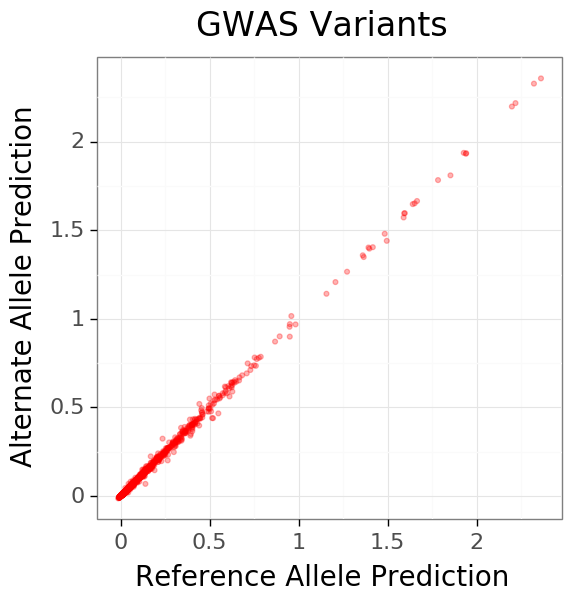

<ggplot: (8785706138751)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
874,chr4,90630355,90630356,rs139349321,A,G,5.700350e-01,0.078577,0.139756,Y,0.548867,0.466813,-0.082054
1271,chr4,90709594,90709595,rs115322031,C,T,3.383940e-02,-0.168068,0.080846,Y,0.519270,0.439722,-0.079548
514,chr4,90554583,90554584,rs60949932,A,G,3.959100e-01,-0.327624,0.403171,Y,0.513953,0.440138,-0.073815
265,chr4,975565,975566,rs114865405,A,G,4.198930e-01,0.158328,0.200142,Y,0.138996,0.068973,-0.070023
41,chr4,876806,876807,rs11731840,A,G,5.200110e-01,-0.027200,0.042144,Y,0.264227,0.201434,-0.062793
1591,chr4,90758508,90758509,rs34956990,A,C,8.889190e-01,0.006257,0.044831,Y,1.495579,1.440751,-0.054828
179,chr4,952644,952645,rs73064477,A,G,3.609260e-01,-0.283256,0.299200,Y,0.391544,0.340845,-0.050699
1593,chr4,90759047,90759048,rs2619363,G,T,1.427720e-08,0.117808,0.020641,Y,0.950395,0.899880,-0.050515
163,chr4,949883,949884,rs74391911,C,G,1.294760e-01,-0.075843,0.050504,Y,0.298470,0.248336,-0.050134
31,chr4,873023,873024,rs77689311,C,T,4.175760e-01,0.039911,0.048993,Y,0.611713,0.562333,-0.049380


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
236,chr4,967445,967446,rs13137144,A,G,6.905380e-09,0.113717,0.019637,Y,0.713721,0.748990,0.035269
261,chr4,975238,975239,rs73211813,C,T,4.000290e-04,0.088923,0.024930,Y,0.455868,0.496729,0.040861
80,chr4,906903,906904,rs6842808,C,T,2.807460e-06,0.134106,0.028264,Y,0.389057,0.432020,0.042963
32,chr4,873181,873182,rs57445359,G,T,4.961780e-01,0.028835,0.042227,Y,0.527325,0.573291,0.045966
174,chr4,951947,951948,rs34311866,C,T,2.476780e-12,-0.165559,0.023347,Y,0.339284,0.385495,0.046211
330,chr4,77173914,77173915,rs13117238,A,C,2.443280e-03,-0.075207,0.024655,Y,0.498945,0.550540,0.051595
473,chr4,90522084,90522085,rs183851917,A,G,1.762410e-02,0.283012,0.123434,Y,0.168763,0.224233,0.055470
2024,chr4,90837532,90837533,rs3775472,A,C,1.171570e-06,-0.195925,0.039467,Y,0.959170,1.016315,0.057145
1258,chr4,90705960,90705961,rs143963281,C,T,4.412930e-01,-0.157300,0.208153,Y,0.442110,0.519992,0.077882
1876,chr4,90810732,90810733,rs74664209,C,G,1.338330e-09,0.272700,0.043602,Y,0.235311,0.324035,0.088725


FOLD:  7
All SNPs:


(5222, 12)

SNPs in Peaks:


(473, 12)

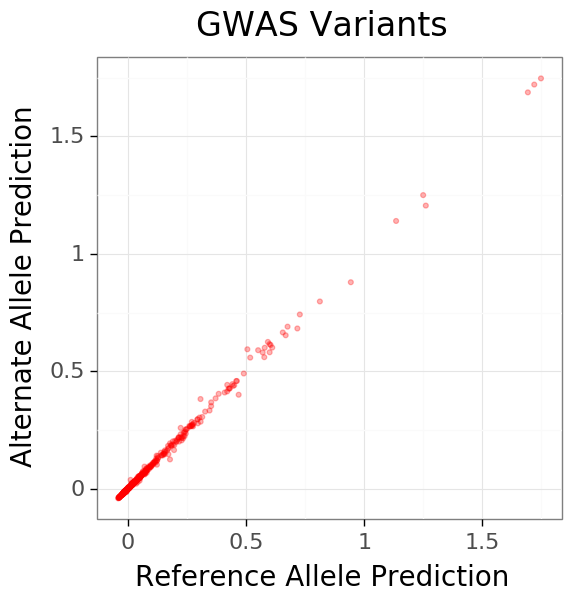

<ggplot: (8785706679223)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
174,chr17,43909690,43909691,rs116060954,A,G,9.040240e-01,-0.021208,0.176350,Y,0.468955,0.400336,-0.068619
87,chr17,43784935,43784936,rs78568882,C,G,2.262890e-22,-0.228503,0.023952,Y,0.943549,0.879030,-0.064519
2,chr17,43394569,43394570,rs115344032,C,G,1.227880e-03,0.301428,0.089844,Y,1.260926,1.205054,-0.055872
250,chr17,44014137,44014138,rs12150460,G,T,4.038280e-22,-0.226906,0.023926,Y,0.178409,0.125217,-0.053193
289,chr17,44065901,44065902,rs919464,C,T,2.189750e-22,-0.228225,0.023915,Y,0.717347,0.682329,-0.035018
390,chr17,44200015,44200016,rs62061856,C,T,2.687150e-22,0.227719,0.023911,Y,0.195586,0.164986,-0.030599
86,chr17,43784777,43784778,rs1617406,A,G,1.859130e-03,0.075138,0.023992,Y,0.171667,0.147277,-0.024390
285,chr17,44065669,44065670,rs919461,A,T,2.191480e-22,-0.228224,0.023915,Y,0.308152,0.285743,-0.022408
68,chr17,43767815,43767816,rs17688296,C,T,2.677040e-22,-0.228096,0.023950,Y,0.227874,0.206229,-0.021645
80,chr17,43779419,43779420,rs17688944,A,T,2.071310e-22,0.228691,0.023950,Y,0.123105,0.102795,-0.020310


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
196,chr17,43938796,43938797,rs55646970,A,G,3.325480e-22,-0.227446,0.023934,Y,0.579249,0.600278,0.021029
316,chr17,44104343,44104344,rs2158257,A,C,2.489190e-22,-0.227873,0.023909,Y,0.420679,0.442321,0.021642
393,chr17,44200078,44200079,rs112560196,A,T,2.688010e-22,-0.227718,0.023911,Y,0.070534,0.094547,0.024013
238,chr17,44006896,44006897,rs62061706,C,T,4.034200e-22,0.226653,0.023899,Y,0.011732,0.038150,0.026418
198,chr17,43938997,43938998,rs734629,A,C,7.653870e-01,0.144327,0.475459,Y,0.592651,0.625045,0.032394
67,chr17,43767804,43767805,rs117430135,A,G,1.492290e-02,0.120150,0.048673,Y,0.223595,0.259377,0.035782
262,chr17,44024562,44024563,rs62062785,G,T,3.333700e-22,-0.227320,0.023921,Y,0.551368,0.589841,0.038473
88,chr17,43784948,43784949,rs62056912,G,T,2.269110e-22,-0.228496,0.023952,Y,0.517831,0.558300,0.040469
338,chr17,44121917,44121918,rs77768866,C,T,2.510300e-22,-0.227852,0.023909,Y,0.307565,0.382137,0.074572
89,chr17,43784994,43784995,rs62056913,C,T,2.273570e-22,-0.228491,0.023952,Y,0.505837,0.593753,0.087916


SNPs NOT in Peaks:


(4749, 12)

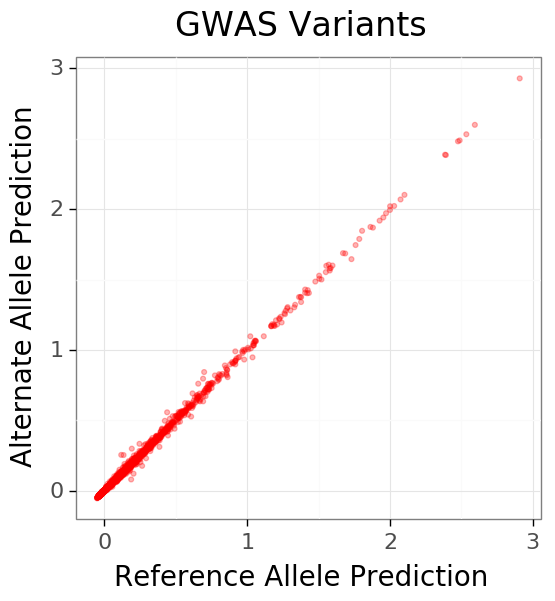

<ggplot: (-9223363251145020058)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
240,chr17,43504217,43504218,rs73307518,C,T,8.362310e-02,0.053452,0.030742,Y,0.187923,0.080330,-0.107593
490,chr17,43661751,43661752,rs2693359,A,T,1.714650e-17,0.264477,0.031715,Y,1.037665,0.947322,-0.090344
2443,chr17,43993709,43993710,rs114020901,C,G,3.528520e-01,-0.378884,0.394921,Y,0.264707,0.177003,-0.087703
4241,chr17,44270924,44270925,rs187270294,C,T,1.327280e-15,-0.337798,0.043358,Y,1.730480,1.644592,-0.085888
1176,chr17,43805590,43805591,rs62054388,C,T,3.345750e-22,-0.227387,0.023931,Y,0.204904,0.121444,-0.083460
1352,chr17,43828935,43828936,rs17426106,C,G,2.908400e-22,0.227702,0.023929,Y,0.607835,0.526851,-0.080984
3014,chr17,44081527,44081528,rs62064665,C,T,2.110720e-22,0.228320,0.023915,Y,0.385872,0.311731,-0.074141
1326,chr17,43825568,43825569,rs62054436,C,T,2.941700e-22,-0.227666,0.023928,Y,0.292385,0.230581,-0.061805
4735,chr17,44866805,44866806,rs11658976,A,G,1.082640e-02,0.051482,0.020180,Y,0.691978,0.635005,-0.056973
3075,chr17,44091092,44091093,rs62062269,C,G,2.101730e-22,0.228323,0.023915,Y,0.863601,0.806761,-0.056840


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
1696,chr17,43892684,43892685,rs72834580,C,G,4.323160e-02,-0.056166,0.027632,Y,0.617536,0.691512,0.073976
2083,chr17,43945100,43945101,rs11869096,A,G,2.069490e-03,-0.057993,0.018814,Y,1.022100,1.096731,0.074632
3104,chr17,44094667,44094668,rs2316948,C,G,2.222920e-22,-0.228177,0.023913,Y,0.246024,0.333415,0.087391
2323,chr17,43974889,43974890,rs62056784,C,G,3.938970e-22,-0.226704,0.023898,Y,0.657473,0.760279,0.102806
1354,chr17,43829113,43829114,rs148989586,A,G,1.770630e-01,0.203888,0.155336,Y,0.691367,0.795998,0.104631
3333,chr17,44134984,44134985,rs62060768,A,G,2.509110e-22,0.227852,0.023909,Y,0.192368,0.299107,0.106739
3380,chr17,44144234,44144235,rs117385703,C,T,9.072530e-01,-0.005888,0.050503,Y,0.439748,0.557216,0.117468
3162,chr17,44105861,44105862,rs114542437,A,C,2.785290e-01,0.139420,0.126383,Y,0.134881,0.253800,0.118919
3332,chr17,44134954,44134955,rs12449717,C,G,6.692500e-01,0.042469,0.099993,Y,0.118363,0.254725,0.136362
3077,chr17,44091417,44091418,rs118109282,C,T,3.766400e-01,-0.087599,0.100243,Y,0.699020,0.843080,0.144060


FOLD:  8
All SNPs:


(4093, 12)

SNPs in Peaks:


(136, 12)

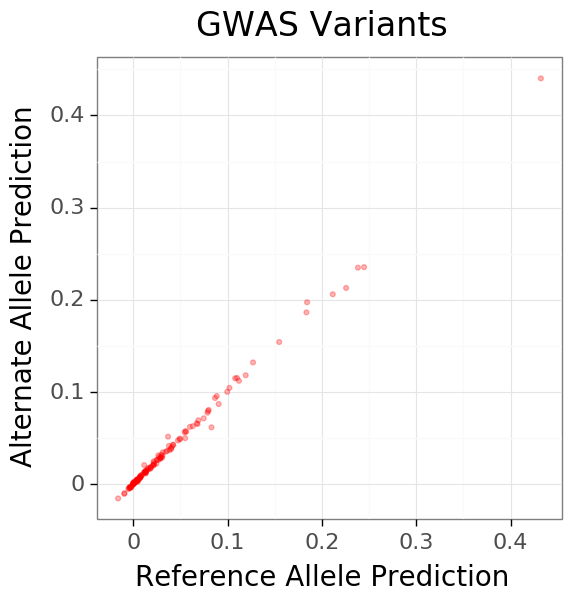

<ggplot: (-9223363251148807669)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
60,chr12,41312147,41312148,rs1372543,A,G,5.090900e-01,-0.031469,0.047479,Y,0.082961,0.061570,-0.021391
74,chr12,41407403,41407404,rs278899,A,G,5.572040e-03,0.061770,0.022185,Y,0.225616,0.212810,-0.012806
88,chr12,41459242,41459243,rs181012052,C,T,6.834610e-01,0.066059,0.160853,Y,0.244657,0.235417,-0.009240
59,chr12,41311737,41311738,rs73126511,C,T,8.880580e-01,-0.010252,0.072930,Y,0.211479,0.205943,-0.005536
76,chr12,41408603,41408604,rs78037279,C,T,4.728930e-01,0.188869,0.257034,Y,0.055033,0.049843,-0.005190
127,chr12,123268734,123268735,rs12305822,C,T,1.078310e-01,0.065615,0.040488,Y,0.090560,0.086846,-0.003713
77,chr12,41408740,41408741,rs35862989,A,T,4.578600e-02,-0.086695,0.043869,Y,0.074718,0.071374,-0.003345
75,chr12,41408134,41408135,rs397967,A,G,2.227530e-09,-0.333909,0.053696,Y,0.238126,0.234818,-0.003309
25,chr12,40794271,40794272,rs3861083,C,T,3.166010e-01,0.029977,0.030028,Y,0.068120,0.065173,-0.002947
120,chr12,123233108,123233109,rs117690470,A,G,1.048200e-01,0.331998,0.212655,Y,0.024540,0.022119,-0.002421


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
73,chr12,41407060,41407061,rs11179482,C,G,0.074041,-0.049874,0.027781,Y,0.026585,0.031181,0.004596
89,chr12,41459908,41459909,rs280379,C,T,0.991462,-0.002761,0.258370,Y,0.126980,0.132023,0.005042
135,chr12,123269814,123269815,rs1696320,A,G,0.908744,-0.003324,0.028990,Y,0.110005,0.115156,0.005151
55,chr12,41311370,41311371,rs11179040,G,T,0.296227,-0.019698,0.018853,Y,0.086720,0.093367,0.006647
122,chr12,123238416,123238417,rs79350782,G,T,0.121629,0.064001,0.041032,Y,0.108012,0.114808,0.006796
130,chr12,123268884,123268885,rs75875275,A,G,0.106533,0.065856,0.040486,Y,0.088479,0.095501,0.007023
63,chr12,41312642,41312643,rs144175278,C,T,0.075208,0.152721,0.084239,Y,0.432013,0.440197,0.008184
91,chr12,41460500,41460501,rs280377,C,T,0.755564,0.094481,0.307266,Y,0.011638,0.020603,0.008965
56,chr12,41311418,41311419,rs10506179,C,T,0.318796,0.019336,0.019409,Y,0.184232,0.197302,0.013070
54,chr12,41311339,41311340,rs187801857,A,T,0.516318,-0.192545,0.304514,Y,0.036907,0.051479,0.014572


SNPs NOT in Peaks:


(3957, 12)

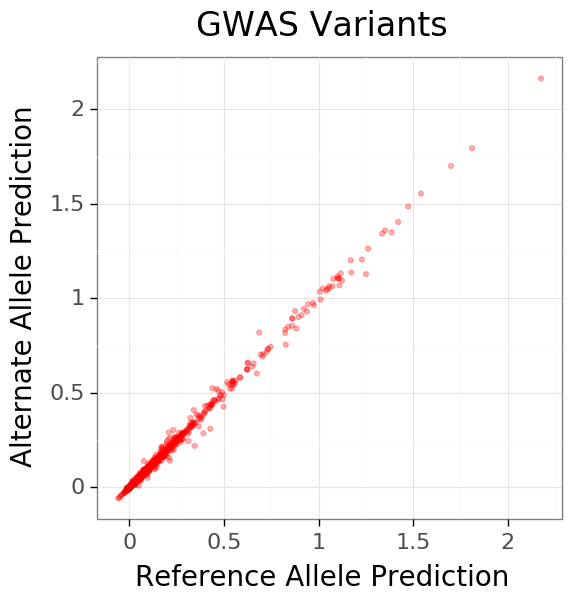

<ggplot: (8785706679125)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
1937,chr12,40736885,40736886,rs150954733,A,C,7.282880e-05,-0.493979,0.119268,Y,0.345244,0.219470,-0.125774
3884,chr12,123326598,123326599,rs10847864,G,T,7.060470e-14,0.153126,0.020362,Y,1.251364,1.127739,-0.123625
3925,chr12,123337761,123337762,rs12298151,A,G,6.186260e-01,-0.019407,0.038896,Y,0.427378,0.310230,-0.117149
2467,chr12,40998598,40998599,rs35955232,C,G,6.234410e-02,0.048763,0.026283,Y,0.391311,0.285856,-0.105455
1908,chr12,40732123,40732124,rs4767972,C,T,1.455140e-01,-0.038195,0.026148,Y,0.213453,0.141265,-0.072189
3924,chr12,123337694,123337695,rs115372896,C,G,6.996560e-01,-0.145430,0.370024,Y,0.826768,0.755306,-0.071462
1629,chr12,40413305,40413306,rs28370664,A,C,1.753300e-20,-0.502667,0.051311,Y,0.674066,0.602985,-0.071081
90,chr12,33206104,33206105,rs7136933,C,G,6.656380e-01,-0.011200,0.025891,Y,0.497115,0.426910,-0.070205
1305,chr12,37961304,37961305,rs1842606,C,T,9.250810e-01,0.001810,0.019248,Y,0.312108,0.244928,-0.067180
1390,chr12,40337418,40337419,rs4768202,A,G,1.291490e-01,-0.040878,0.026834,Y,0.209505,0.156673,-0.052832


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
3890,chr12,123327445,123327446,rs12298664,C,T,0.613898,-0.024684,0.048777,Y,0.214079,0.261775,0.047696
1154,chr12,34637093,34637094,rs72480075,A,G,0.816947,-0.043398,0.186995,Y,0.204879,0.254207,0.049328
1579,chr12,40397235,40397236,rs28370644,C,T,0.063192,0.052799,0.028573,Y,0.875891,0.932401,0.056511
3812,chr12,123311981,123311982,rs1696326,C,T,0.783917,0.013530,0.049258,Y,0.460884,0.520436,0.059551
1246,chr12,34661082,34661083,rs12322956,C,T,0.520815,0.012346,0.019221,Y,0.076166,0.139339,0.063173
89,chr12,33206065,33206066,rs7307789,A,T,0.666257,-0.011178,0.025891,Y,0.340048,0.409286,0.069238
2212,chr12,40882071,40882072,rs1844980,C,G,0.241215,-0.024332,0.020757,Y,0.231887,0.303860,0.071973
1068,chr12,34417692,34417693,rs12824730,C,T,0.288800,0.039501,0.037388,Y,0.207884,0.291047,0.083163
1941,chr12,40737115,40737116,rs10784518,G,T,0.145578,-0.038183,0.026144,Y,0.438471,0.525171,0.086701
3488,chr12,43046449,43046450,rs11181613,A,C,0.248549,-0.029958,0.025892,Y,0.685897,0.819264,0.133367


FOLD:  9
All SNPs:


(323, 12)

SNPs in Peaks:


(43, 12)

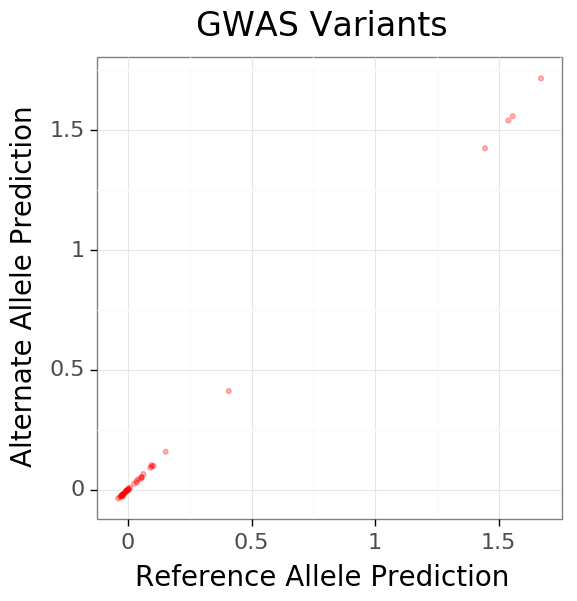

<ggplot: (-9223363251148102179)>

Negative SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
9,chr10,121368348,121368349,rs115879160,G,T,8.644330e-01,-0.026199,0.153915,Y,1.445422,1.423817,-0.021605
28,chr10,121532890,121532891,rs144030311,A,G,9.665760e-01,0.008238,0.197415,Y,-0.020131,-0.029220,-0.009089
34,chr10,121536635,121536636,rs72826422,C,G,6.396350e-02,-0.071163,0.038100,Y,0.035677,0.028954,-0.006723
16,chr10,121369014,121369015,rs12416614,C,T,8.480300e-01,-0.032586,0.170783,Y,0.052414,0.045908,-0.006505
15,chr10,121368873,121368874,rs145701507,C,T,5.835250e-01,-0.159246,0.296942,Y,0.055593,0.049841,-0.005751
42,chr10,121710488,121710489,rs118117788,C,T,2.147610e-08,0.403039,0.068671,Y,0.103249,0.097945,-0.005304
39,chr10,121709909,121709910,rs7914591,C,T,7.836850e-01,0.005418,0.019742,Y,0.001733,-0.001648,-0.003381
25,chr10,121460332,121460333,rs116984350,C,T,1.144750e-01,0.155602,0.100474,Y,0.002946,0.000317,-0.002629
3,chr10,121292329,121292330,rs185953720,G,T,9.753270e-01,-0.004413,0.143041,Y,0.054700,0.052756,-0.001944
21,chr10,121458850,121458851,rs117953397,C,G,9.221510e-02,-0.063552,0.037469,Y,-0.011383,-0.012987,-0.001605


Positive SNPs in Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
38,chr10,121709692,121709693,rs7914220,A,G,0.645982,-0.009563,0.020830,Y,-0.025854,-0.024369,0.001485
13,chr10,121368582,121368583,rs142590307,C,T,0.875046,0.034921,0.222869,Y,0.034152,0.035892,0.001740
0,chr10,121291941,121291942,rs7076994,C,T,0.108689,-0.052327,0.032813,Y,-0.008263,-0.006456,0.001807
2,chr10,121292123,121292124,rs10787976,A,G,0.277104,0.036571,0.033790,Y,0.001425,0.003740,0.002315
41,chr10,121710463,121710464,rs12768226,A,G,0.527462,0.026179,0.041300,Y,0.061838,0.064395,0.002557
27,chr10,121532886,121532887,rs61867903,G,T,0.310642,-0.044365,0.043523,Y,-0.039954,-0.037078,0.002876
8,chr10,121368169,121368170,rs11199044,A,C,0.739901,0.013698,0.041330,Y,0.407619,0.410864,0.003245
14,chr10,121368847,121368848,rs7075175,C,G,0.734674,-0.007222,0.021319,Y,0.152044,0.157539,0.005495
17,chr10,121369051,121369052,rs7075463,A,C,0.730547,0.007336,0.021312,Y,0.094844,0.101618,0.006774
12,chr10,121368477,121368478,rs11199045,C,G,0.170513,0.030679,0.022435,Y,1.672013,1.715338,0.043324


SNPs NOT in Peaks:


(280, 12)

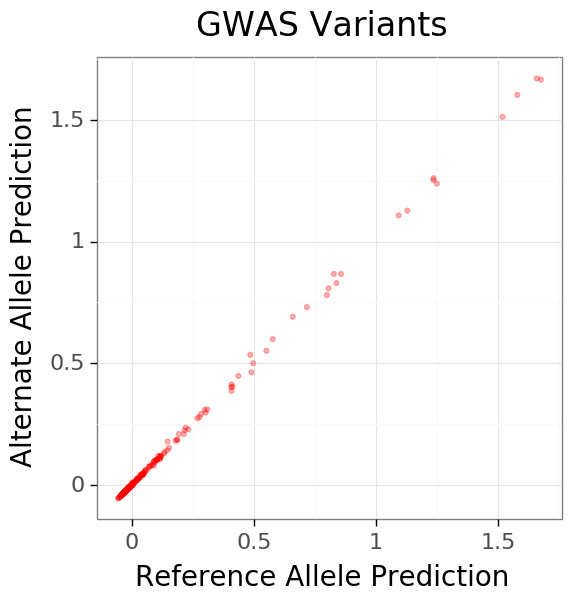

<ggplot: (8785706051427)>

Negative SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
130,chr10,121414758,121414759,rs11199061,A,C,0.405372,0.032578,0.039303,Y,0.490196,0.462643,-0.027553
128,chr10,121414598,121414599,rs12250770,C,T,0.002635,-0.065469,0.021867,Y,0.408217,0.386303,-0.021914
200,chr10,121657050,121657051,rs7089740,A,G,0.760357,-0.010817,0.035422,Y,0.799446,0.780526,-0.018921
129,chr10,121414702,121414703,rs196337,C,T,0.981997,-0.000664,0.029428,Y,1.250179,1.238968,-0.011212
208,chr10,121658842,121658843,rs12257358,A,C,0.000735,0.077735,0.023169,Y,0.089908,0.079092,-0.010817
156,chr10,121462047,121462048,rs11199075,A,G,0.000274,0.080234,0.022175,Y,1.676785,1.666436,-0.010349
199,chr10,121656772,121656773,rs117913510,A,T,0.088687,-0.130761,0.078057,Y,0.115969,0.106232,-0.009737
119,chr10,121411636,121411637,rs2577336,C,G,0.206975,-0.024320,0.019284,Y,0.412828,0.403423,-0.009405
116,chr10,121410904,121410905,rs192502283,C,G,0.079809,-0.183773,0.102930,Y,0.838356,0.829788,-0.008568
160,chr10,121464050,121464051,rs17099211,C,G,0.068557,-0.069240,0.037712,Y,0.115249,0.108634,-0.006614


Positive SNPs OUTSIDE Peaks:


,CHR,START,END,RSID,REF,ALT,PVALUE,BETA,SE,PASS,ref_pred,alt_pred,delta
37,chr10,121367763,121367764,rs17099080,C,T,0.168988,0.030790,0.022437,Y,0.220472,0.235478,0.015006
14,chr10,121296867,121296868,rs7101058,A,G,0.246103,-0.023049,0.019886,Y,0.192758,0.209127,0.016369
84,chr10,121377046,121377047,rs11199050,C,T,0.429689,-0.016900,0.021376,Y,1.235874,1.253337,0.017464
118,chr10,121411631,121411632,rs112168846,A,G,0.416034,0.041580,0.051391,Y,0.577331,0.599177,0.021846
121,chr10,121412132,121412133,rs55725412,A,G,0.138118,-0.030363,0.020508,Y,1.579811,1.603913,0.024102
198,chr10,121656067,121656068,rs35225459,A,G,0.506163,-0.027262,0.040872,Y,1.236790,1.261661,0.024870
92,chr10,121407005,121407006,rs55799229,C,T,0.383413,0.018226,0.020933,Y,0.146371,0.177782,0.031411
26,chr10,121298690,121298691,rs112618631,C,G,0.069449,-0.257034,0.145968,Y,0.659618,0.691368,0.031750
126,chr10,121414205,121414206,rs148789629,C,T,0.023714,-0.361682,0.152992,Y,0.827606,0.867491,0.039885
127,chr10,121414236,121414237,rs196336,C,T,0.804786,-0.004853,0.019640,Y,0.485254,0.535154,0.049899


In [16]:
get_results_all_folds('PD_GBA1_SUNI')

In [27]:
get_results_all_folds('AD_CTRL_PARL')

TASK:  AD_CTRL_PARL


In [28]:
get_results_all_folds('AD_ADAD_PARL')

TASK:  AD_ADAD_PARL


In [29]:
get_results_all_folds('AD_CTRL_HIPP')

TASK:  AD_CTRL_HIPP


In [30]:
get_results_all_folds('AD_ADAD_HIPP')

TASK:  AD_ADAD_HIPP


In [ ]:
get_results_all_folds('PD_CTRL_HIPP')

In [ ]:
get_results_all_folds('PD_GBA1_HIPP')

In [ ]:
get_results_all_folds('AD_CTRL_SMTG')

In [ ]:
get_results_all_folds('AD_ADAD_SMTG')